**BUSINESS PROBLEM**
<br>
**Statement**- Predict material backorder in inventory management using machine learning.
The task is to classify the whether a particular product would go to backorder or not.
<br>
**ML Formulation**-  Classify if the product would go into backorder or not.
<br>
The output of the variable is Yes/No problem.
<br>
So the problem is best framed as a 2-class, single label prediction problem that predicts Yes or No i.e a binary classification problem.
<br>
Yes- The product will go into backorder.<br>
No- The product won’t go into backorder.

**Metrics**



*   Confusion matrix
*   Precision-Recall - precision recall works well with imbalanced data and usually the focus would be on the positive class i.e Went on backorder.
*   Micro-f1 score- Micro f1 score gives weightage to imbalance data unlike macro-f1. But for a binary classification problem it doesn't usually matter.
*   AUC-ROC curve



In [1]:
import os
import time
import datetime
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams   
import seaborn as sns
from tqdm.notebook import tqdm, trange
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight') 
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False 
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
sns.set_palette(custom_colors)
%config InlineBackend.figure_format = 'retina'
pd.set_option('max_colwidth', 40)
pd.options.display.max_columns = None  # Possible to limit
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.preprocessing import RobustScaler
from pandas.plotting import scatter_matrix
from sklearn.manifold import TSNE



np.random.seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [55]:
data=pd.read_csv('/content/drive/MyDrive/train_data.csv')
test_data=pd.read_csv('/content/drive/MyDrive/test_data.csv')

frames = [data,test_data]
merged = pd.concat(frames)

print(len(merged)==(len(test_data)+len(data)))




True


>**Sku(Stock Keeping unit)** : The product id — Unique for each row so can be ignored

>**National_inv** : The present inventory level of the product

>**Lead_time** : Transit time of the product

>**In_transit_qty** : The amount of product in transit

>**Forecast_3_month , Forecast_6_month , Forecast_9_month** : Forecast of the sales of the product for coming 3 , 6 and 9 months respectively

>**Sales_1_month , sales_3_month ,sales_6_month , sales_9_month** : Actual sales of the product in last 1 , 3 ,6 and 9 months respectively

>**Min_bank** : Minimum amount of stock recommended

>**Potential_issue** : Any problem identified in the product/part

>**Pieces_past_due**: Amount of parts of the product overdue if any

>**Perf_6_month_avg , perf_12_month_avg** : Product performance over past 6 and 12 months respectively

>**Local_bo_qty** : Amount of stock overdue

>**Went_on_backorder** : Target variable


In [ ]:
data.shape

(1687861, 23)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1687861 non-null  object 
 1   national_inv       1687860 non-null  float64
 2   lead_time          1586967 non-null  float64
 3   in_transit_qty     1687860 non-null  float64
 4   forecast_3_month   1687860 non-null  float64
 5   forecast_6_month   1687860 non-null  float64
 6   forecast_9_month   1687860 non-null  float64
 7   sales_1_month      1687860 non-null  float64
 8   sales_3_month      1687860 non-null  float64
 9   sales_6_month      1687860 non-null  float64
 10  sales_9_month      1687860 non-null  float64
 11  min_bank           1687860 non-null  float64
 12  potential_issue    1687860 non-null  object 
 13  pieces_past_due    1687860 non-null  float64
 14  perf_6_month_avg   1687860 non-null  float64
 15  perf_12_month_avg  1687860 non-n

In [ ]:
data.tail()

sku  national_inv  lead_time  in_transit_qty  \
1687856         1373987          -1.0        NaN             0.0   
1687857         1524346          -1.0        9.0             0.0   
1687858         1439563          62.0        9.0            16.0   
1687859         1502009          19.0        4.0             0.0   
1687860  (1687860 rows)           NaN        NaN             NaN   

         forecast_3_month  forecast_6_month  forecast_9_month  sales_1_month  \
1687856               5.0               7.0               9.0            1.0   
1687857               7.0               9.0              11.0            0.0   
1687858              39.0              87.0             126.0           35.0   
1687859               0.0               0.0               0.0            2.0   
1687860               NaN               NaN               NaN            NaN   

         sales_3_month  sales_6_month  sales_9_month  min_bank  \
1687856            3.0            3.0            8.0       0.0   
1687857            8.0           11.0           12.0       0.0   
1687858           63.0          153.0          205.0      12.0   
1687859            7.0           12.0           20.0       1.0   
1687860            NaN            NaN            NaN       NaN   

        potential_issue  pieces_past_due  perf_6_month_avg  perf_12_month_avg  \
1687856              No              0.0            -99.00             -99.00   
1687857              No              0.0              0.86               0.84   
1687858              No              0.0              0.86               0.84   
1687859              No              0.0              0.73               0.78   
1687860             NaN              NaN               NaN                NaN   

         local_bo_qty deck_risk oe_constraint ppap_risk stop_auto_buy  \
1687856           1.0        No            No        No           Yes   
1687857           1.0       Yes            No        No            No   
1687858           6.0        No            No        No           Yes   
1687859           1.0        No            No        No           Yes   
1687860           NaN       NaN           NaN       NaN           NaN   

        rev_stop went_on_backorder  
1687856       No                No  
1687857       No               Yes  
1687858       No                No  
1687859       No                No  
1687860      NaN               NaN

In [ ]:
data.skew(axis=0)

national_inv         340.285800
lead_time              4.556295
in_transit_qty       166.183404
forecast_3_month     138.968325
forecast_6_month     138.961427
forecast_9_month     143.298875
sales_1_month        196.119990
sales_3_month        141.286380
sales_6_month        139.176712
sales_9_month        135.054191
min_bank             131.212649
pieces_past_due      412.391900
perf_6_month_avg      -3.180622
perf_12_month_avg     -3.302181
local_bo_qty         165.190548
dtype: float64

In [ ]:
data.describe()

national_inv     lead_time  in_transit_qty  forecast_3_month  \
count  1.687860e+06  1.586967e+06    1.687860e+06      1.687860e+06   
mean   4.961118e+02  7.872267e+00    4.405202e+01      1.781193e+02   
std    2.961523e+04  7.056024e+00    1.342742e+03      5.026553e+03   
min   -2.725600e+04  0.000000e+00    0.000000e+00      0.000000e+00   
25%    4.000000e+00  4.000000e+00    0.000000e+00      0.000000e+00   
50%    1.500000e+01  8.000000e+00    0.000000e+00      0.000000e+00   
75%    8.000000e+01  9.000000e+00    0.000000e+00      4.000000e+00   
max    1.233440e+07  5.200000e+01    4.894080e+05      1.427612e+06   

       forecast_6_month  forecast_9_month  sales_1_month  sales_3_month  \
count      1.687860e+06      1.687860e+06   1.687860e+06   1.687860e+06   
mean       3.449867e+02      5.063644e+02   5.592607e+01   1.750259e+02   
std        9.795152e+03      1.437892e+04   1.928196e+03   5.192378e+03   
min        0.000000e+00      0.000000e+00   0.000000e+00   0.000000e+00   
25%        0.000000e+00      0.000000e+00   0.000000e+00   0.000000e+00   
50%        0.000000e+00      0.000000e+00   0.000000e+00   1.000000e+00   
75%        1.200000e+01      2.000000e+01   4.000000e+00   1.500000e+01   
max        2.461360e+06      3.777304e+06   7.417740e+05   1.105478e+06   

       sales_6_month  sales_9_month      min_bank  pieces_past_due  \
count   1.687860e+06   1.687860e+06  1.687860e+06     1.687860e+06   
mean    3.417288e+02   5.252697e+02  5.277230e+01     2.043724e+00   
std     9.613167e+03   1.483861e+04  1.254983e+03     2.360165e+02   
min     0.000000e+00   0.000000e+00  0.000000e+00     0.000000e+00   
25%     0.000000e+00   0.000000e+00  0.000000e+00     0.000000e+00   
50%     2.000000e+00   4.000000e+00  0.000000e+00     0.000000e+00   
75%     3.100000e+01   4.700000e+01  3.000000e+00     0.000000e+00   
max     2.146625e+06   3.205172e+06  3.133190e+05     1.464960e+05   

       perf_6_month_avg  perf_12_month_avg  local_bo_qty  
count      1.687860e+06       1.687860e+06  1.687860e+06  
mean      -6.872059e+00      -6.437947e+00  6.264507e-01  
std        2.655636e+01       2.584333e+01  3.372224e+01  
min       -9.900000e+01      -9.900000e+01  0.000000e+00  
25%        6.300000e-01       6.600000e-01  0.000000e+00  
50%        8.200000e-01       8.100000e-01  0.000000e+00  
75%        9.700000e-01       9.500000e-01  0.000000e+00  
max        1.000000e+00       1.000000e+00  1.253000e+04

In [ ]:
data.describe(include=['O'])

sku potential_issue deck_risk oe_constraint ppap_risk  \
count   1687861         1687860   1687860       1687860   1687860   
unique  1687861               2         2             2         2   
top     3282082              No        No            No        No   
freq          1         1686953   1300377       1687615   1484026   

       stop_auto_buy rev_stop went_on_backorder  
count        1687860  1687860           1687860  
unique             2        2                 2  
top              Yes       No                No  
freq         1626774  1687129           1676567

In [ ]:
missing=data.isnull().sum().sort_values(ascending=False)
missing

lead_time            100894
went_on_backorder         1
sales_9_month             1
national_inv              1
in_transit_qty            1
forecast_3_month          1
forecast_6_month          1
forecast_9_month          1
sales_1_month             1
sales_3_month             1
sales_6_month             1
min_bank                  1
rev_stop                  1
potential_issue           1
pieces_past_due           1
perf_6_month_avg          1
perf_12_month_avg         1
local_bo_qty              1
deck_risk                 1
oe_constraint             1
ppap_risk                 1
stop_auto_buy             1
sku                       0
dtype: int64

In [ ]:
np.round(data.isnull().mean() * 100,1)

sku                  0.0
national_inv         0.0
lead_time            6.0
in_transit_qty       0.0
forecast_3_month     0.0
forecast_6_month     0.0
forecast_9_month     0.0
sales_1_month        0.0
sales_3_month        0.0
sales_6_month        0.0
sales_9_month        0.0
min_bank             0.0
potential_issue      0.0
pieces_past_due      0.0
perf_6_month_avg     0.0
perf_12_month_avg    0.0
local_bo_qty         0.0
deck_risk            0.0
oe_constraint        0.0
ppap_risk            0.0
stop_auto_buy        0.0
rev_stop             0.0
went_on_backorder    0.0
dtype: float64

In [ ]:
data['went_on_backorder'].value_counts()

No     1676567
Yes      11293
Name: went_on_backorder, dtype: int64

In [ ]:
1676567/11293

148.46072788453023

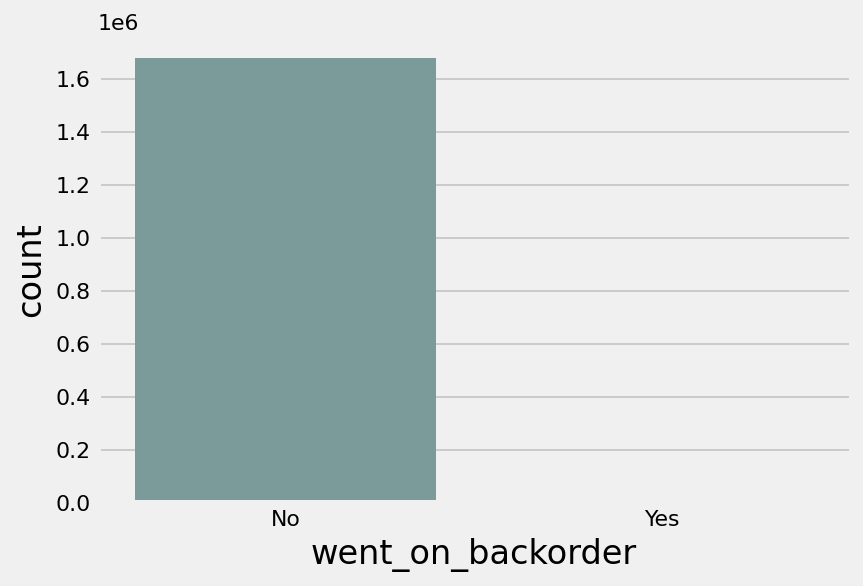

In [ ]:
ax = sns.countplot(x="went_on_backorder", data=data)
plt.show()

In [3]:
quantvars=['national_inv',
           'lead_time',
           'in_transit_qty',
           'forecast_3_month',
           'forecast_6_month',
           'forecast_9_month',
           'sales_1_month',
           'sales_3_month',
           'sales_6_month',
           'sales_9_month',
           'min_bank',
           'pieces_past_due',
           'perf_6_month_avg',
           'perf_12_month_avg',
           'local_bo_qty']

catpred=['potential_issue','deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop']
categorical_list=catpred+['went_on_backorder']



1.   There are 1.6 million entries and 23 columns (dtypes: float64(15), object(8))
2.   There is no null value in the dataset
3. There is  1 missing value in every column except Lead_time,which has 100894(6%) missing values.
4. The last row should be eliminated as it only contains Nan values.
5. SKU row is an unique identifier and it serves no purpose. 
5. The data mostly is positively skewed.
5. The skew values show that we have to normalize the data.   
1. Most the categorical values are boolean values and can be changed to 1/0 along with the y(went_on_backorder)
2. The data is imbalanced as top element of **went_on_backorder** is **No** with 1676567 frequency.

















Text(0.5, 1.0, 'box plot of national_inv')

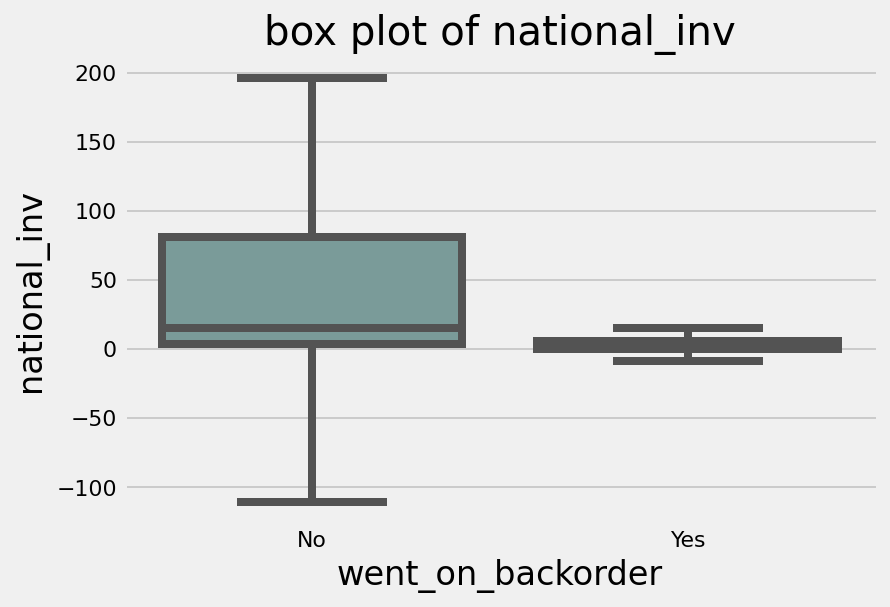

Text(0.5, 1.0, 'box plot of lead_time')

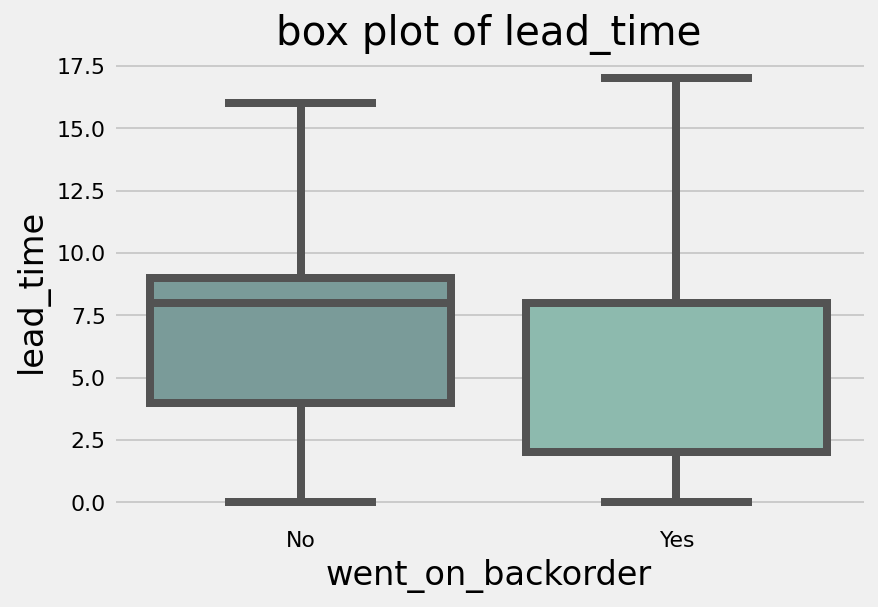

Text(0.5, 1.0, 'box plot of in_transit_qty')

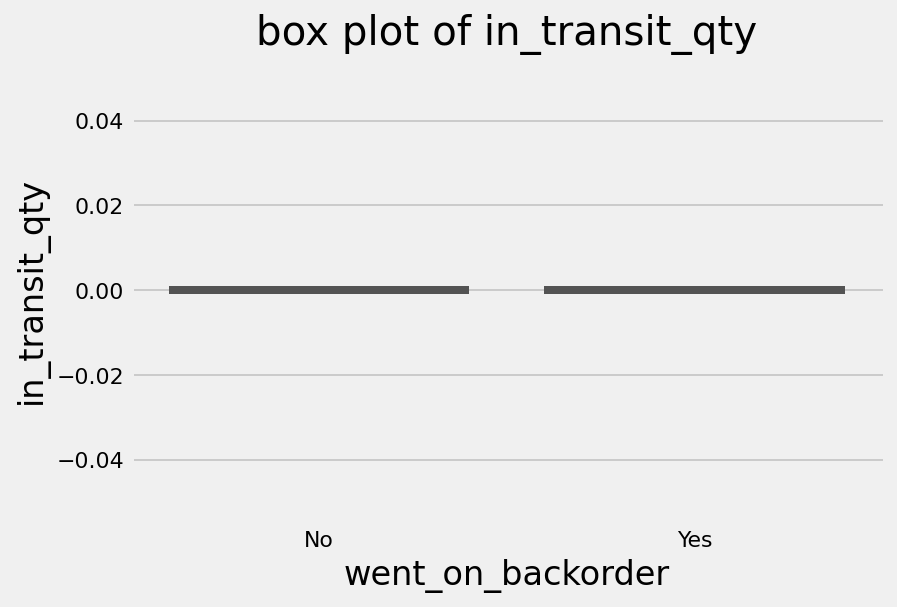

Text(0.5, 1.0, 'box plot of forecast_3_month')

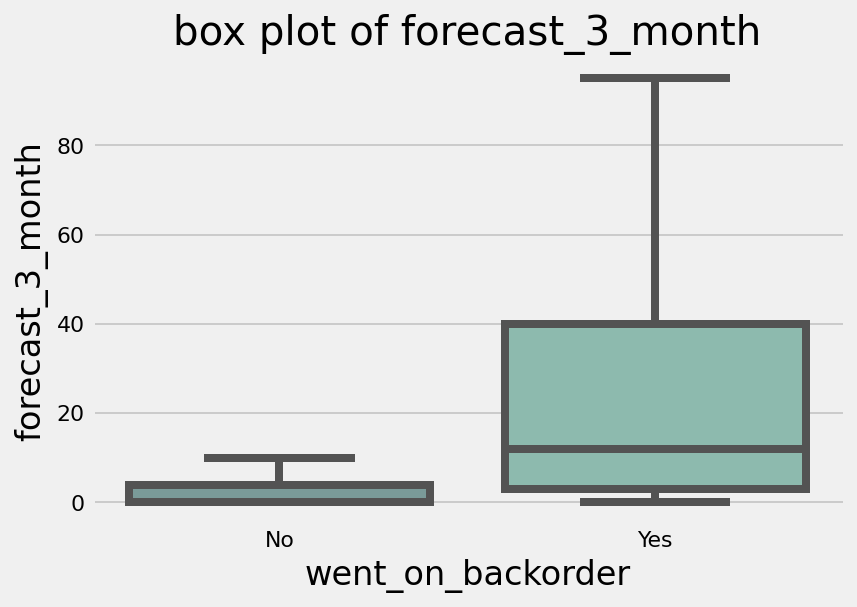

Text(0.5, 1.0, 'box plot of forecast_6_month')

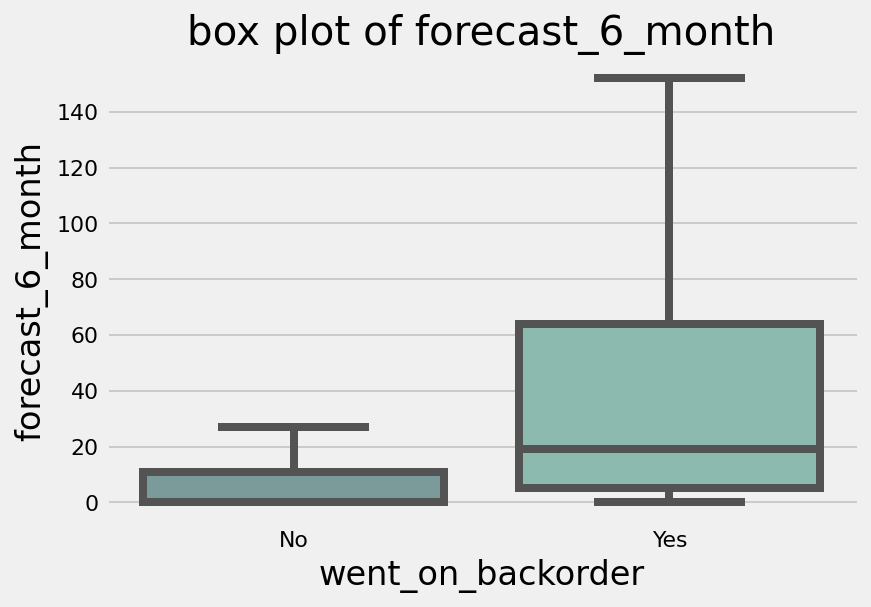

Text(0.5, 1.0, 'box plot of forecast_9_month')

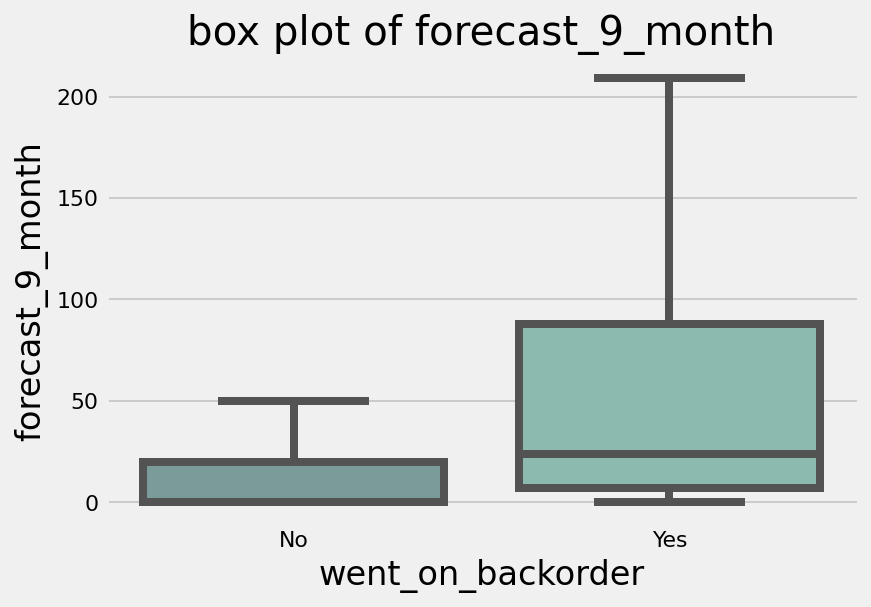

Text(0.5, 1.0, 'box plot of sales_1_month')

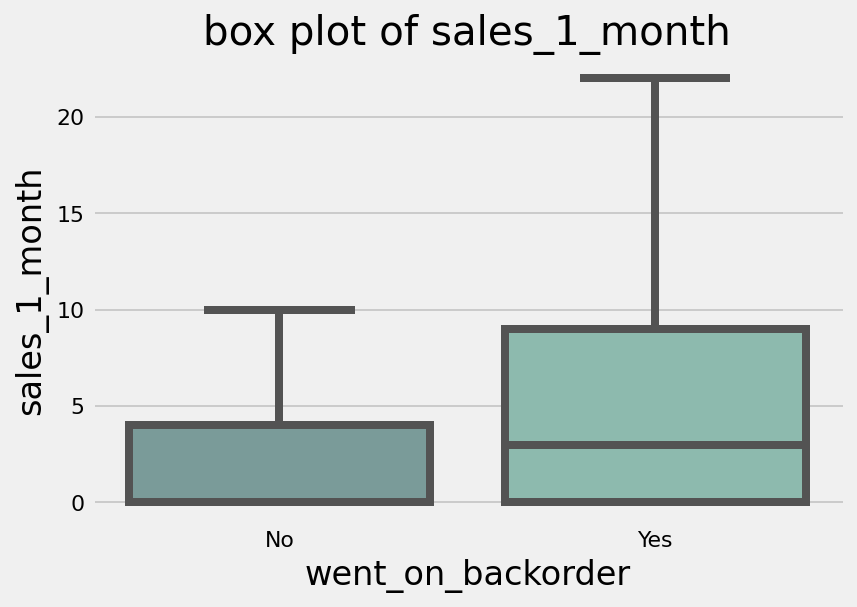

Text(0.5, 1.0, 'box plot of sales_3_month')

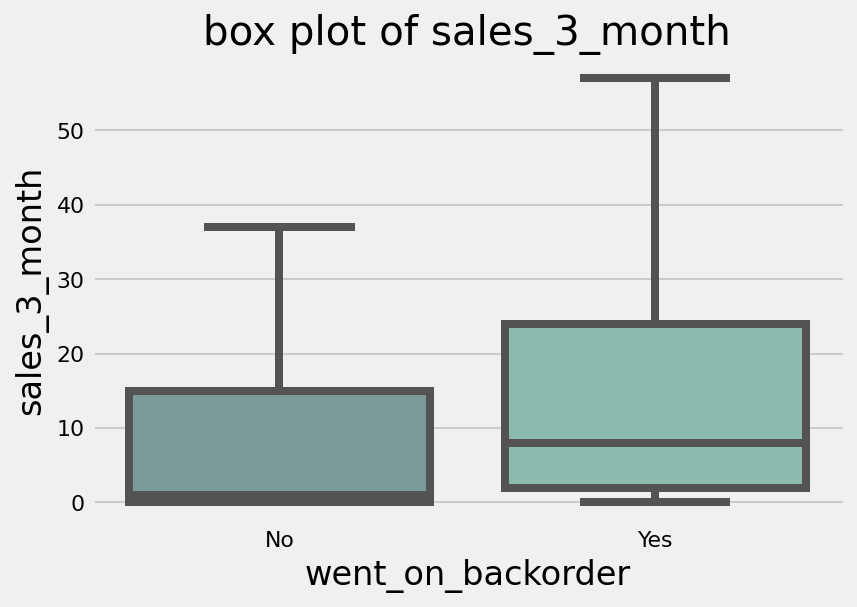

Text(0.5, 1.0, 'box plot of sales_6_month')

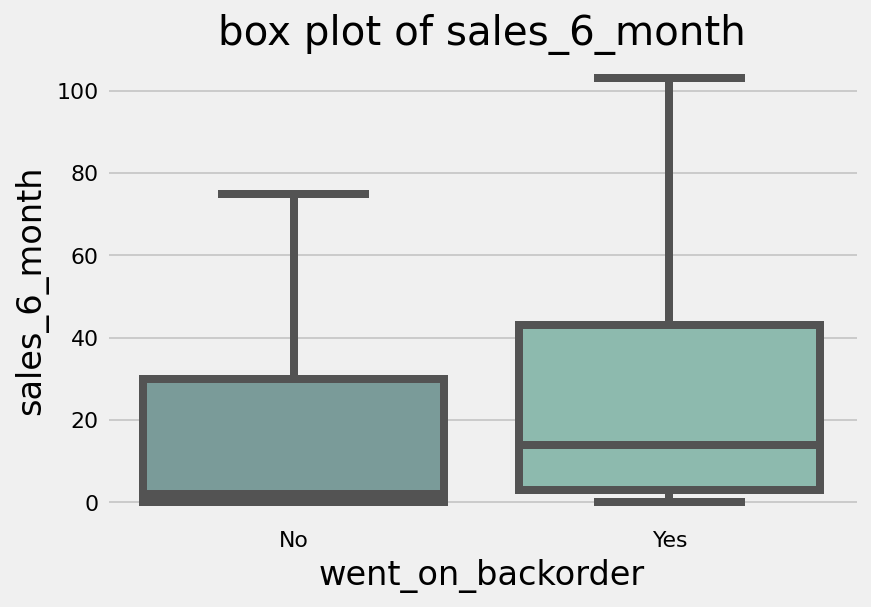

Text(0.5, 1.0, 'box plot of sales_9_month')

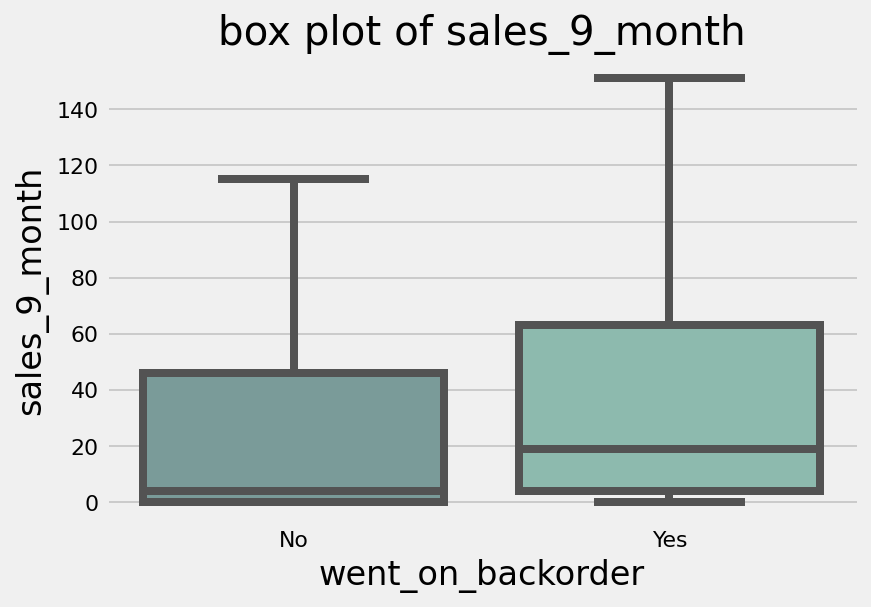

Text(0.5, 1.0, 'box plot of min_bank')

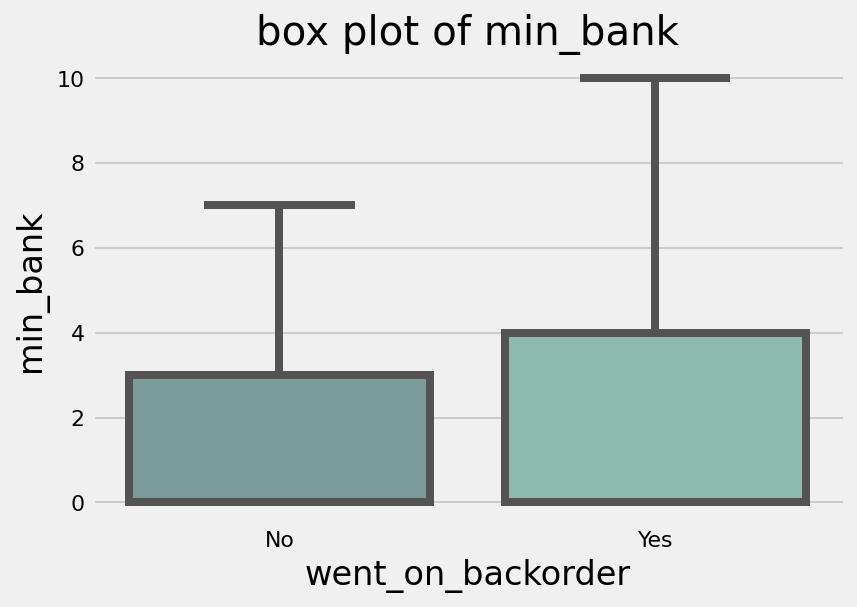

Text(0.5, 1.0, 'box plot of pieces_past_due')

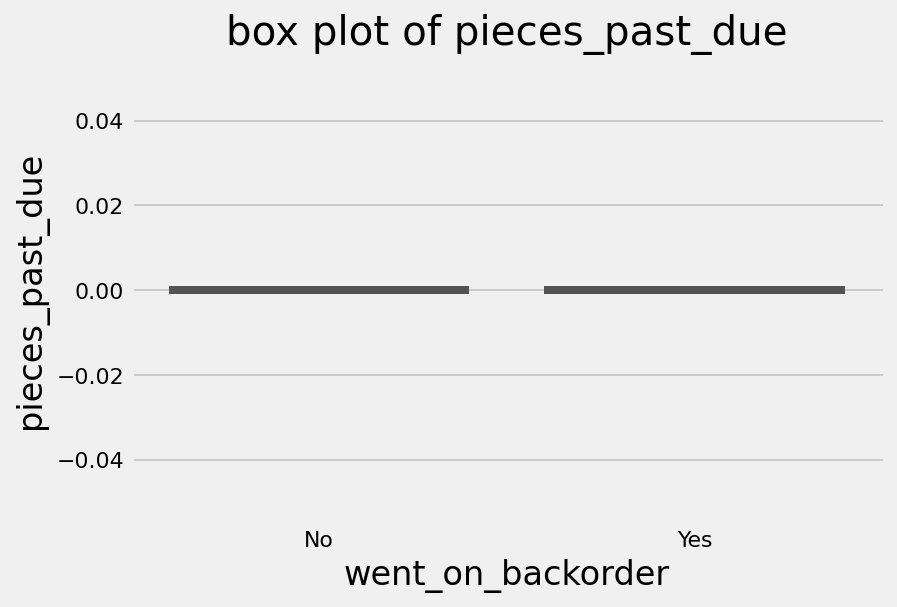

Text(0.5, 1.0, 'box plot of perf_6_month_avg')

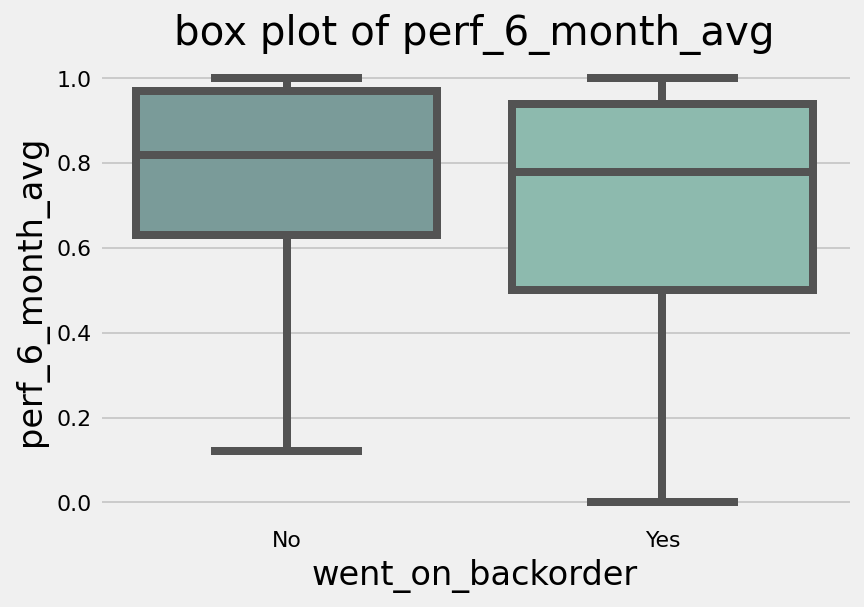

Text(0.5, 1.0, 'box plot of perf_12_month_avg')

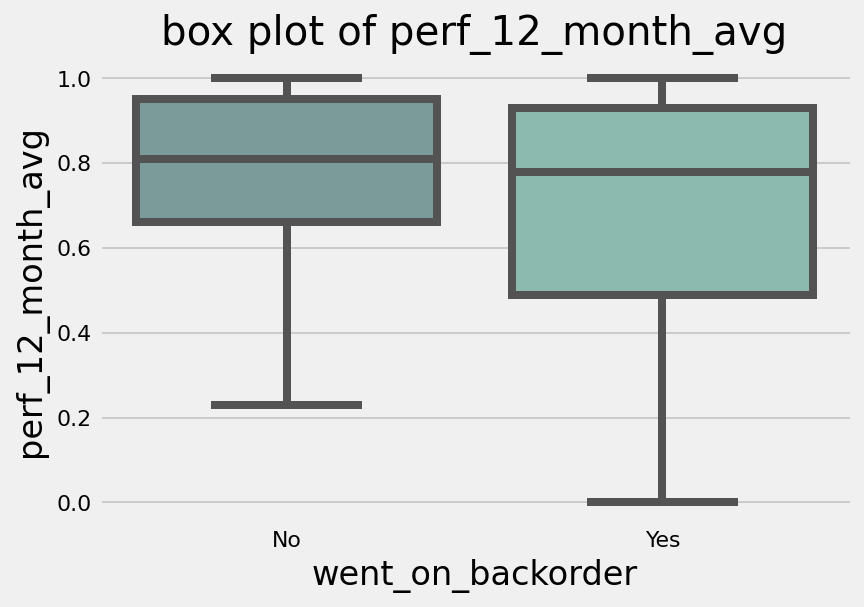

Text(0.5, 1.0, 'box plot of local_bo_qty')

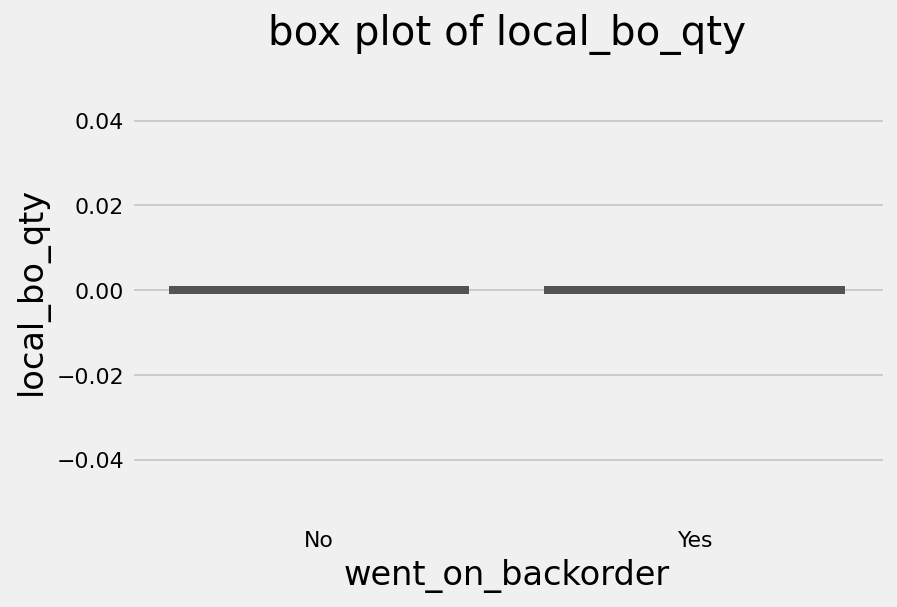

In [ ]:
for i in range(len(quantvars)):
  sns.boxplot(x = 'went_on_backorder', y = quantvars[i], data = data,showfliers=False)
  plt.title('box plot of '+quantvars[i])
  plt.show()



1. All the quant variables have extreme values so i plotted without outliers
2. Whenever there is less inventory, the product is going into backorder
2. Its the same case for lead_time
2. There are many outliers present in the data(i have taken it off).
2. in_transit_qty,pieces_past_due,local_bo_qty almost have zero as their values
2. The box plot for perf_x_months and sales_6/9_months are similar
2. The Data is highly positively skewed.




Text(0.5, 1.0, 'Histogram plot of perf_6_month_avg')

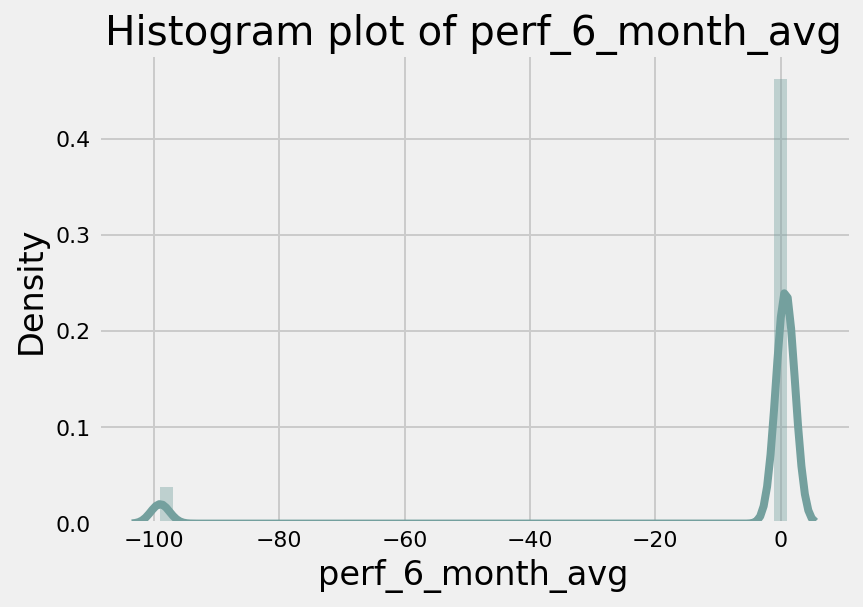

Text(0.5, 1.0, 'Histogram plot of perf_12_month_avg')

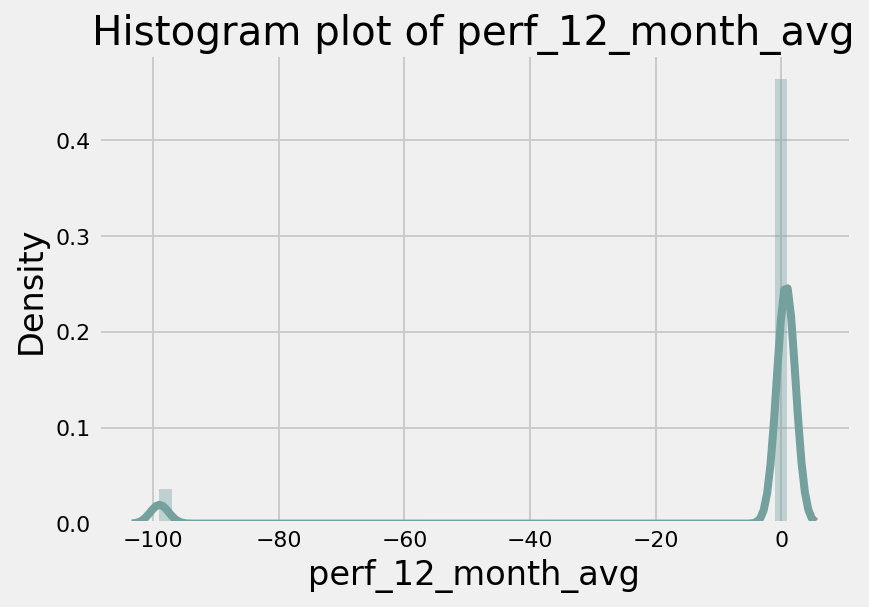

In [ ]:
for i in quantvars[12:14]:
  sns.distplot(data[i],kde = True)
  plt.title('Histogram plot of '+i)
  plt.show()





*  Both the plots look similar and are skewed 





Text(0.5, 1.0, 'Histogram plot of forecast_3_month')

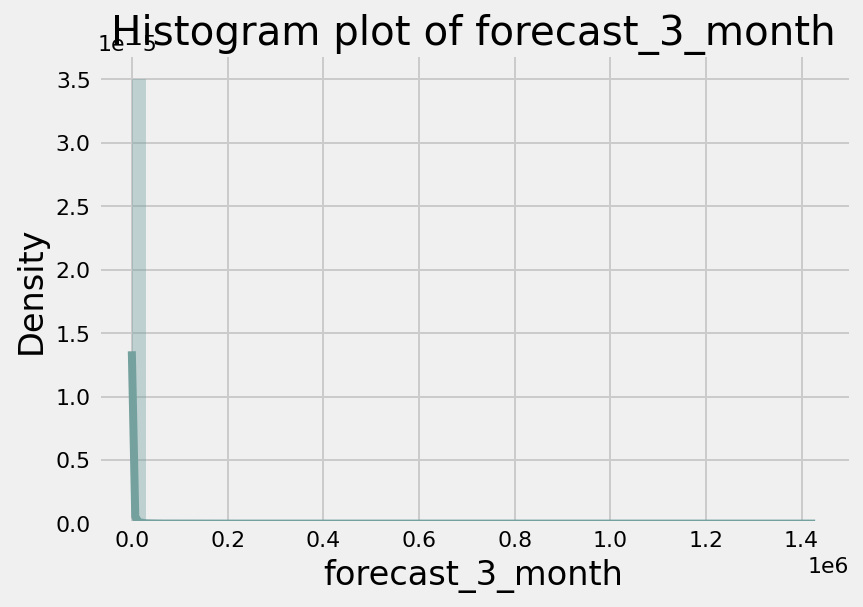

Text(0.5, 1.0, 'Histogram plot of forecast_6_month')

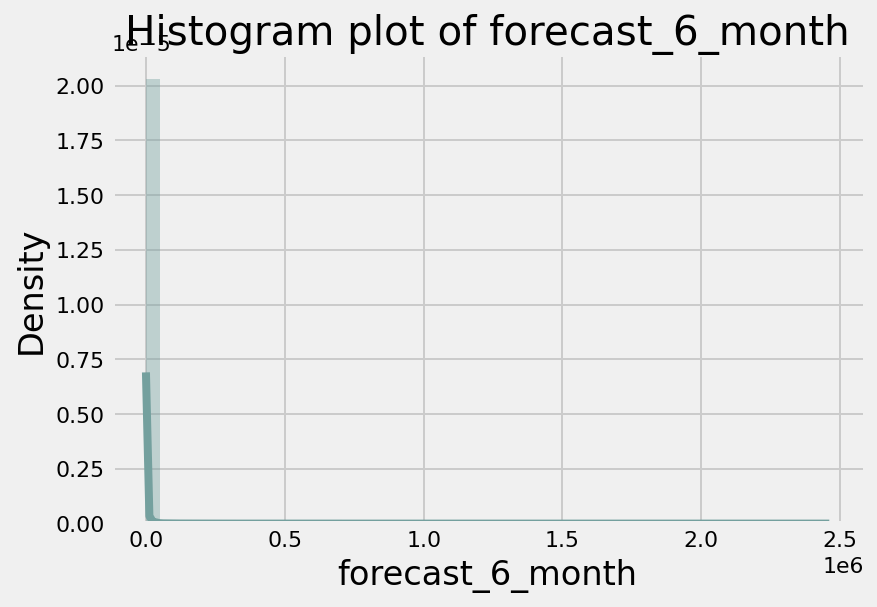

Text(0.5, 1.0, 'Histogram plot of forecast_9_month')

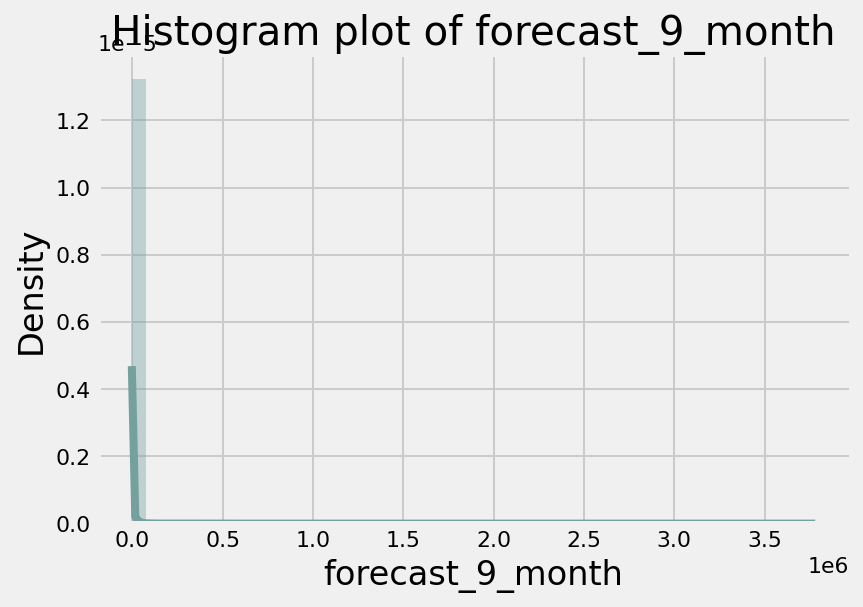

In [ ]:
for i in quantvars[3:6]:
  sns.distplot(data[i],kde = True)
  plt.title('Histogram plot of '+i)
  plt.show()


Text(0.5, 1.0, 'Histogram plot of sales_1_month')

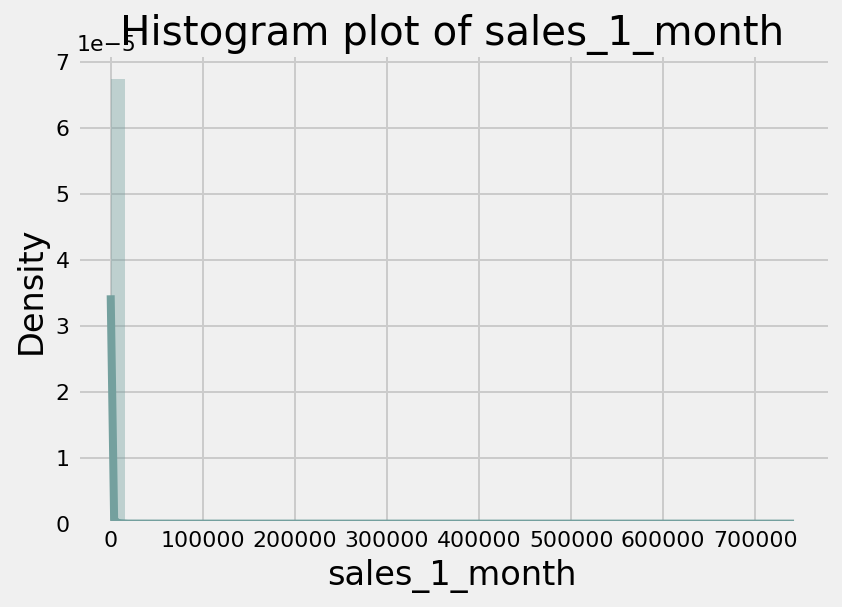

Text(0.5, 1.0, 'Histogram plot of sales_3_month')

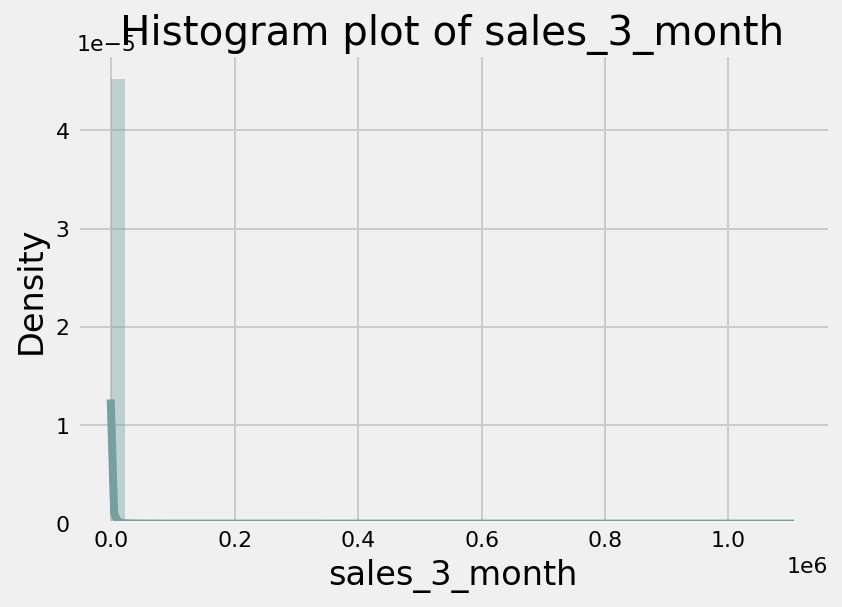

Text(0.5, 1.0, 'Histogram plot of sales_6_month')

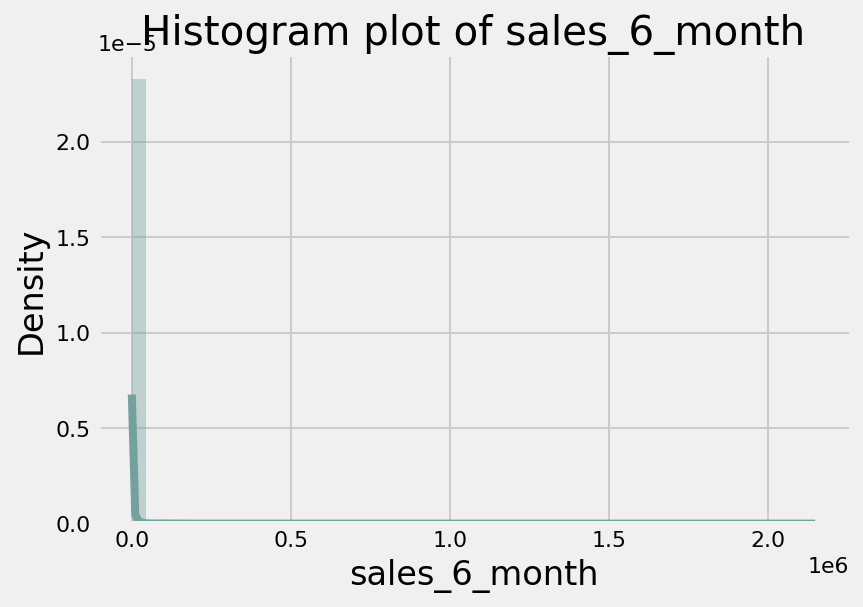

Text(0.5, 1.0, 'Histogram plot of sales_9_month')

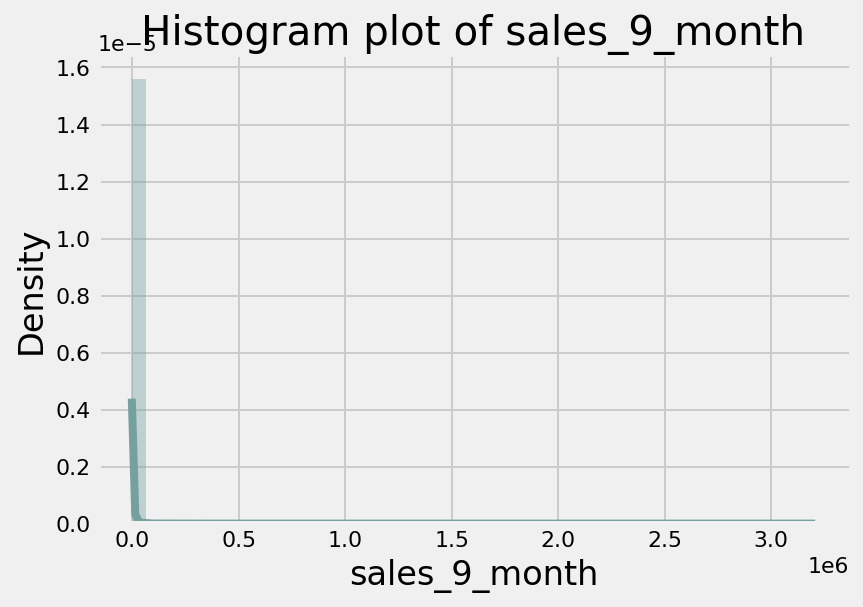

Text(0.5, 1.0, 'Histogram plot of min_bank')

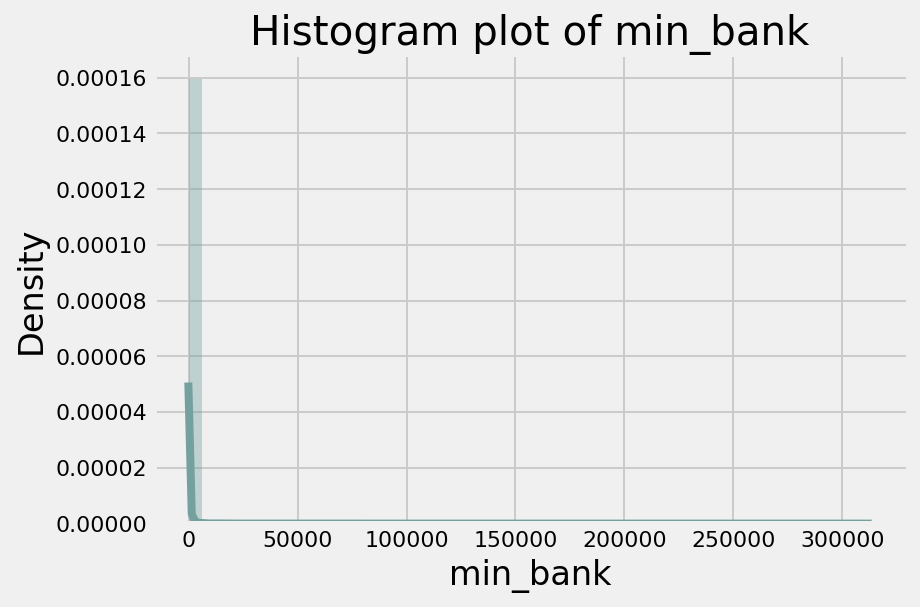

In [ ]:
for i in quantvars[6:11]:
  sns.distplot(data[i],kde = True)
  plt.title('Histogram plot of '+i)
  plt.show()




*  The above plots dont give a clear idea of shape of the data but might be positively skewed.
*  Most of the values are near zero



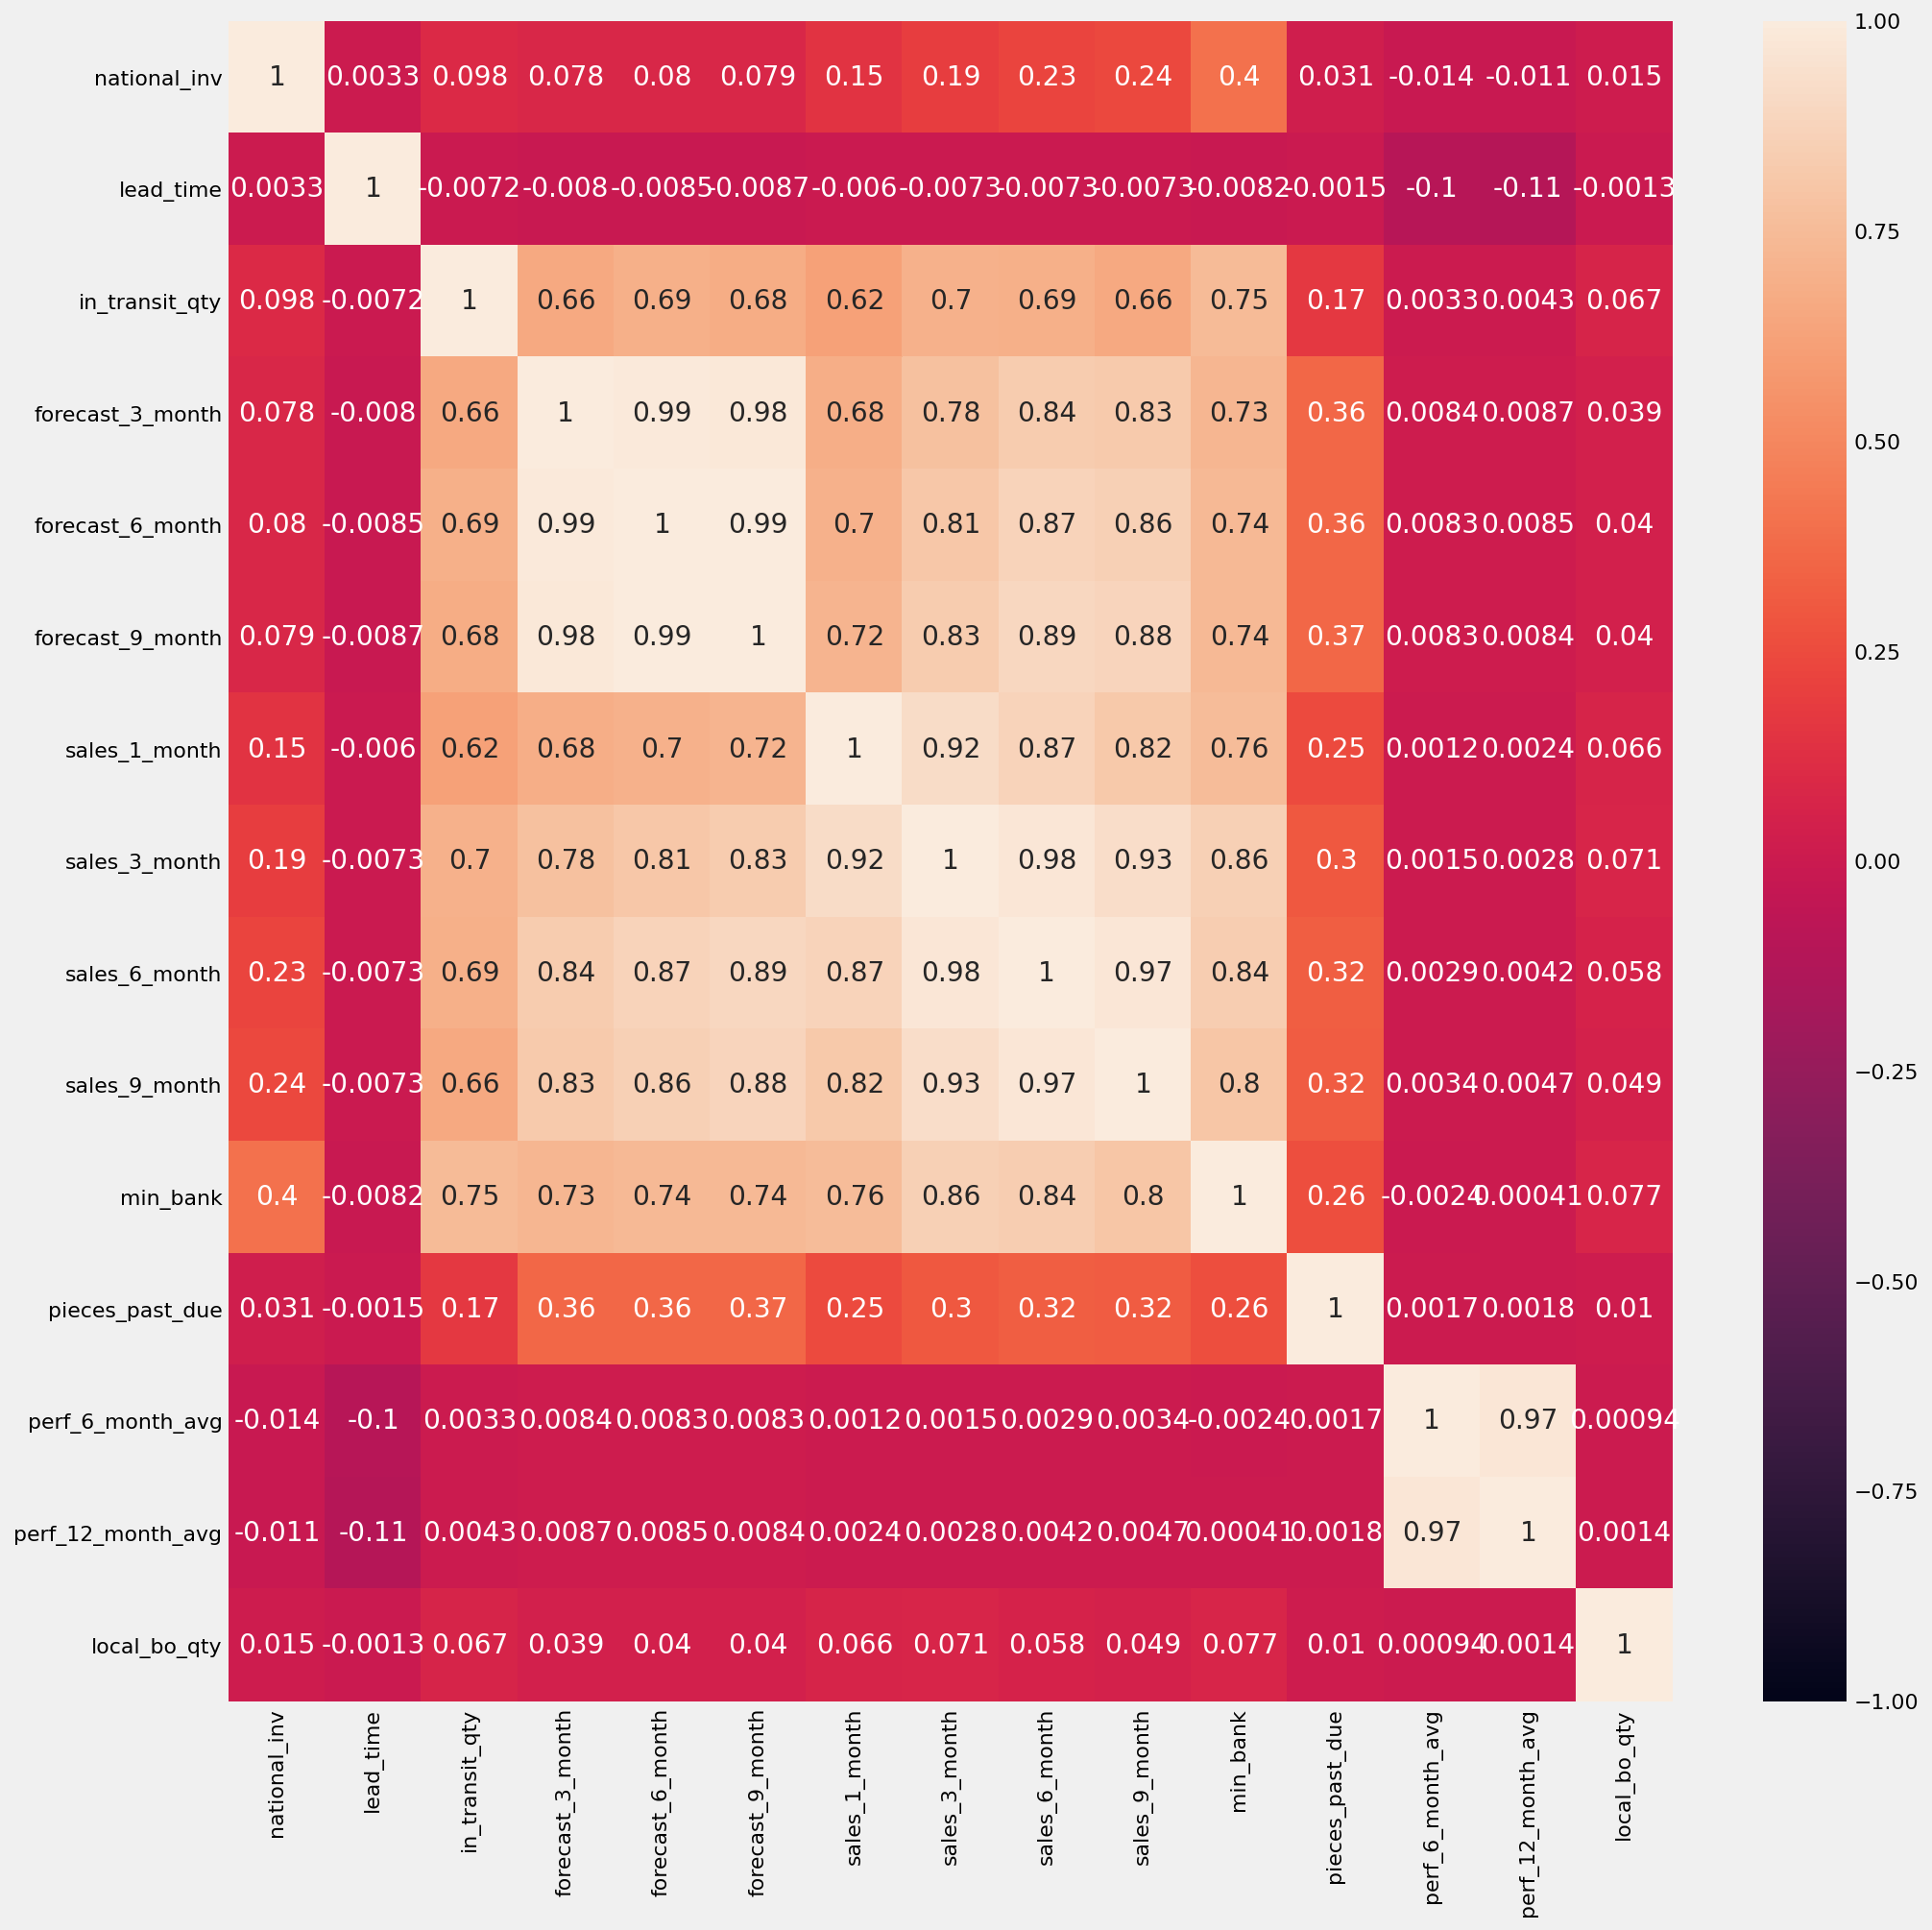

In [ ]:
fig, ax = plt.subplots(figsize=(15,15)) 
data_corr=data.corr()
sns.heatmap(data_corr, xticklabels=data_corr.columns,
        yticklabels=data_corr.columns,ax=ax,vmin=-1, vmax=1, annot=True)




*   forecast_3/6/9_month are highly correlated with eachother
*   sales_1/3/6/9_ are highly correlated with each other
*   forecast and sales columns are correlated.
*   perf_6/12_month_avg are highly correlated with each other
*   min_bank and sales_3/6/9_month are higly correlated
*   min_bank also has good correlation with forecast columns
*   in_transit is correlated to min_bank and moderately correlated to forecast  and sales
  
   




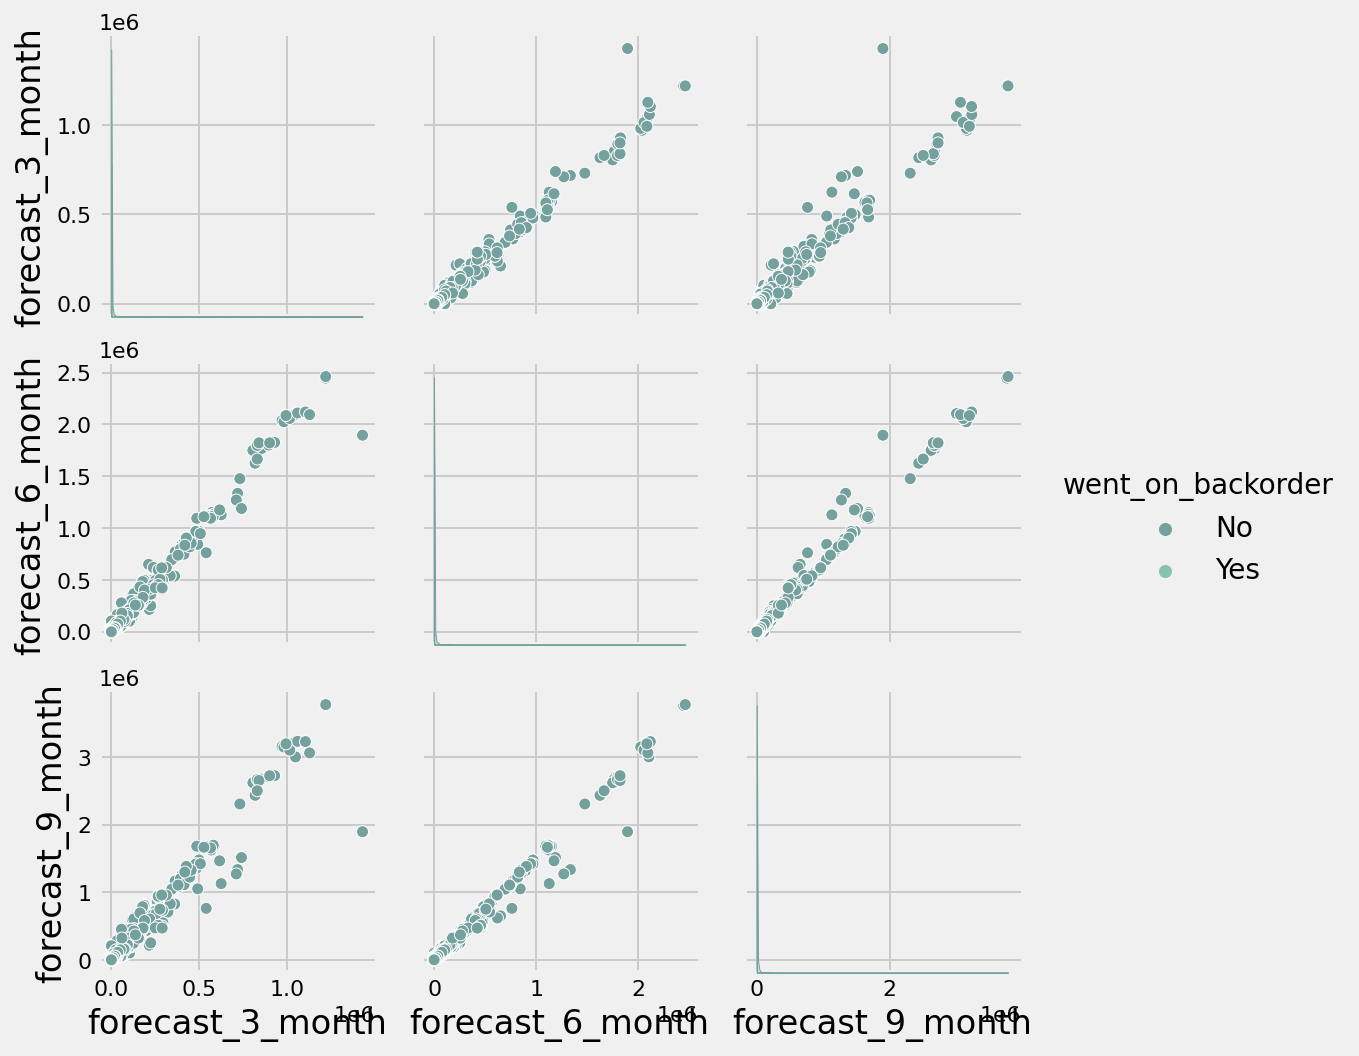

In [ ]:
sns.pairplot(data=data,vars=['forecast_3_month','forecast_6_month', 'forecast_9_month'], hue='went_on_backorder', dropna=True)
plt.show()



*   There is a clear relationship between these forecasts and i believe only of these features is enough
*   The backorder occurs when the forecast is low



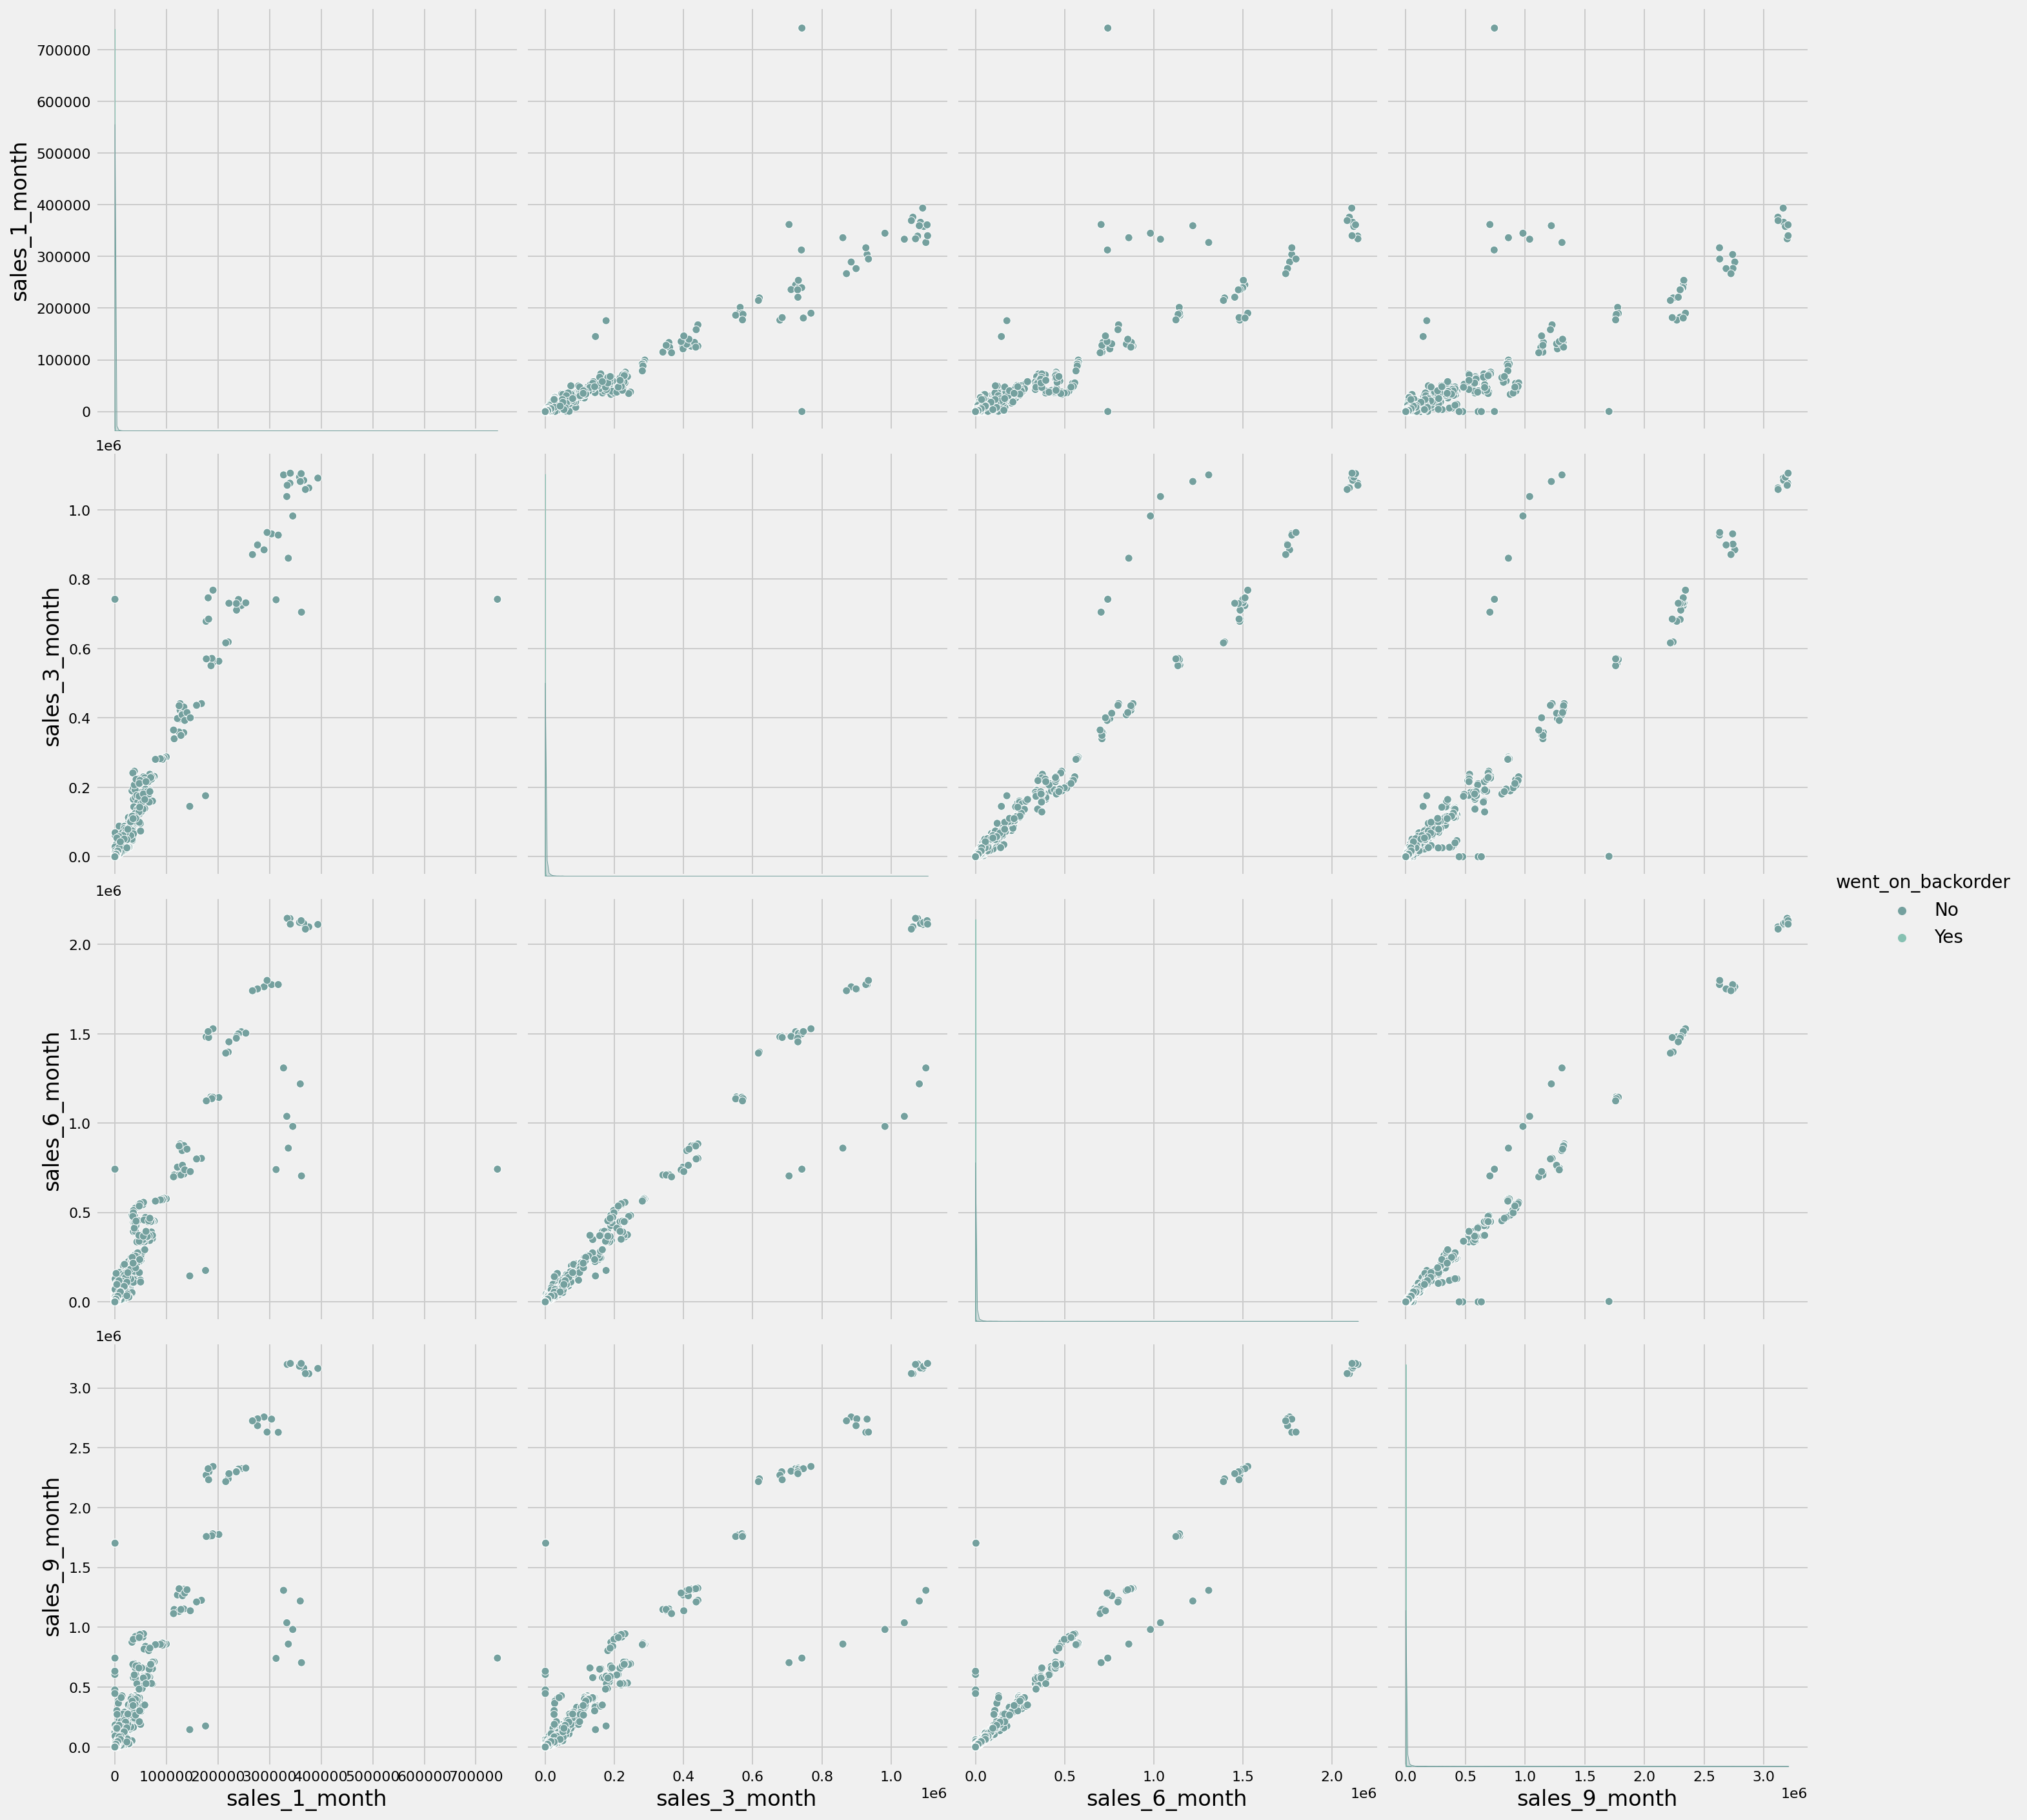

In [ ]:

sns.pairplot(data=data,vars=['sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month'],  hue='went_on_backorder',size=5,dropna=True)
plt.show()



*   sales_3/6/9_month form almost a perfect linear relationship. There are lot of outliers in the data so disregarding them they form a perfect linear relationship. So one of the feature is sufficient  
*   When sales are low there is a chance of backorder



In [ ]:
notbo = data.loc[data['went_on_backorder'] == 'No']       
isbo = data.loc[data['went_on_backorder'] == 'Yes']

Text(0.5, 1.0, 'Scatter plot between forecast and sales')

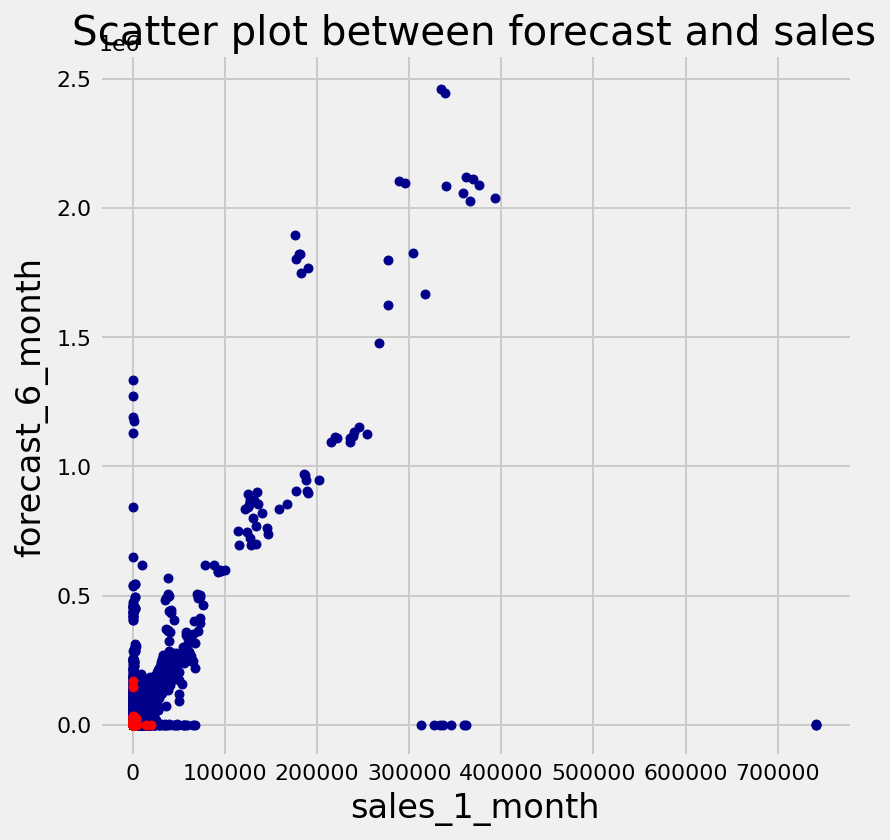

Text(0.5, 1.0, 'Scatter plot between forecast and sales')

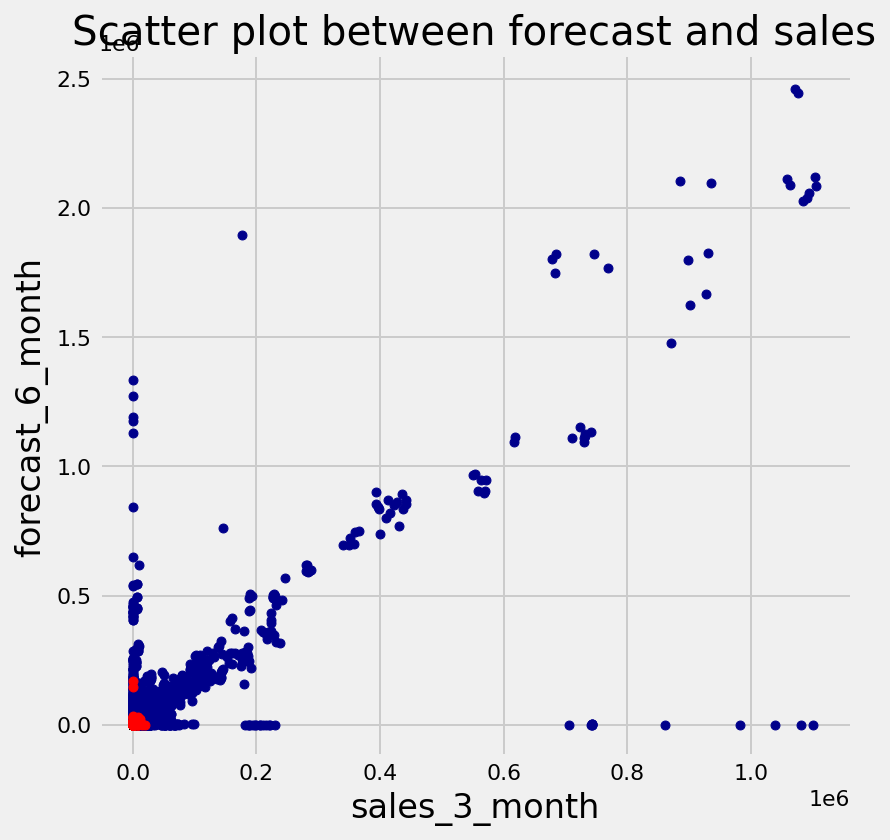

Text(0.5, 1.0, 'Scatter plot between forecast and sales')

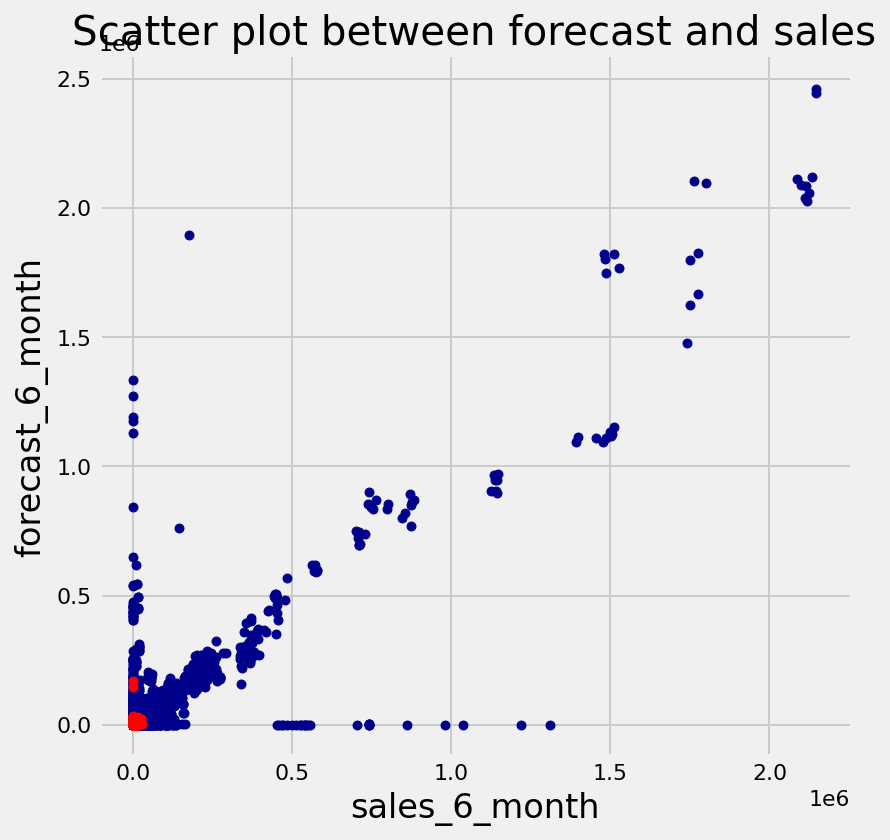

Text(0.5, 1.0, 'Scatter plot between forecast and sales')

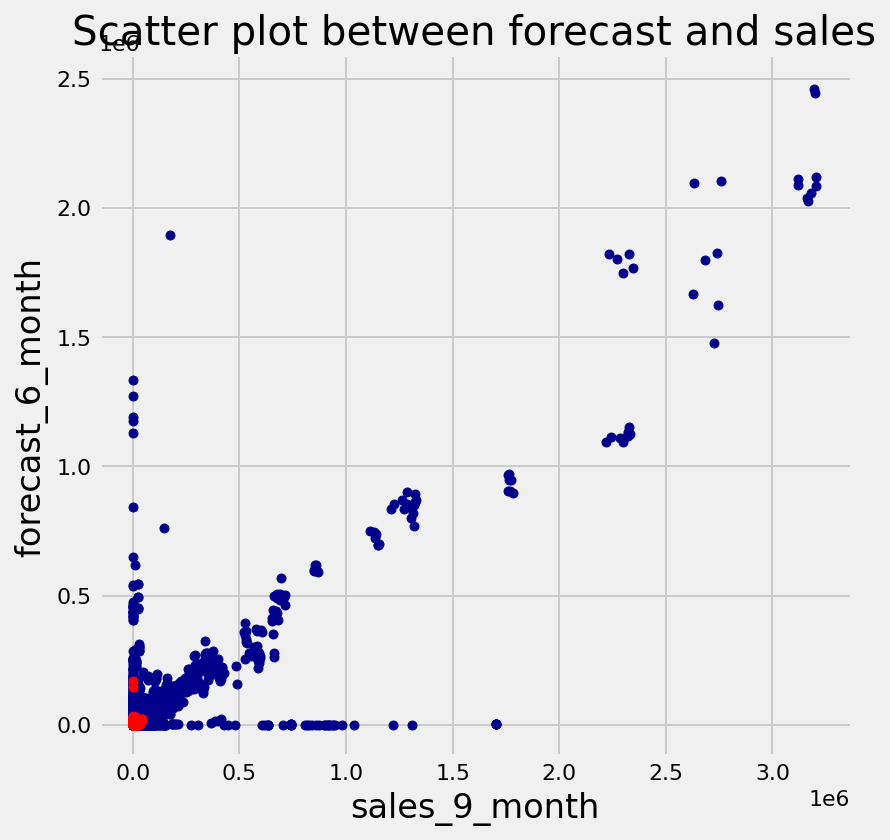

In [ ]:
sales=['sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month']

for sale in sales:
  
  plt.close('all')
  fig = plt.figure(figsize=(6, 6))
  ax = fig.gca()
  notbo.plot(kind='scatter', x=sale, y='forecast_6_month', ax=ax, color='DarkBlue')
  isbo.plot(kind='scatter', x=sale, y='forecast_6_month', ax=ax, color='Red')
  plt.title('Scatter plot between forecast and sales')
  plt.show()





*   There is linear relationship between them.
*   correlation occurs when forecast and sales are low which is a logical explanation 



Text(0.5, 1.0, 'Scatter plot between perf_6_month_avg and perf_12_month_avg ')

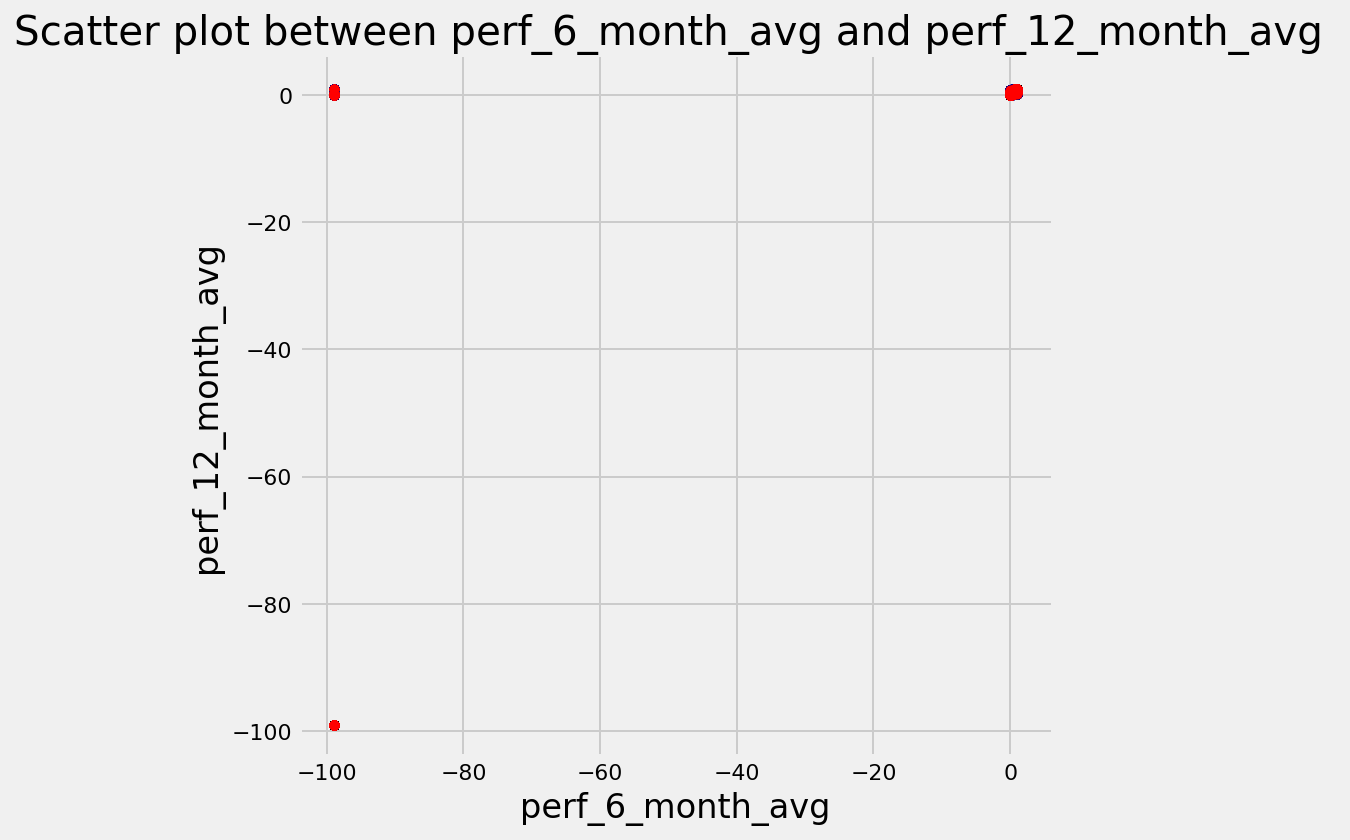

In [ ]:
#sns.scatterplot(data=data, x="perf_6_month_avg", y="perf_12_month_avg", hue="went_on_backorder", style="went_on_backorder")
fig = plt.figure(figsize=(6,6))
ax = fig.gca()
notbo.plot(kind='scatter', x="perf_6_month_avg", y='perf_12_month_avg', ax=ax, color='DarkBlue')
isbo.plot(kind='scatter', x="perf_6_month_avg", y='perf_12_month_avg', ax=ax, color='Red')
plt.title('Scatter plot between perf_6_month_avg and perf_12_month_avg ')
plt.show()




*  Perf_12_month_avg and aPerf_6_month_avg are highly correlated in the heatmap but the above graph is not showing any linear relationship



Text(0.5, 1.0, 'Scatter plot between min_bank and sales')

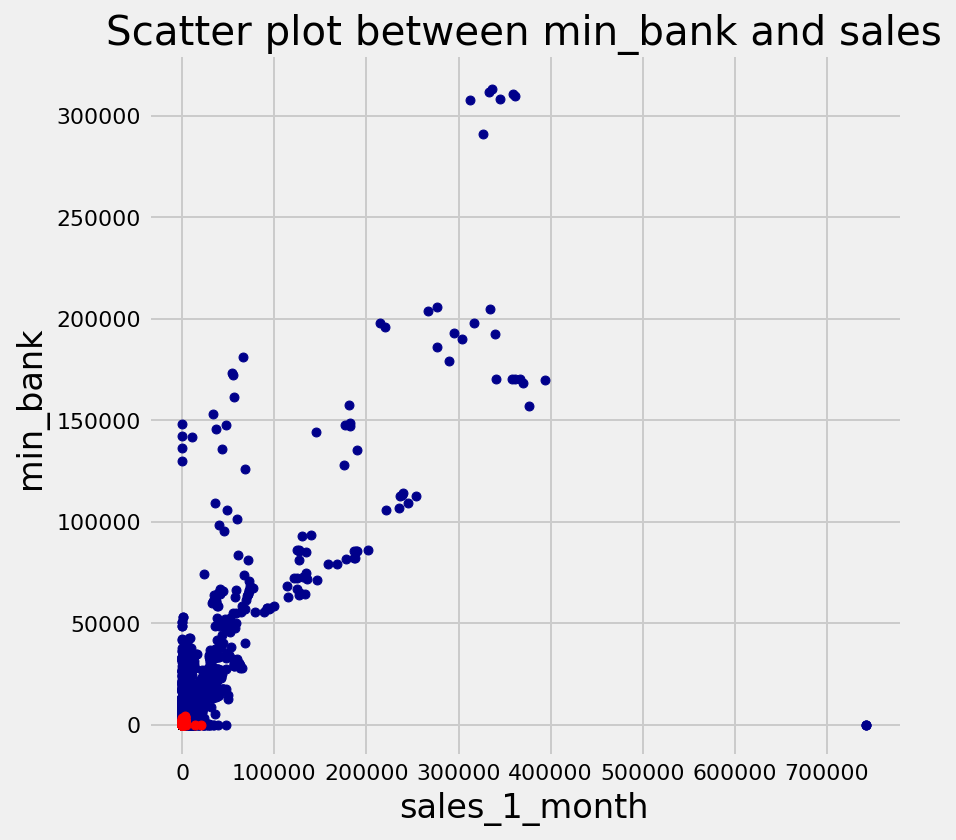

Text(0.5, 1.0, 'Scatter plot between min_bank and sales')

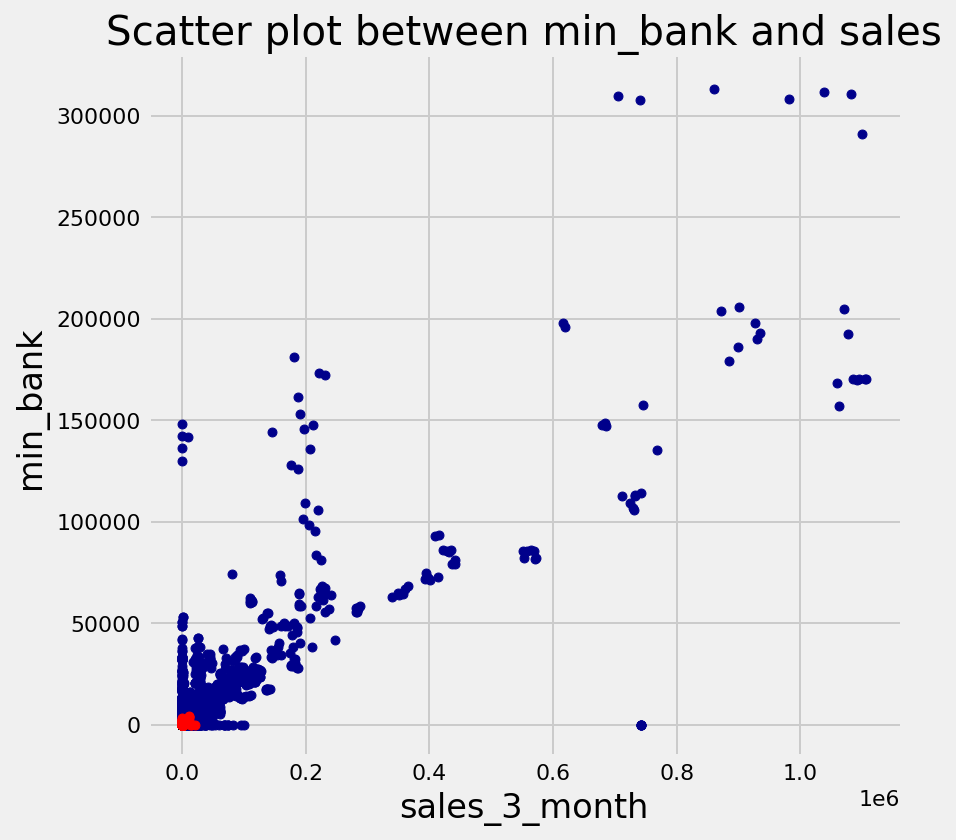

Text(0.5, 1.0, 'Scatter plot between min_bank and sales')

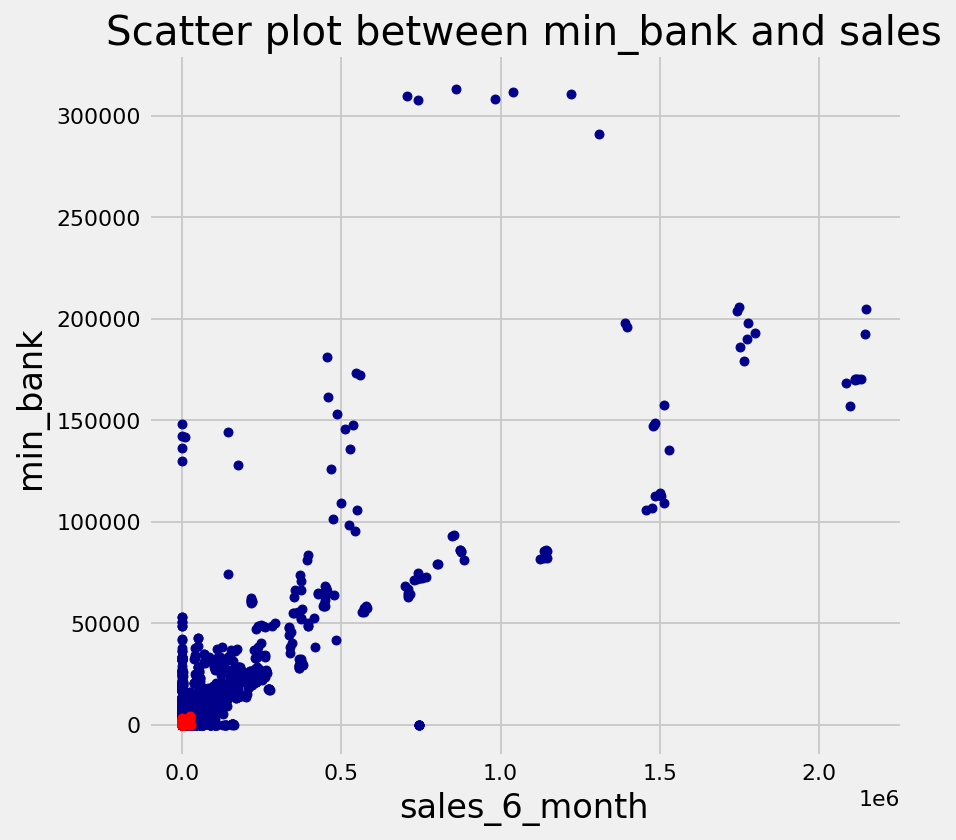

Text(0.5, 1.0, 'Scatter plot between min_bank and sales')

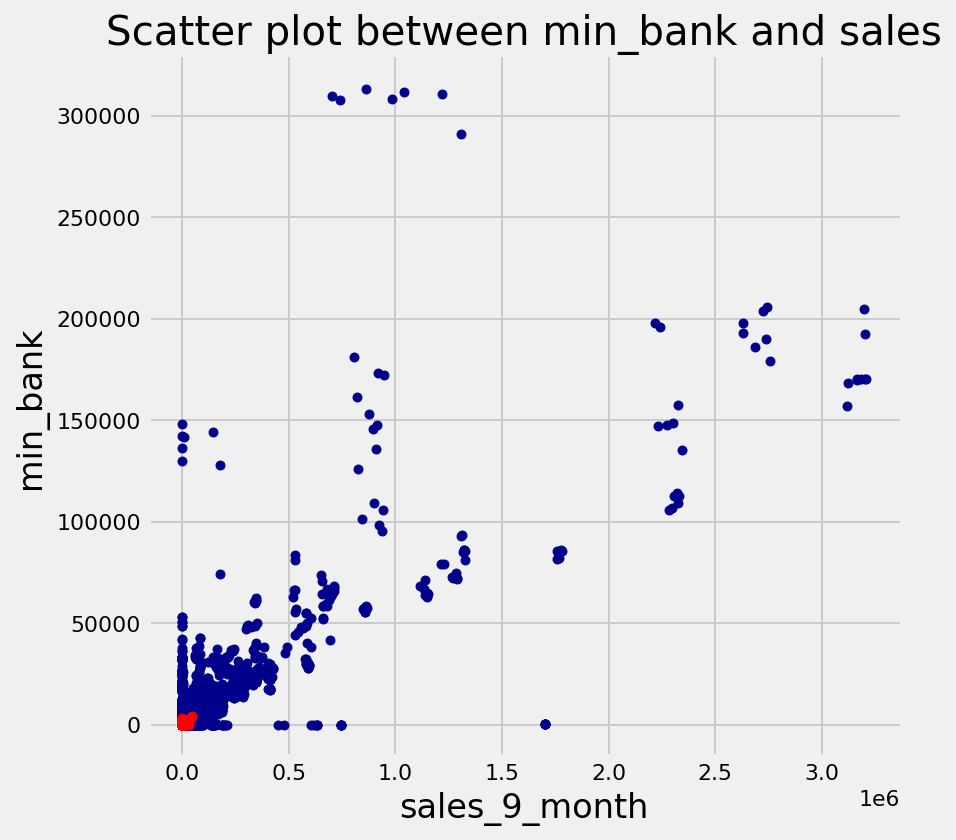

In [ ]:
for sale in sales:
  
  plt.close('all')
  fig = plt.figure(figsize=(6, 6))
  ax = fig.gca()
  notbo.plot(kind='scatter', x=sale, y='min_bank', ax=ax, color='DarkBlue')
  isbo.plot(kind='scatter', x=sale, y='min_bank', ax=ax, color='Red')
  plt.title('Scatter plot between min_bank and sales')
  plt.show()





*   There is a linear relationship between them as expected
*   Backorder occur when min bank and sales are low



Text(0.5, 1.0, 'Scatter plot between min_bank and forecasts')

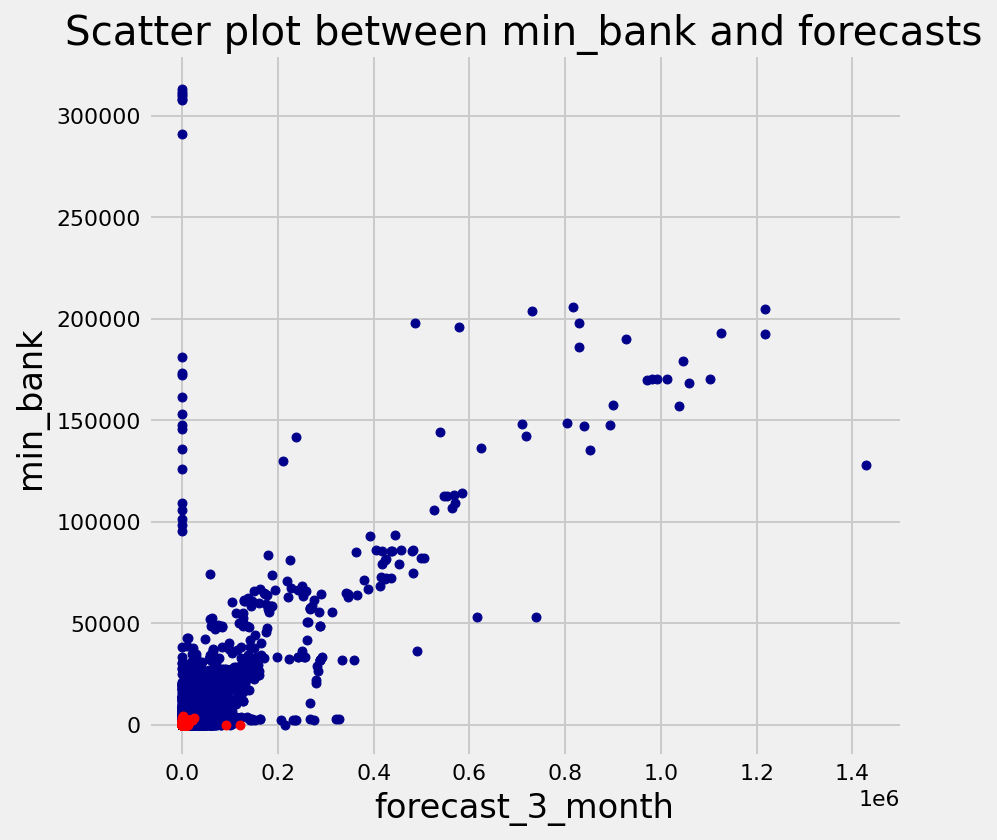

Text(0.5, 1.0, 'Scatter plot between min_bank and forecasts')

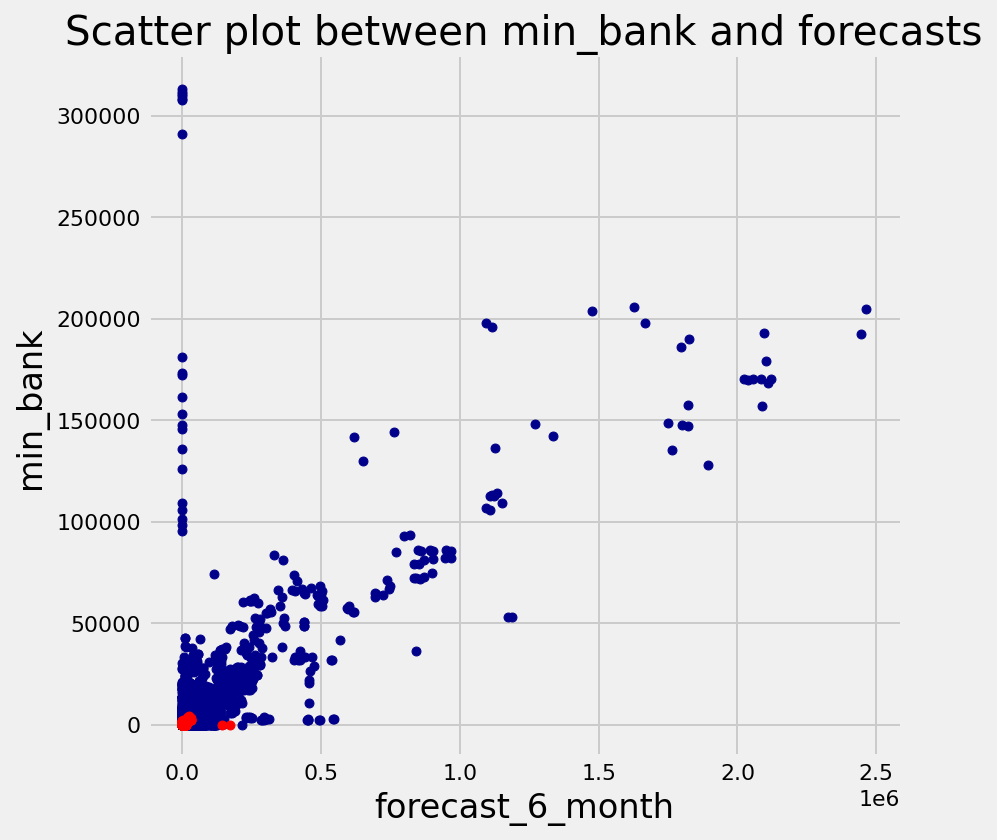

Text(0.5, 1.0, 'Scatter plot between min_bank and forecasts')

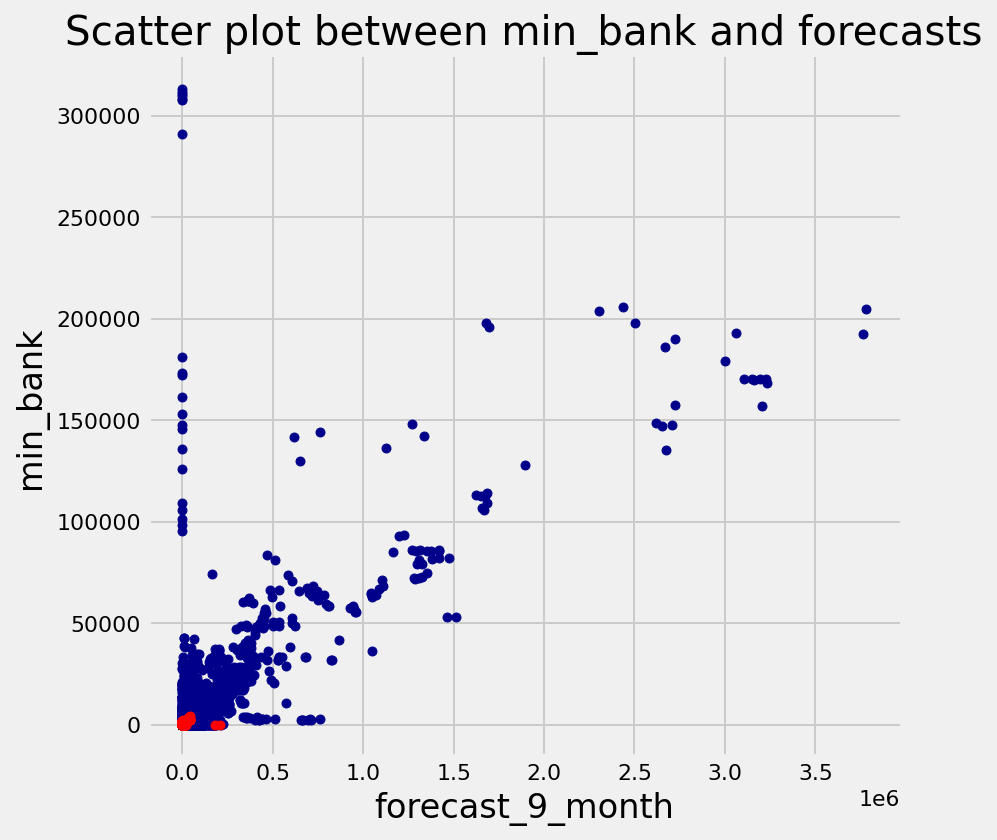

In [ ]:
forecasts=['forecast_3_month','forecast_6_month', 'forecast_9_month']
for forecast in forecasts:
  plt.close('all')
  fig = plt.figure(figsize=(6, 6))
  ax = fig.gca()
  notbo.plot(kind='scatter', x=forecast, y='min_bank', ax=ax, color='DarkBlue')
  isbo.plot(kind='scatter', x=forecast, y='min_bank', ax=ax, color='Red')
  plt.title('Scatter plot between min_bank and forecasts')
  plt.show()




*   There is a linear relationship between them 
*   Backorder occur when min bank and forecasts are low



Text(0.5, 1.0, 'Scatter plot between min_bank and in_transit_qty ')

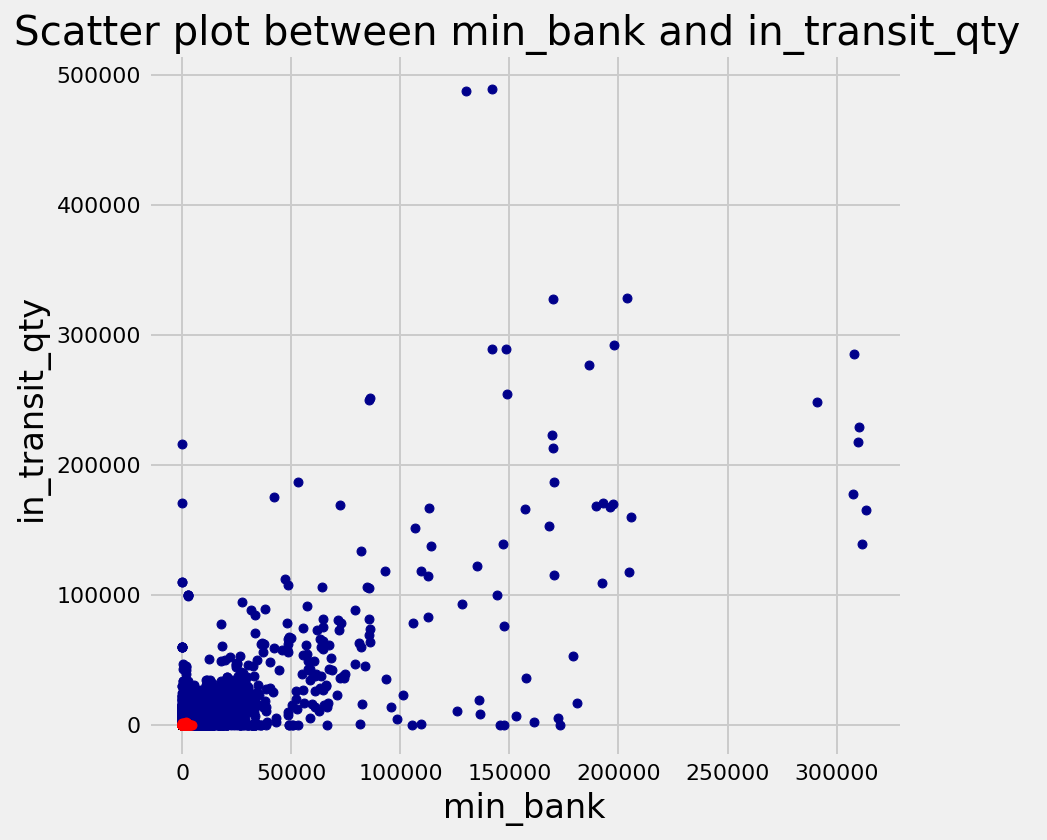

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca()
notbo.plot(kind='scatter', x="min_bank", y='in_transit_qty', ax=ax, color='DarkBlue')
isbo.plot(kind='scatter', x="min_bank", y='in_transit_qty', ax=ax, color='Red')
plt.title('Scatter plot between min_bank and in_transit_qty ')
plt.show()



*   Linear relationship exists between them
*   Backorder occurs when min_bank and in_transit_qty are low 



Now we have clean data 

In [ ]:
X_trainn=data.drop(['went_on_backorder','sku'],axis=1)

In [ ]:
X_trainn

national_inv  lead_time  in_transit_qty  forecast_3_month  \
0                 0.0        8.0             0.0               0.0   
1                 2.0        9.0             0.0               0.0   
2                 2.0        8.0             0.0               0.0   
3                 7.0        8.0             0.0               0.0   
4                 8.0        8.0             0.0               0.0   
...               ...        ...             ...               ...   
1687855           0.0        2.0             0.0              10.0   
1687856          -1.0        8.0             0.0               5.0   
1687857          -1.0        9.0             0.0               7.0   
1687858          62.0        9.0            16.0              39.0   
1687859          19.0        4.0             0.0               0.0   

         forecast_6_month  forecast_9_month  sales_1_month  sales_3_month  \
0                     0.0               0.0            0.0            0.0   
1                     0.0               0.0            0.0            0.0   
2                     0.0               0.0            0.0            0.0   
3                     0.0               0.0            0.0            0.0   
4                     0.0               0.0            0.0            0.0   
...                   ...               ...            ...            ...   
1687855              10.0              10.0            0.0            5.0   
1687856               7.0               9.0            1.0            3.0   
1687857               9.0              11.0            0.0            8.0   
1687858              87.0             126.0           35.0           63.0   
1687859               0.0               0.0            2.0            7.0   

         sales_6_month  sales_9_month  min_bank  potential_issue  \
0                  0.0            0.0       0.0                0   
1                  0.0            0.0       0.0                0   
2                  0.0            0.0       0.0                0   
3                  0.0            0.0       1.0                0   
4                  0.0            4.0       2.0                0   
...                ...            ...       ...              ...   
1687855            7.0            7.0       0.0                0   
1687856            3.0            8.0       0.0                0   
1687857           11.0           12.0       0.0                0   
1687858          153.0          205.0      12.0                0   
1687859           12.0           20.0       1.0                0   

         pieces_past_due  perf_6_month_avg  perf_12_month_avg  local_bo_qty  \
0                    0.0              0.85               0.83           0.0   
1                    0.0              0.99               0.99           0.0   
2                    0.0              0.85               0.83           0.0   
3                    0.0              0.10               0.13           0.0   
4                    0.0              0.85               0.83           0.0   
...                  ...               ...                ...           ...   
1687855              0.0              0.69               0.69           5.0   
1687856              0.0              0.85               0.83           1.0   
1687857              0.0              0.86               0.84           1.0   
1687858              0.0              0.86               0.84           6.0   
1687859              0.0              0.73               0.78           1.0   

         deck_risk  oe_constraint  ppap_risk  stop_auto_buy  rev_stop  
0                0              0          0              1         0  
1                0              0          0              1         0  
2                1              0          0              1         0  
3                0              0          0              1         0  
4                1              0          0              1         0  
...            ...            ...        ... 

In [ ]:
y=data['went_on_backorder']
y

0          0
1          0
2          0
3          0
4          0
          ..
1687855    0
1687856    0
1687857    1
1687858    0
1687859    0
Name: went_on_backorder, Length: 1687860, dtype: int64

In [ ]:
model = RandomForestClassifier()
model.fit(X_trainn, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

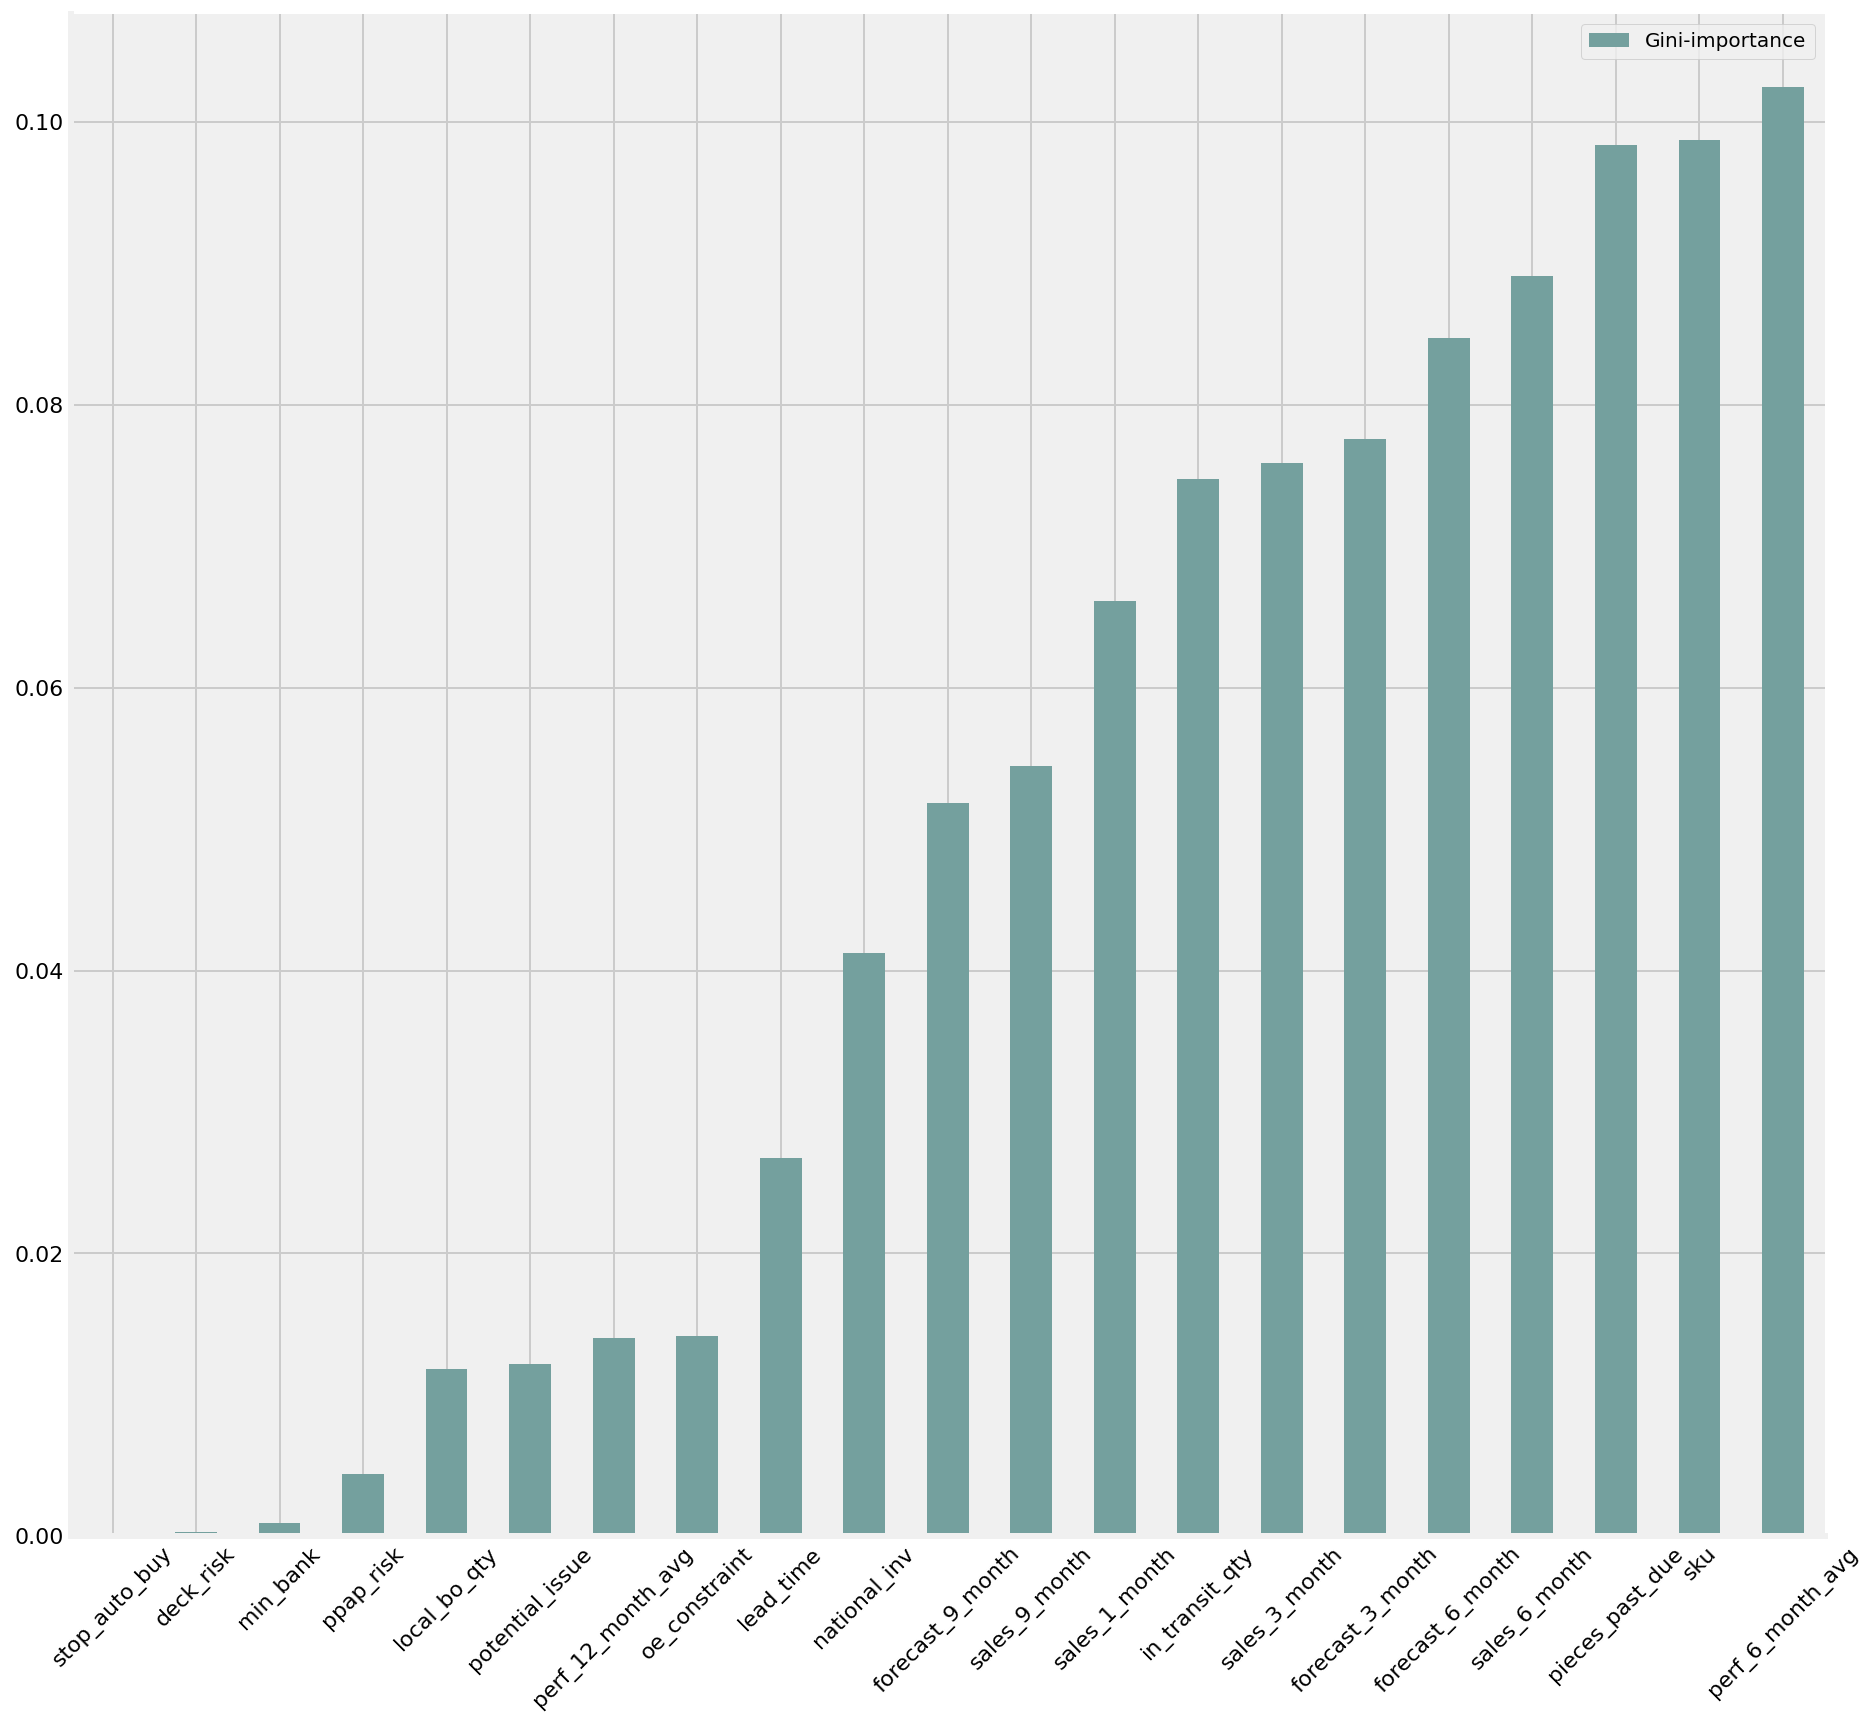

In [ ]:
fig = plt.figure(figsize=(14, 14))
ax = fig.gca()
feats = {}
for feature, importance in zip(data.columns, model.feature_importances_):
    feats[feature] = importance 
    

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45,ax=ax)


In [ ]:
importances.sort_values(by='Gini-importance',ascending=False)

Gini-importance
perf_6_month_avg          0.102489
sku                       0.098738
pieces_past_due           0.098358
sales_6_month             0.089072
forecast_6_month          0.084700
forecast_3_month          0.077614
sales_3_month             0.075895
in_transit_qty            0.074761
sales_1_month             0.066119
sales_9_month             0.054434
forecast_9_month          0.051858
national_inv              0.041252
lead_time                 0.026725
oe_constraint             0.014186
perf_12_month_avg         0.014025
potential_issue           0.012200
local_bo_qty              0.011855
ppap_risk                 0.004390
min_bank                  0.000976
deck_risk                 0.000296
stop_auto_buy             0.000059

In [4]:
feature=['perf_6_month_avg','pieces_past_due','sales_6_month','forecast_6_month','in_transit_qty','potential_issue','national_inv','lead_time','oe_constraint','min_bank','reorder_point','went_on_backorder']

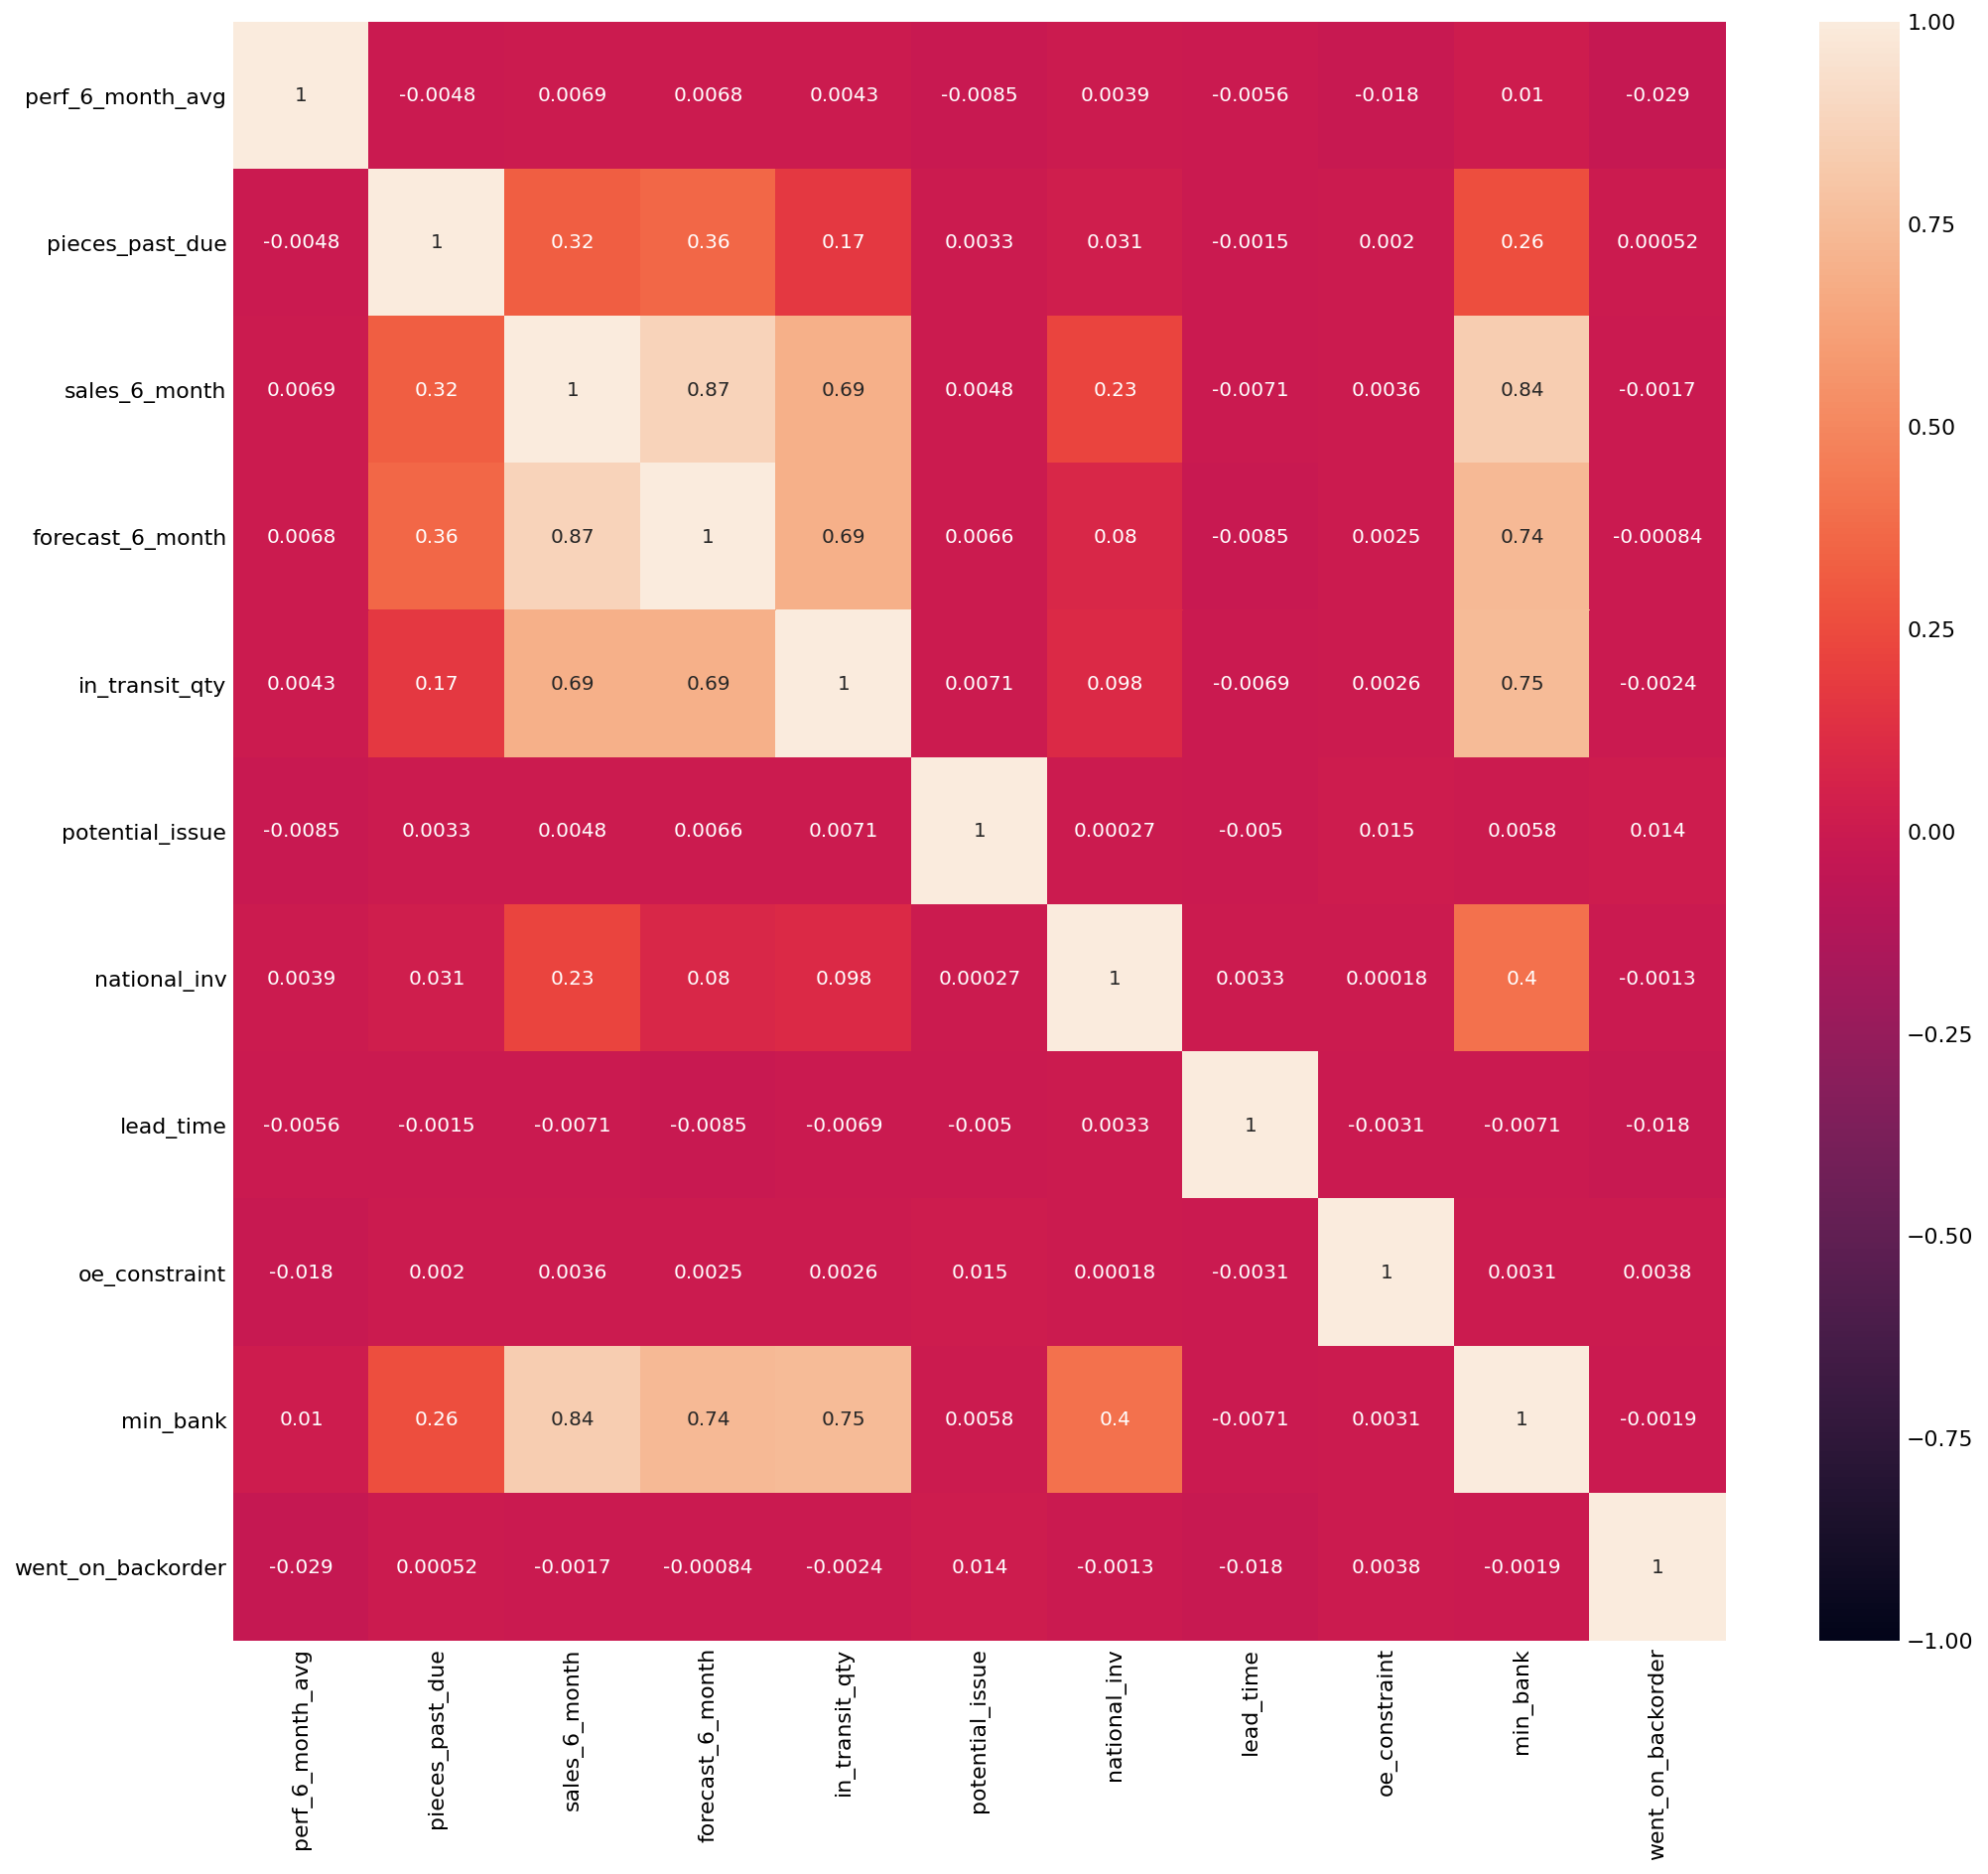

In [ ]:

fig, ax = plt.subplots(figsize=(15,15)) 
data_corr=data[feature].corr()
sns.heatmap(data_corr, xticklabels=data_corr.columns,
        yticklabels=data_corr.columns,ax=ax,vmin=-1, vmax=1, annot=True)

In [ ]:
print("The below features can be used for final analysis ")
for i in feature:t
  print(i)

The below features can be used for final analysis 
perf_6_month_avg
pieces_past_due
sales_6_month
forecast_6_month
in_transit_qty
potential_issue
national_inv
lead_time
oe_constraint
min_bank
went_on_backorder


In [ ]:
data.isin([-99]).any(axis=0)

sku                  False
national_inv          True
lead_time            False
in_transit_qty       False
forecast_3_month     False
forecast_6_month     False
forecast_9_month     False
sales_1_month        False
sales_3_month        False
sales_6_month        False
sales_9_month        False
min_bank             False
potential_issue      False
pieces_past_due      False
perf_6_month_avg      True
perf_12_month_avg     True
local_bo_qty         False
deck_risk            False
oe_constraint        False
ppap_risk            False
stop_auto_buy        False
rev_stop             False
went_on_backorder    False
dtype: bool

In [ ]:
inf=data[data.isin([-99]).any(axis=1)]

In [ ]:
notbo=inf.loc[inf['went_on_backorder']=='No']
isbo=inf.loc[inf['went_on_backorder']=='Yes']

In [ ]:
j=['national_inv','perf_6_month_avg','perf_12_month_avg']

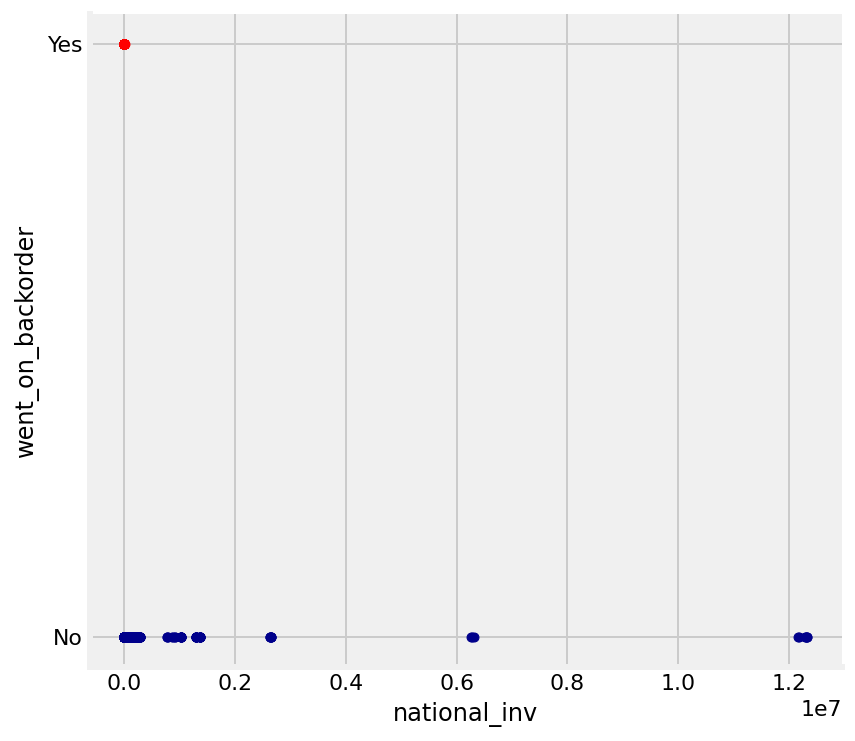

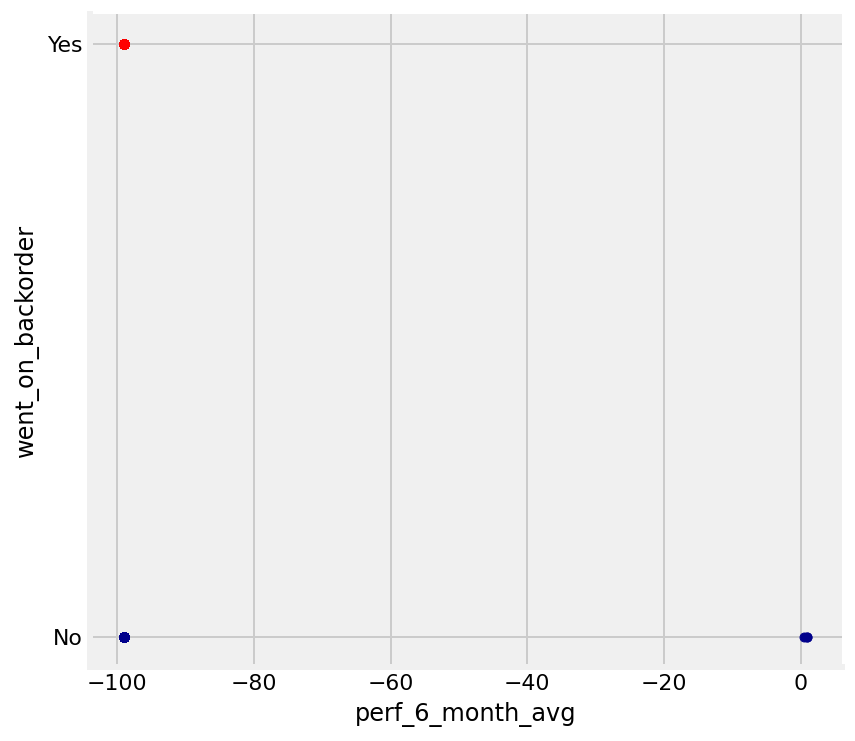

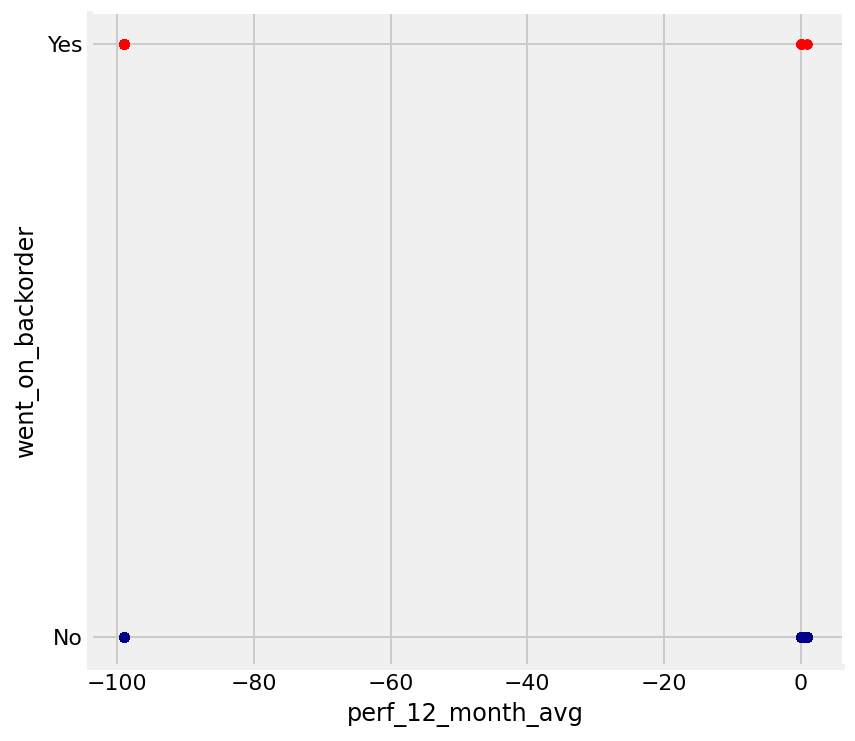

In [ ]:
for sale in j:
  
  plt.close('all')
  fig = plt.figure(figsize=(6, 6))
  ax = fig.gca()
  notbo.plot(kind='scatter', x=sale, y='went_on_backorder', ax=ax, color='DarkBlue')
  isbo.plot(kind='scatter', x=sale, y='went_on_backorder', ax=ax, color='Red')
  plt.show()



In [ ]:
stratified_sample, _ = train_test_split(data, test_size=0.7, stratify=data['went_on_backorder'])

In [ ]:
%%time
data_embedded = TSNE(n_components=2).fit_transform(stratified_sample[quantvars])

Feature Engineering 

In [8]:
#dropping last column
data = data[:-1]

#replacing No/Yes to 0/1
data=data.replace({'No': 0, 'Yes': 1})
#replacing infinity values to Nan
data['perf_6_month_avg']=data['perf_6_month_avg'].replace(-99, np.NaN)
data['perf_12_month_avg']=data['perf_12_month_avg'].replace(-99, np.NaN)
#filling Nan values with column median
data[data.columns] = data[data.columns].apply(pd.to_numeric, errors='coerce')
data = data.fillna(data.median())
#changing datatypes to int
data[categorical_list]=data[categorical_list].astype('int64')
data['reorder_point']=((data['sales_3_month']/3)*data['lead_time'])+data['national_inv']
data.head()

sku  national_inv  lead_time  in_transit_qty  forecast_3_month  \
0  1026827           0.0        8.0             0.0               0.0   
1  1043384           2.0        9.0             0.0               0.0   
2  1043696           2.0        8.0             0.0               0.0   
3  1043852           7.0        8.0             0.0               0.0   
4  1044048           8.0        8.0             0.0               0.0   

   forecast_6_month  forecast_9_month  sales_1_month  sales_3_month  \
0               0.0               0.0            0.0            0.0   
1               0.0               0.0            0.0            0.0   
2               0.0               0.0            0.0            0.0   
3               0.0               0.0            0.0            0.0   
4               0.0               0.0            0.0            0.0   

   sales_6_month  sales_9_month  min_bank  potential_issue  pieces_past_due  \
0            0.0            0.0       0.0                0              0.0   
1            0.0            0.0       0.0                0              0.0   
2            0.0            0.0       0.0                0              0.0   
3            0.0            0.0       1.0                0              0.0   
4            0.0            4.0       2.0                0              0.0   

   perf_6_month_avg  perf_12_month_avg  local_bo_qty  deck_risk  \
0              0.85               0.83           0.0          0   
1              0.99               0.99           0.0          0   
2              0.85               0.83           0.0          1   
3              0.10               0.13           0.0          0   
4              0.85               0.83           0.0          1   

   oe_constraint  ppap_risk  stop_auto_buy  rev_stop  went_on_backorder  \
0              0          0              1         0                  0   
1              0          0              1         0                  0   
2              0          0              1         0                  0   
3              0          0              1         0                  0   
4              0          0              1         0                  0   

   reorder_point  
0            0.0  
1            2.0  
2            2.0  
3            7.0  
4            8.0

In [9]:
X,y=data[feature].drop('went_on_backorder',axis=1),data[feature]['went_on_backorder']


In [10]:
#dropping last column
test_data = test_data[:-1]

#replacing No/Yes to 0/1
test_data=test_data.replace({'No': 0, 'Yes': 1})
#replacing infinity values to Nan
test_data['perf_6_month_avg']=test_data['perf_6_month_avg'].replace(-99, np.NaN)
test_data['perf_12_month_avg']=test_data['perf_12_month_avg'].replace(-99, np.NaN)
#filling Nan values with column median
test_data[test_data.columns] = test_data[test_data.columns].apply(pd.to_numeric, errors='coerce')
test_data = test_data.fillna(test_data.median())
#changing test_data types to int
test_data[categorical_list]=test_data[categorical_list].astype('int64')

test_data['reorder_point']=((test_data['sales_3_month']/3)*test_data['lead_time'])+test_data['national_inv']
test_data.head()

sku  national_inv  lead_time  in_transit_qty  forecast_3_month  \
0  3285085          62.0        8.0             0.0               0.0   
1  3285131           9.0        8.0             0.0               0.0   
2  3285358          17.0        8.0             0.0               0.0   
3  3285517           9.0        2.0             0.0               0.0   
4  3285608           2.0        8.0             0.0               0.0   

   forecast_6_month  forecast_9_month  sales_1_month  sales_3_month  \
0               0.0               0.0            0.0            0.0   
1               0.0               0.0            0.0            0.0   
2               0.0               0.0            0.0            0.0   
3               0.0               0.0            0.0            0.0   
4               0.0               0.0            0.0            0.0   

   sales_6_month  sales_9_month  min_bank  potential_issue  pieces_past_due  \
0            0.0            0.0       1.0                0              0.0   
1            0.0            0.0       1.0                0              0.0   
2            0.0            0.0       0.0                0              0.0   
3            0.0            2.0       0.0                0              0.0   
4            0.0            0.0       0.0                0              0.0   

   perf_6_month_avg  perf_12_month_avg  local_bo_qty  deck_risk  \
0              0.85               0.83           0.0          1   
1              0.85               0.83           0.0          0   
2              0.92               0.95           0.0          0   
3              0.78               0.75           0.0          0   
4              0.54               0.71           0.0          0   

   oe_constraint  ppap_risk  stop_auto_buy  rev_stop  went_on_backorder  \
0              0          0              1         0                  0   
1              0          1              0         0                  0   
2              0          0              1         0                  0   
3              0          1              1         0                  0   
4              0          0              1         0                  0   

   reorder_point  
0           62.0  
1            9.0  
2           17.0  
3            9.0  
4            2.0

In [11]:
X_test,y_test=test_data[feature].drop('went_on_backorder',axis=1),test_data[feature]['went_on_backorder']

In [ ]:
X_train,X_cv,y_train,y_cv=train_test_split(X,y,test_size=.2,random_state=100,stratify=y)

In [ ]:
D1,D2,y_D1,y_D2=train_test_split(X_train,y_train,test_size=0.5,random_state=100,stratify=y_train)

In [12]:
import imblearn
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score
from xgboost import XGBClassifier
from collections import Counter
from sklearn.metrics import f1_score,precision_recall_curve,auc,roc_auc_score
print(imblearn.__version__)
import tqdm

0.4.3


In [ ]:
count=Counter(y_train)
print(count)

Counter({0: 1341254, 1: 9034})


Scaling the data

In [ ]:
scale=RobustScaler()
XX_train=scale.fit_transform(X_train)
#X_train=pd.DataFrame(X_train)


In [ ]:
XX_cv=scale.transform(X_cv)
#X_cv=pd.DataFrame(X_cv)

In [ ]:
XX_test=scale.transform(X_test)
#X_test=pd.DataFrame(X_test)

Decision Tree Classifier

In [ ]:
param_dist = {"max_depth": randint(1,9),
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 5),
              "criterion": ["gini", "entropy"]}


In [ ]:
tree = DecisionTreeClassifier()


In [ ]:
%%time
tree_cv = RandomizedSearchCV(tree, param_dist, cv=10,n_jobs=-1)
tree_cv.fit(X_train,y_train)

CPU times: user 1.54 s, sys: 317 ms, total: 1.86 s
Wall time: 1min 27s


In [ ]:
tree_cv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))



Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': 7, 'min_samples_leaf': 2}


In [ ]:
%%time
clf = DecisionTreeClassifier(criterion='gini',max_depth=1,max_features=7,min_samples_leaf=2)
clf.fit(X_train,y_train)

CPU times: user 394 ms, sys: 3.44 ms, total: 398 ms
Wall time: 398 ms


<Figure size 720x504 with 0 Axes>

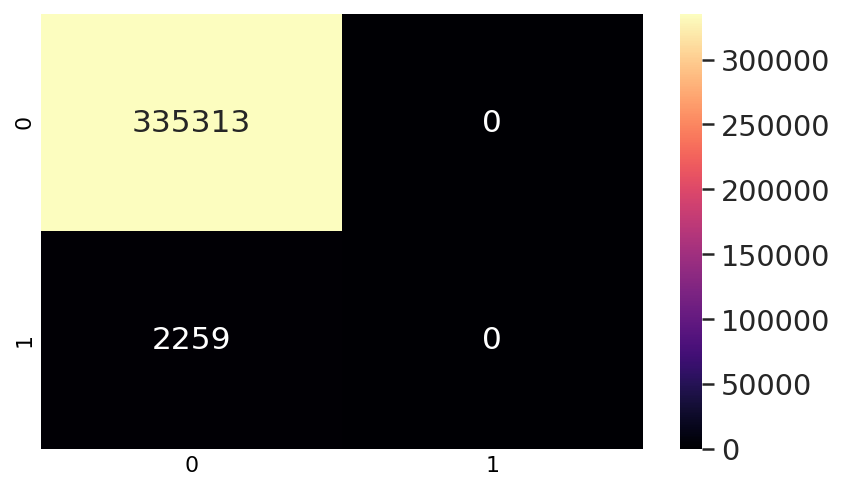

<Figure size 720x504 with 0 Axes>

In [ ]:
y_cv_pred=clf.predict(X_cv)
confusion_matrix = metrics.confusion_matrix(y_cv,  
                                            y_cv_pred)

matrix_df = pd.DataFrame(confusion_matrix)

ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [ ]:
f1_score(y_cv, y_cv_pred, zero_division=1)

0.0

In [ ]:
print("Classification report - \n", classification_report(y_cv,y_cv_pred))

Classification report - 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    335313
           1       0.00      0.00      0.00      2259

    accuracy                           0.99    337572
   macro avg       0.50      0.50      0.50    337572
weighted avg       0.99      0.99      0.99    337572



In [ ]:
y_test_pred=clf.predict(X_test)

<Figure size 720x504 with 0 Axes>

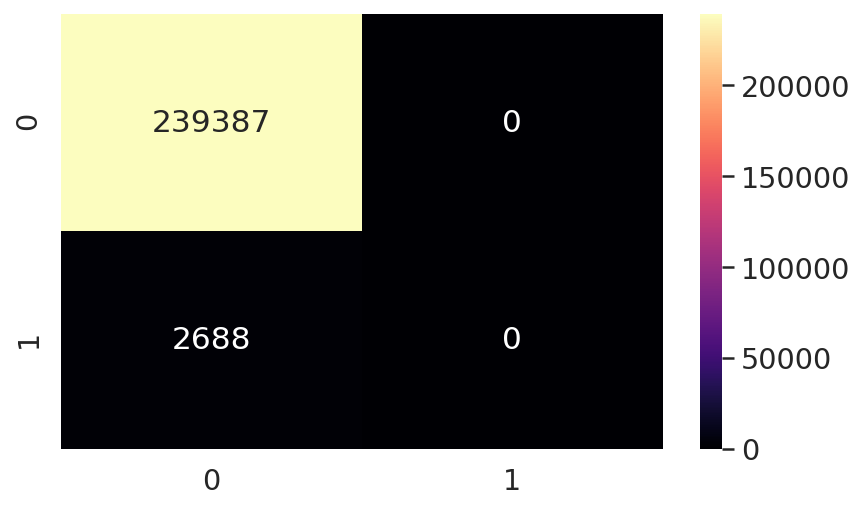

<Figure size 720x504 with 0 Axes>

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test,  
                                            y_test_pred)

matrix_df = pd.DataFrame(confusion_matrix)

ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [ ]:
print("Classification report - \n", classification_report(y_test,y_test_pred))

Classification report - 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    239387
           1       0.00      0.00      0.00      2688

    accuracy                           0.99    242075
   macro avg       0.49      0.50      0.50    242075
weighted avg       0.98      0.99      0.98    242075



In [ ]:

grid = {'base_estimator__max_depth' : [1, 2, 3, 4, 5],'max_samples' : [0.05, 0.1, 0.2, 0.5]}

In [ ]:
grid

{'base_estimator__max_depth': [1, 2, 3, 4, 5],
 'max_samples': [0.05, 0.1, 0.2, 0.5]}

In [ ]:
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=0))

In [ ]:
%%time
bagging_cv = RandomizedSearchCV(clf, grid, cv=5,n_jobs=-1)
bagging_cv.fit(X_train,y_train)

CPU times: user 4.79 s, sys: 333 ms, total: 5.12 s
Wall time: 3min 32s


In [ ]:

print("Tuned Bagging classigier Parameters: {}".format(bagging_cv.best_params_))
print("Best score is {}".format(bagging_cv.best_score_))


Tuned Bagging classigier Parameters: {'max_samples': 0.05, 'base_estimator__max_depth': 1}
Best score is 0.9933095754403446


In [ ]:
%%time
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth= 1),max_samples= 0.05,n_jobs=-1,n_estimators=10,random_state=0)
clf.fit(X_train,y_train)

CPU times: user 136 ms, sys: 129 ms, total: 265 ms
Wall time: 2.42 s


<Figure size 720x504 with 0 Axes>

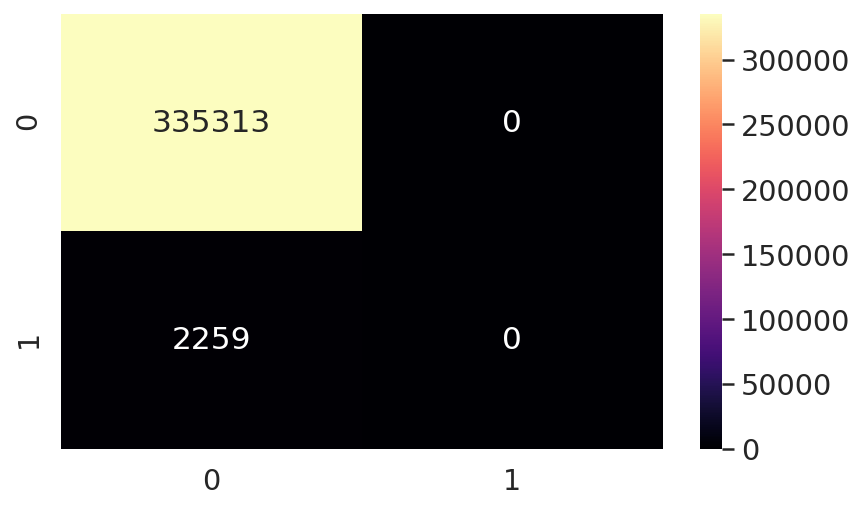

<Figure size 720x504 with 0 Axes>

In [ ]:
y_cv_pred=clf.predict(X_cv)
confusion_matrix = metrics.confusion_matrix(y_cv,  y_cv_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [ ]:
f1_score(y_cv, y_cv_pred, zero_division=1,average='macro')

0.49832140707550326

In [ ]:
print("Classification report - \n", classification_report(y_cv,y_cv_pred))

Classification report - 
               precision    recall  f1-score   support

           0       1.00      0.83      0.90    335313
           1       0.03      0.87      0.06      2259

    accuracy                           0.83    337572
   macro avg       0.52      0.85      0.48    337572
weighted avg       0.99      0.83      0.90    337572



<Figure size 720x504 with 0 Axes>

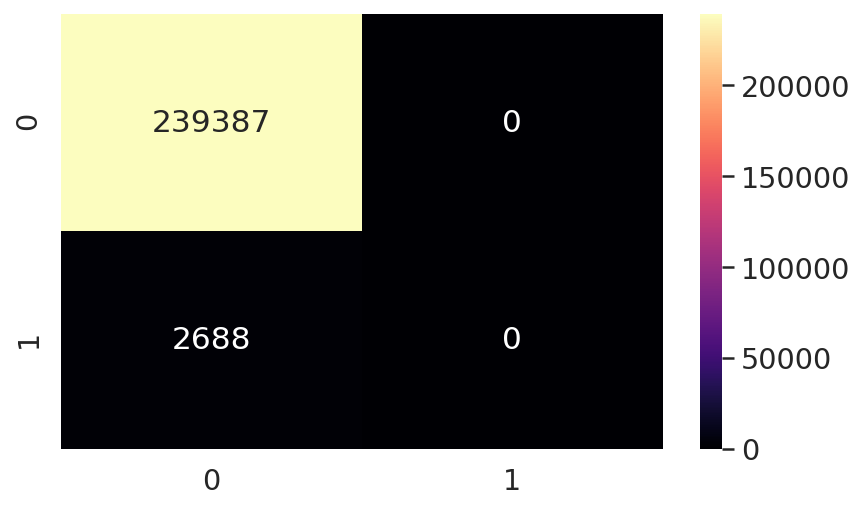

<Figure size 720x504 with 0 Axes>

In [ ]:
#test_data prediction

y_test_pred=clf.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [ ]:

f1_score(y_test, y_test_pred, zero_division=1,average='macro')

0.49720850243632936

Random Forest

In [ ]:
# # Number of trees in random forest
# n_estimators = [200,500,1000,1500,2000]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [10,20,30,40,50]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

random_grid = {
        'n_estimators': randint(low=100, high=300),
        'max_features': randint(low=8, high=17),
    }

In [ ]:
%%time
rf_clf =  RandomForestClassifier(random_state=1)
rf_cv = RandomizedSearchCV(rf_clf, random_grid,random_state=42,verbose=2,n_jobs=-1)
rf_cv.fit(X_train,y_train)

In [ ]:
print(rf_cv.best_estimator_)
print("Tuned random forest classifier Parameters: {}".format(rf_cv.best_params_))
print("Best score is {}".format(rf_cv.best_score_))


In [ ]:
%%time

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train,y_train)

CPU times: user 2min 42s, sys: 262 ms, total: 2min 42s
Wall time: 2min 42s


<Figure size 720x504 with 0 Axes>

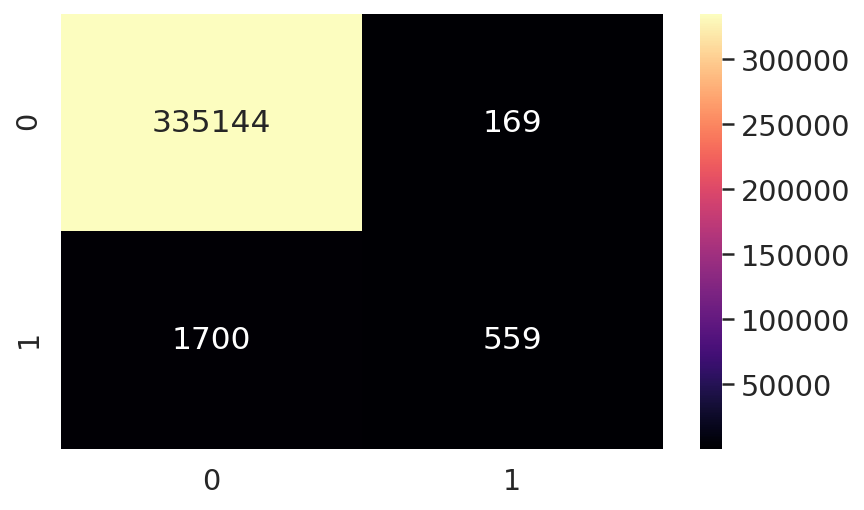

<Figure size 720x504 with 0 Axes>

In [ ]:
y_cv_pred=rf_clf.predict(X_cv)
confusion_matrix = metrics.confusion_matrix(y_cv,  y_cv_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [ ]:
print("Classification report - \n", classification_report(y_cv,y_cv_pred))

Classification report - 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    335313
           1       0.77      0.25      0.37      2259

    accuracy                           0.99    337572
   macro avg       0.88      0.62      0.69    337572
weighted avg       0.99      0.99      0.99    337572



In [ ]:
f1_score(y_cv,y_cv_pred,average='macro')

0.68575399174886

<Figure size 720x504 with 0 Axes>

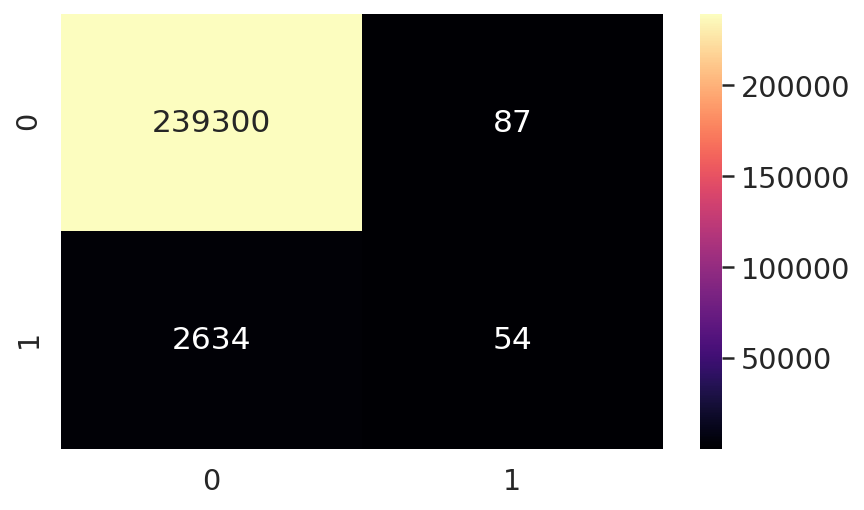

<Figure size 720x504 with 0 Axes>

In [ ]:
#test_data prediction

y_test_pred=rf_clf.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [ ]:
f1_score(y_test,y_test_pred,average='macro')

0.5162614209947918

Extra Trees

In [ ]:
ext_clf = ExtraTreesClassifier()

random_grid = {"max_depth": [None],
              "max_features": [10, 17],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "n_estimators" :[50,100,200],
              "criterion": ["gini"]}

In [ ]:
%%time

rf_cv = RandomizedSearchCV(ext_clf, random_grid,random_state=42,verbose=2,n_jobs=-1)
rf_cv.fit(X_train,y_train)

In [ ]:
ext_clf.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

<Figure size 720x504 with 0 Axes>

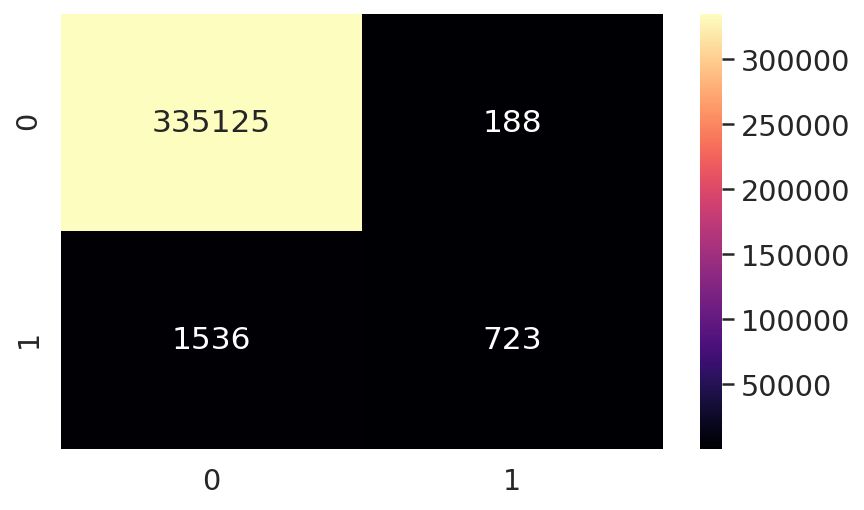

<Figure size 720x504 with 0 Axes>

In [ ]:
y_cv_pred=ext_clf.predict(X_cv)
confusion_matrix = metrics.confusion_matrix(y_cv,  y_cv_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [ ]:
f1_score(y_cv, y_cv_pred,average='macro')

0.7267929220522737

<Figure size 720x504 with 0 Axes>

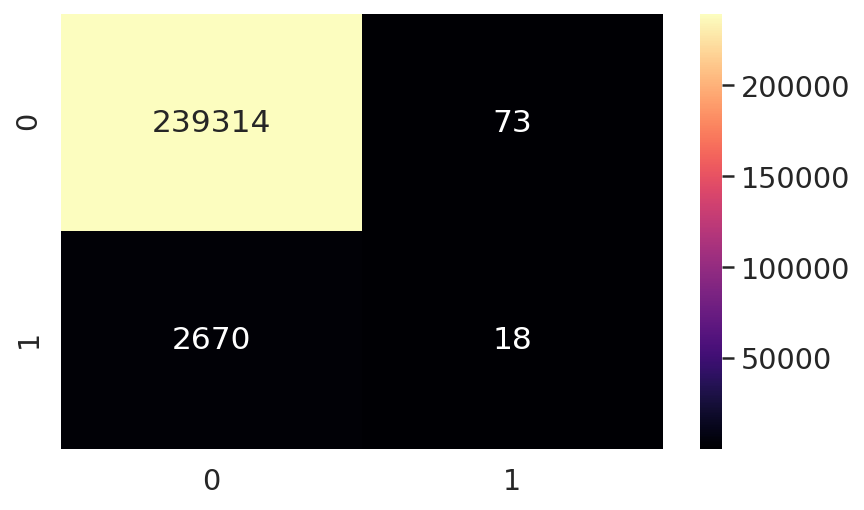

<Figure size 720x504 with 0 Axes>

In [ ]:
#test_data prediction

y_test_pred=ext_clf.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [ ]:
f1_score(y_test, y_test_pred, zero_division=1,average='macro')

0.5036279962827686

AdaBoost

In [ ]:
%%time
 

param_grid = {
              "n_estimators": [100, 200],
              'learning_rate':[0.001,0.01,0.1,0.2,0.5
                               ]
             }


clf = DecisionTreeClassifier(random_state = 11)
ab = AdaBoostClassifier(base_estimator = clf)
ab_cv = RandomizedSearchCV(ab, param_grid, scoring = 'accuracy')
ab_cv.fit(X_train,y_train)

In [ ]:
print("Tuned random forest classifier Parameters: {}".format(ab_cv.best_params_))
print("Best score is {}".format(ab_cv.best_score_))

In [ ]:
%%time
ada_clf=AdaBoostClassifier()
ada_clf.fit(X_train,y_train)

CPU times: user 44.7 s, sys: 137 ms, total: 44.8 s
Wall time: 44.7 s


<Figure size 720x504 with 0 Axes>

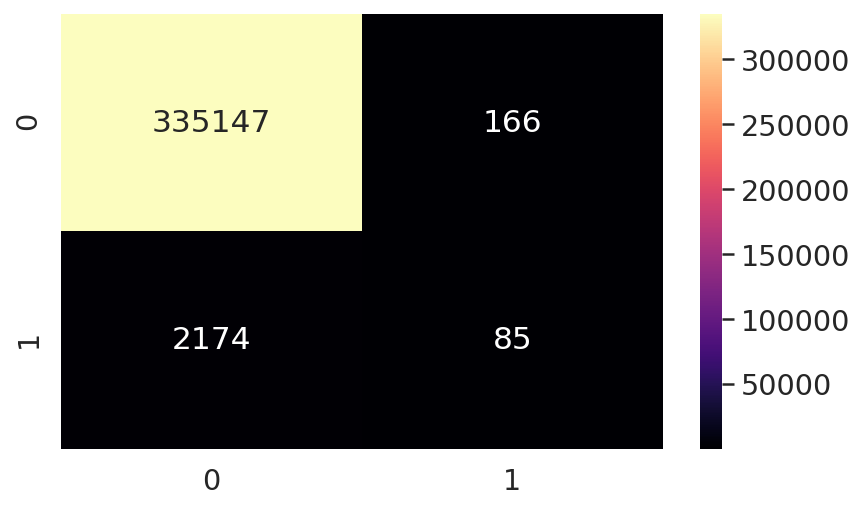

<Figure size 720x504 with 0 Axes>

In [ ]:
y_cv_pred=ada_clf.predict(X_cv)
confusion_matrix = metrics.confusion_matrix(y_cv,  y_cv_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


<Figure size 720x504 with 0 Axes>

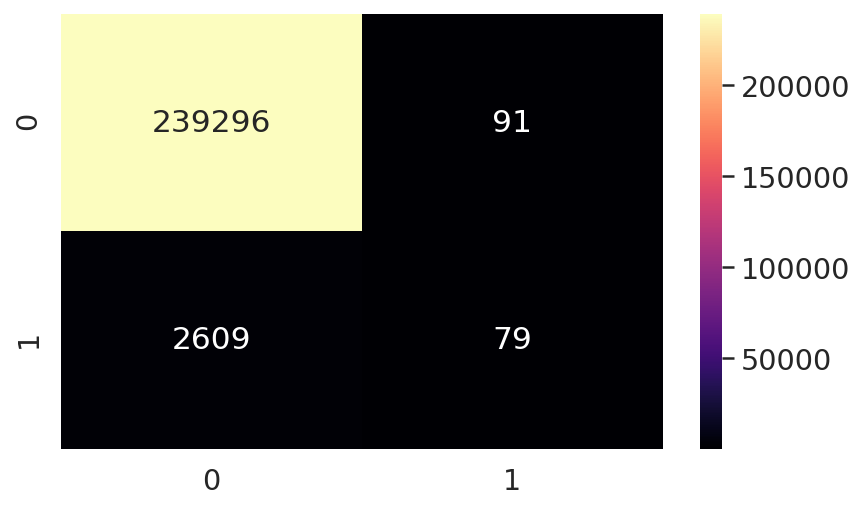

<Figure size 720x504 with 0 Axes>

In [ ]:
#test_data prediction

y_test_pred=ada_clf.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [ ]:
f1_score(y_cv, y_cv_pred, zero_division=1,average='macro')
print('\n')
f1_score(y_test, y_test_pred, zero_division=1,average='macro')

0.5321251114738115

0.524836757478196

In [ ]:
print("Classification report - \n", classification_report(y_cv,y_cv_pred))

Classification report - 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    335313
           1       0.34      0.04      0.07      2259

    accuracy                           0.99    337572
   macro avg       0.67      0.52      0.53    337572
weighted avg       0.99      0.99      0.99    337572



Custom Model Implementation

In [ ]:
train,cv,train_y,cv_y=train_test_split(X,y,test_size=.2,random_state=100,stratify=y)
%%time
sample_data=[]
sample_targets =[]
selected_row= []
selected_columns=[]

for i in range(10):
    a,b,c,d = generating_samples(D1, y_D1)
    a=a.values.tolist()
    c=c.values.tolist()
    sample_data.append(a)
    sample_targets.append(b)
    selected_row.append(c)
    selected_columns.append(d)
    
models=[]
for i,j in zip(sample_data,sample_targets):
    model=ExtraTreesClassifier()
    model.fit(i,j)
    models.append(model)

D2=pd.DataFrame(D2)
y_D2=pd.DataFrame(y_D2)
predictions=[]
i=0
for model in models:
  y_D2_pred=model.predict(D2[selected_columns[i]])
  i+=1
  predictions.append(y_D2_pred)

j=0
for i in predictions:
  j+=1
  print("Model",j," ",f1_score(y_D2,i))

pred=np.transpose(predictions)
ext_clf = ExtraTreesClassifier()
ext_clf.fit(pred,y_D2)
X_cv=pd.DataFrame(X_cv)
y_cv=pd.DataFrame(y_cv)

test_predictions=[]
i=0
for model in models:
  y_cv_pred=model.predict(X_cv[selected_columns[i]])
  i+=1
  test_predictions.append(y_cv_pred)

j=0
for i in test_predictions:
  j+=1
  print("Model",j," ",f1_score(y_cv,i))

meta_predictions=ext_clf.predict(np.transpose(test_predictions))
print("The F1 score of metaclassifier is %.6f"%f1_score(y_cv,meta_predictions,zero_division=1))
X_test=pd.DataFrame(X_test)
y_test=pd.DataFrame(y_test)

tests_predictions=[]
i=0
for model in models:
  y_test_pred=model.predict(X_test[selected_columns[i]])
  i+=1
  tests_predictions.append(y_test_pred)

j=0
for i in tests_predictions:
  j+=1
  print("Model",j," ",f1_score(y_test,i))

meta_test_predictions=ext_clf.predict(np.transpose(tests_predictions))
print("The f1 score of metaclassifier is %.6f"%f1_score(y_test,meta_test_predictions))

In [ ]:
import random
import math

    

def create_base_models(sample_data,sample_targets,base_model):
  models=[]
  for i,j in zip(sample_data,sample_targets):
    model=base_model
    model.fit(i,j)
    models.append(model)
  return models

def samples(n_estimators,data,y_data):
  sample_data=[]
  sample_targets =[]
  selected_row= []
  selected_columns=[]

  for i in range(n_estimators):
    a,b,c,d = generating_samples(data, y_data)
    a=a.values.tolist()
    c=c.values.tolist()
    sample_data.append(a)
    sample_targets.append(b)
    selected_row.append(c)
    selected_columns.append(d)
  return sample_data,sample_targets,selected_row,selected_columns

def baseModel_predictions(models,data,selected_columns):
  predictions=[]
  i=0
  for model in models:
    y_data_pred=model.predict(data[selected_columns[i]])
    i+=1
    predictions.append(y_data_pred)
  return predictions

def get_f1Score(true,pred):
  return f1_score(true,pred,zero_division=1)


In [ ]:

def custom_ensemble(X_train,y_train,X_test,n_estimators):
  #Splitting Data
  D1,D2,y_D1,y_D2=train_test_split(X_train,y_train,test_size=0.5,random_state=100,stratify=y_train)
  #Creating samples
  sample_data,sample_targets,selected_row,selected_columns=samples(n_estimators,D1,y_D1)
  #Creating Base Models
  models=create_base_models(sample_data,sample_targets,DecisionTreeClassifier())
  #D2 prediction
  predictions=baseModel_predictions(models,D2,selected_columns)
  #f1 score of D2
  D2_f1=[]
  for i in predictions:
    D2_f1.append(get_f1Score(y_D2,i))
   
  # meta classifier
  pred=np.transpose(predictions)
  meta_model = XGBClassifier()
  meta_model.fit(pred,y_D2)
  
  X_test=pd.DataFrame(X_test)
  test_predictions=baseModel_predictions(models,X_test,selected_columns)
  meta_test_predictions=meta_model.predict(np.transpose(tests_predictions))

  return meta_test_predictions,test_predictions,D2_f1


test_pred,test_predictions,D2_f1=custom_ensemble(train,train_y,X_test,40)

In [ ]:
train,cv,train_y,cv_y=train_test_split(X,y,test_size=.2,random_state=100,stratify=y)

In [13]:
%%time

def custom_ensemble(train,train_y,X_test,y_test,n_estimators):
    D1,D2,y_D1,y_D2=train_test_split(train,train_y,test_size=0.5,random_state=100,stratify=train_y)
    sample_data=[]
    sample_targets =[]
    selected_columns=[]

    for i in range(n_estimators):
        sample_rows=D1.sample(frac=.8)
        sample_columns=D1.sample(n=6,axis=1)
        selected_columns.append(sample_columns.columns.values)
        sample_data.append(sample_rows[sample_columns.columns.values])
        sample_targets.append(y_D1[sample_rows.index.values])   
        
    models=[]
    for i,j in zip(sample_data,sample_targets):
        model=DecisionTreeClassifier()
        model.fit(i,j)
        models.append(model)
    
    predictions=[]
    i=0
    for model in models:
        y_D2_pred=model.predict(D2[selected_columns[i]])
        i+=1
        predictions.append(y_D2_pred)
    d2_f1=[]
    for i in predictions:
        d2_f1.append(f1_score(y_D2,i))
    
    pred=np.transpose(predictions)
    
    meta_clf = XGBClassifier()
    meta_clf.fit(pred,y_D2)
    
    test_predictions=[]
    i=0
    for model in models:
      y_test_pred=model.predict(X_test[selected_columns[i]])
      i+=1
      test_predictions.append(y_test_pred)
    
    test_f1=[]
    for i in test_predictions:
        test_f1.append(f1_score(y_test,i))
        
    meta_test_predictions=meta_clf.predict(np.transpose(test_predictions))
    
    return d2_f1,test_f1,meta_clf,meta_test_predictions



d2_f1,test_f1,meta_clf,meta_test_predictions=custom_ensemble(X,y,X_test,y_test,100)

    




CPU times: user 7min 43s, sys: 5.75 s, total: 7min 49s
Wall time: 7min 47s


<Figure size 720x504 with 0 Axes>

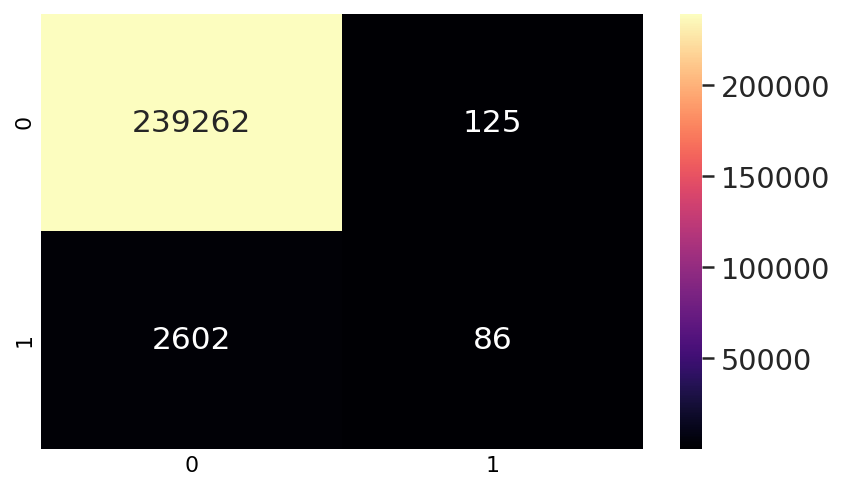

<Figure size 720x504 with 0 Axes>

In [14]:
#test_data prediction

confusion_matrix = metrics.confusion_matrix(y_test, meta_test_predictions)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [15]:
f1_score(y_test,meta_test_predictions,average='macro')

0.5268321609967183

BALANCED DATA 

In [23]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X, y)
counter = Counter(y_train)
print(counter)

Counter({0: 1676567, 1: 1676567})


In [ ]:

model = DecisionTreeClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
print('ROC AUC %.3f' % np.mean(scores))

ROC AUC 0.989


Decision Tree Classifier

In [ ]:
param_dist = {"max_depth": randint(1,9),
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 5),
              "criterion": ["gini", "entropy"]}


In [ ]:
tree = DecisionTreeClassifier()


In [ ]:
%%time
tree_cv = RandomizedSearchCV(tree, param_dist, cv=10,n_jobs=-1)
tree_cv.fit(X_train,y_train)

CPU times: user 12.1 s, sys: 335 ms, total: 12.5 s
Wall time: 4min 10s


In [ ]:
tree_cv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))



Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 7, 'min_samples_leaf': 3}


In [ ]:
%%time
clf = DecisionTreeClassifier(criterion='gini',max_depth=1,max_features=7,min_samples_leaf=3)
clf.fit(X_train,y_train)

CPU times: user 1.59 s, sys: 14.3 ms, total: 1.6 s
Wall time: 1.59 s


<Figure size 720x504 with 0 Axes>

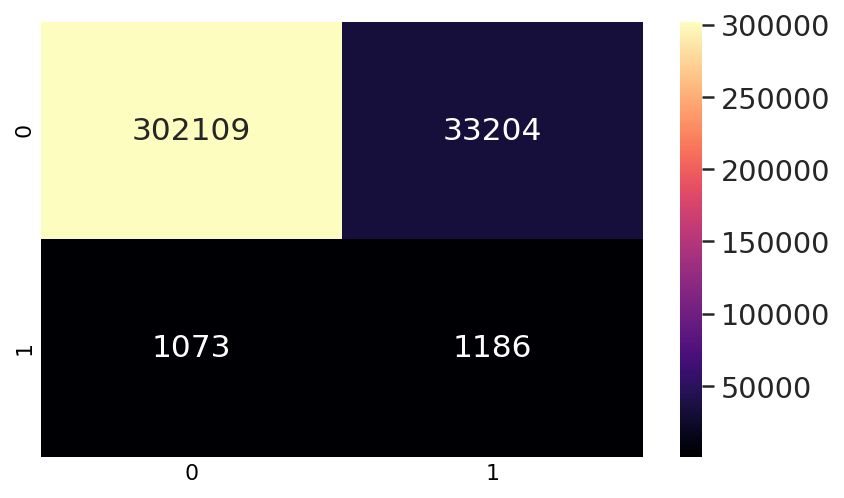

<Figure size 720x504 with 0 Axes>

In [ ]:
y_cv_pred=clf.predict(X_cv)
confusion_matrix = metrics.confusion_matrix(y_cv,  
                                            y_cv_pred)

matrix_df = pd.DataFrame(confusion_matrix)

ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [ ]:
print("Classification report - \n", classification_report(y_cv,y_cv_pred))

Classification report - 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    335313
           1       0.03      0.53      0.06      2259

    accuracy                           0.90    337572
   macro avg       0.52      0.71      0.51    337572
weighted avg       0.99      0.90      0.94    337572



<Figure size 720x504 with 0 Axes>

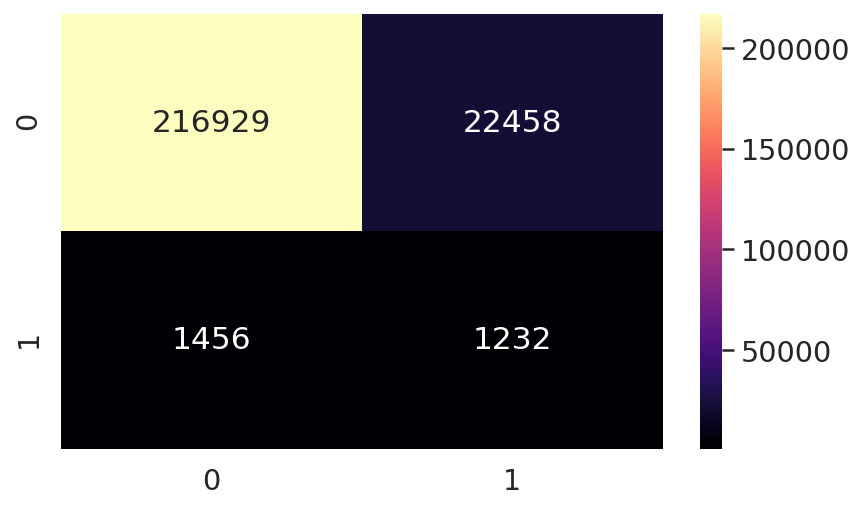

<Figure size 720x504 with 0 Axes>

In [ ]:
y_test_pred=clf.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test,  
                                            y_test_pred)

matrix_df = pd.DataFrame(confusion_matrix)

ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [ ]:
print("Classification report - \n", classification_report(y_test,y_test_pred))

Classification report - 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95    239387
           1       0.05      0.46      0.09      2688

    accuracy                           0.90    242075
   macro avg       0.52      0.68      0.52    242075
weighted avg       0.98      0.90      0.94    242075



In [ ]:
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print(roc_auc_score(y_cv, clf.predict_proba(X_cv)[:, 1]))

0.6822593575813779
0.7129935848842331


In [ ]:

grid = {'base_estimator__max_depth' : [1, 2, 3, 4, 5],'max_samples' : [0.05, 0.1, 0.2, 0.5]}

In [ ]:
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=0))

In [ ]:
%%time
bagging_cv = RandomizedSearchCV(clf, grid, cv=5,n_jobs=-1)
bagging_cv.fit(X_train,y_train)

CPU times: user 30.7 s, sys: 587 ms, total: 31.3 s
Wall time: 8min 49s


In [ ]:

print("Tuned Bagging classigier Parameters: {}".format(bagging_cv.best_params_))
print("Best score is {}".format(bagging_cv.best_score_))


Tuned Bagging classigier Parameters: {'max_samples': 0.2, 'base_estimator__max_depth': 5}
Best score is 0.8648242612049968


In [ ]:
%%time
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth= 5),max_samples= 0.2,n_jobs=-1,random_state=0)
clf.fit(X_train,y_train)

CPU times: user 260 ms, sys: 109 ms, total: 368 ms
Wall time: 17.6 s


<Figure size 720x504 with 0 Axes>

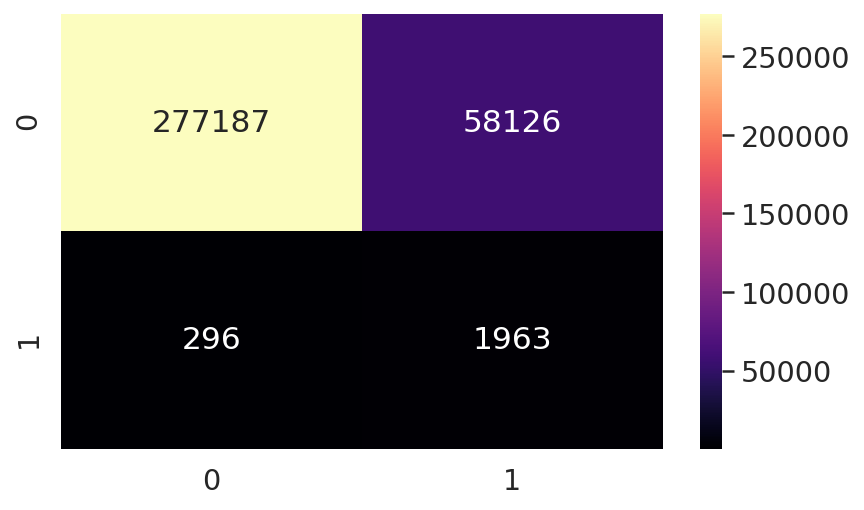

<Figure size 720x504 with 0 Axes>

In [ ]:
y_cv_pred=clf.predict(X_cv)
confusion_matrix = metrics.confusion_matrix(y_cv,  y_cv_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [ ]:
f1_score(y_cv, y_cv_pred, zero_division=1,average='macro')

0.48381617838406404

In [ ]:
print("Classification report - \n", classification_report(y_cv,y_cv_pred))

Classification report - 
               precision    recall  f1-score   support

           0       1.00      0.83      0.90    335313
           1       0.03      0.87      0.06      2259

    accuracy                           0.83    337572
   macro avg       0.52      0.85      0.48    337572
weighted avg       0.99      0.83      0.90    337572



<Figure size 720x504 with 0 Axes>

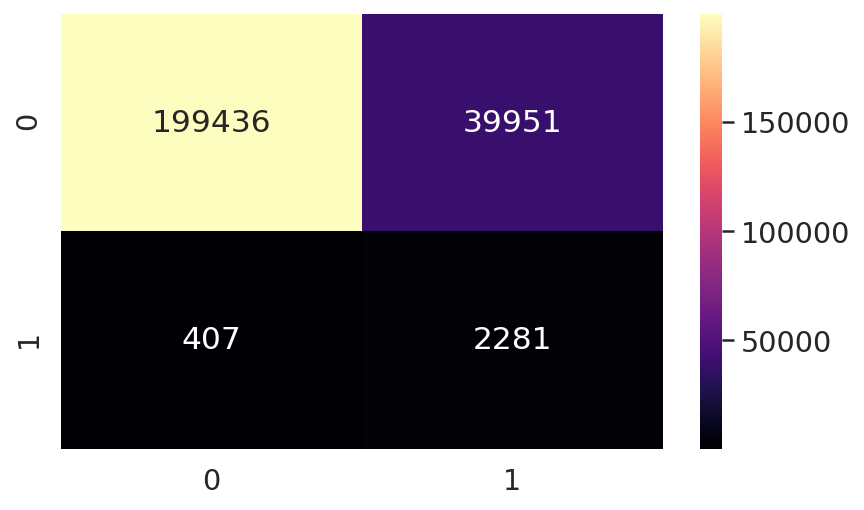

<Figure size 720x504 with 0 Axes>

In [ ]:
#test_data prediction

y_test_pred=clf.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [ ]:

f1_score(y_test, y_test_pred, zero_division=1,average='macro')

0.5048374012369944

In [ ]:
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print(roc_auc_score(y_cv, clf.predict_proba(X_cv)[:, 1]))

0.9052303282210198
0.9133020960626392


Random Forest

In [ ]:
# # Number of trees in random forest
# n_estimators = [200,500,1000,1500,2000]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [10,20,30,40,50]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

random_grid = {
        'n_estimators': randint(low=100, high=300),
        'max_features': randint(low=8, high=17),
    }

In [ ]:
%%time
rf_clf =  RandomForestClassifier(random_state=1)
rf_cv = RandomizedSearchCV(rf_clf, random_grid,random_state=42,verbose=2,n_jobs=-1)
rf_cv.fit(X_train,y_train)

In [ ]:
print(rf_cv.best_estimator_)
print("Tuned random forest classifier Parameters: {}".format(rf_cv.best_params_))
print("Best score is {}".format(rf_cv.best_score_))


In [24]:
%%time

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train,y_train)

CPU times: user 24min 8s, sys: 2.09 s, total: 24min 10s
Wall time: 24min 3s


<Figure size 720x504 with 0 Axes>

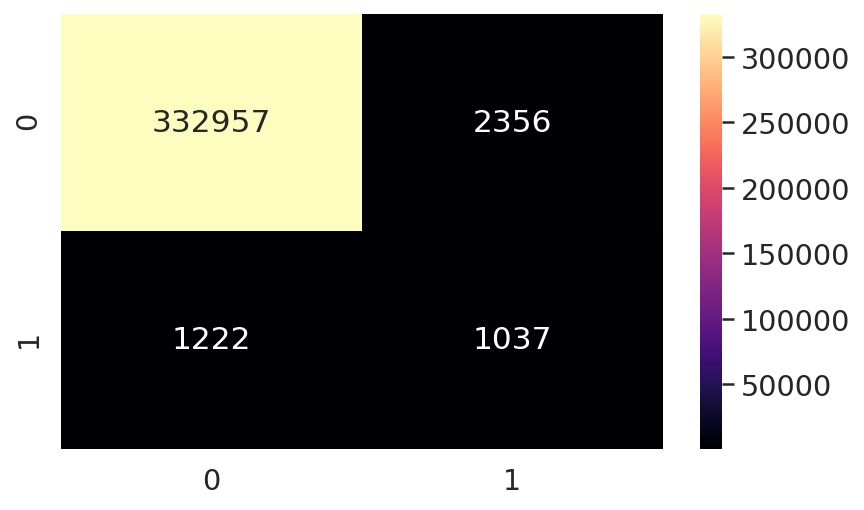

<Figure size 720x504 with 0 Axes>

In [ ]:
y_cv_pred=rf_clf.predict(X_cv)
confusion_matrix = metrics.confusion_matrix(y_cv,  y_cv_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [ ]:
print("Classification report - \n", classification_report(y_cv,y_cv_pred))

Classification report - 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    335313
           1       0.31      0.46      0.37      2259

    accuracy                           0.99    337572
   macro avg       0.65      0.73      0.68    337572
weighted avg       0.99      0.99      0.99    337572



<Figure size 720x504 with 0 Axes>

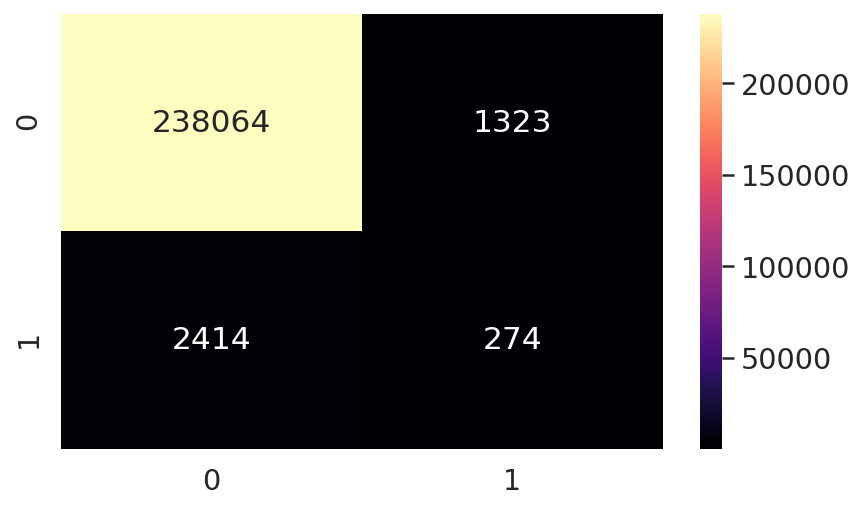

<Figure size 720x504 with 0 Axes>

In [25]:
#test_data prediction

y_test_pred=rf_clf.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [26]:
f1_score(y_test,y_test_pred,average='macro')

0.5600501871995528

In [ ]:
print(roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1]))
print(roc_auc_score(y_cv, rf_clf.predict_proba(X_cv)[:, 1]))

0.8226988437555884
0.9513865829457709


Extra Trees

In [ ]:
ext_clf = ExtraTreesClassifier()

random_grid = {"max_depth": [None],
              "max_features": [10, 17],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "n_estimators" :[50,100,200],
              "criterion": ["gini"]}

In [ ]:
%%time

rf_cv = RandomizedSearchCV(ext_clf, random_grid,random_state=42,verbose=2,n_jobs=-1)
rf_cv.fit(X_train,y_train)

In [ ]:
ext_clf.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

<Figure size 720x504 with 0 Axes>

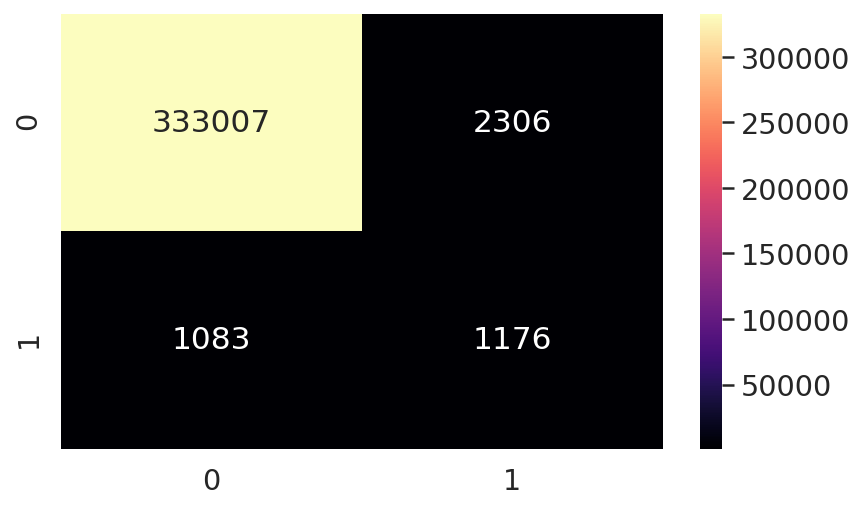

<Figure size 720x504 with 0 Axes>

In [ ]:
y_cv_pred=ext_clf.predict(X_cv)
confusion_matrix = metrics.confusion_matrix(y_cv,  y_cv_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [ ]:
f1_score(y_cv, y_cv_pred,average='macro')

0.7038945908276472

<Figure size 720x504 with 0 Axes>

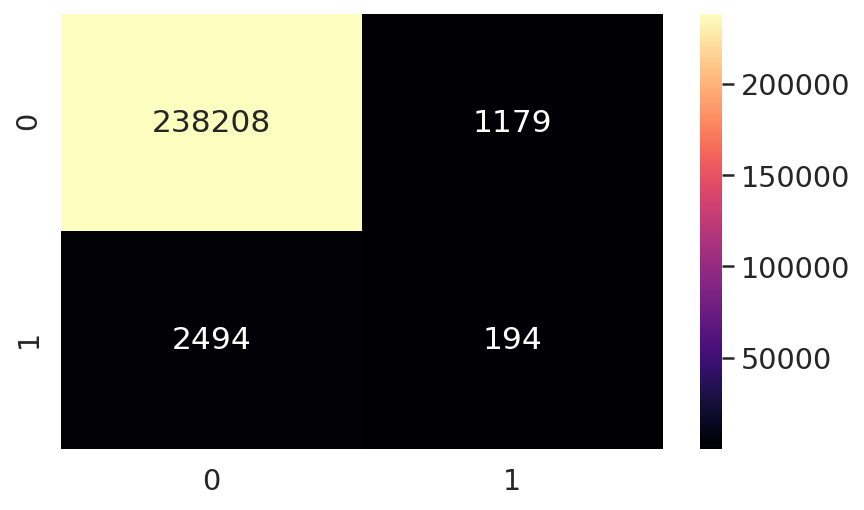

<Figure size 720x504 with 0 Axes>

In [ ]:
#test_data prediction

y_test_pred=ext_clf.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [ ]:
f1_score(y_test, y_test_pred, zero_division=1,average='macro')

0.5428195867788322

In [ ]:
f1_score(y_test, y_test_pred, zero_division=1,average='macro')

0.5439461524696602

In [ ]:
print(roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1]))
print(roc_auc_score(y_cv, rf_clf.predict_proba(X_cv)[:, 1]))

0.8226988437555884
0.9513865829457709


AdaBoost

In [ ]:
%%time
 

param_grid = {
              "n_estimators": [100, 200],
              'learning_rate':[0.001,0.01,0.1,0.2,0.5
                               ]
             }


clf = DecisionTreeClassifier(random_state = 11)
ab = AdaBoostClassifier(base_estimator = clf)
ab_cv = RandomizedSearchCV(ab, param_grid, scoring = 'accuracy')
ab_cv.fit(X_train,y_train)

In [ ]:
print("Tuned random forest classifier Parameters: {}".format(ab_cv.best_params_))
print("Best score is {}".format(ab_cv.best_score_))

In [ ]:
%%time
ada_clf=AdaBoostClassifier()
ada_clf.fit(X_train,y_train)

CPU times: user 2min 55s, sys: 333 ms, total: 2min 55s
Wall time: 2min 54s


<Figure size 720x504 with 0 Axes>

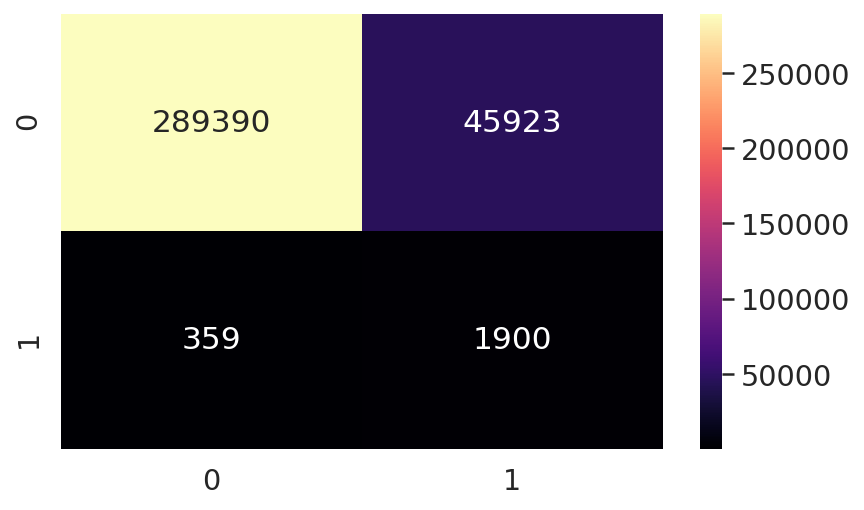

<Figure size 720x504 with 0 Axes>

In [ ]:
y_cv_pred=ada_clf.predict(X_cv)
confusion_matrix = metrics.confusion_matrix(y_cv,  y_cv_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


<Figure size 720x504 with 0 Axes>

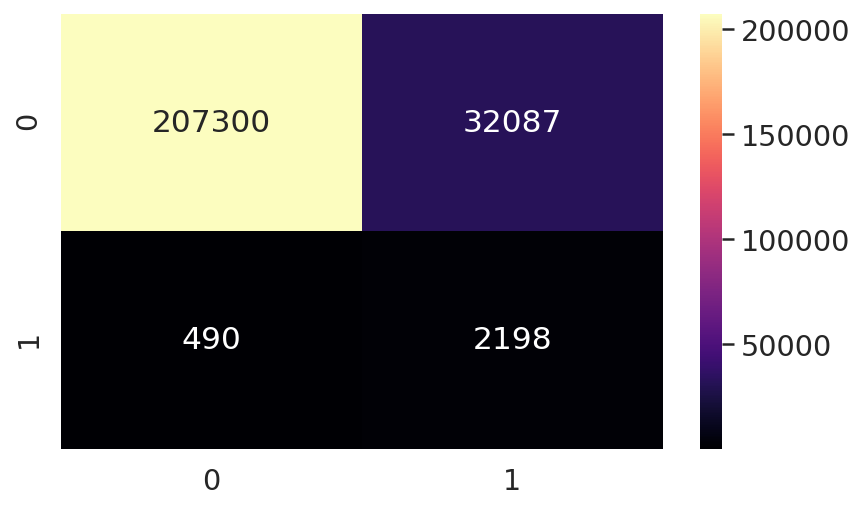

<Figure size 720x504 with 0 Axes>

In [ ]:
#test_data prediction

y_test_pred=ada_clf.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [ ]:
f1_score(y_cv, y_cv_pred, zero_division=1,average='macro')
print('\n')
f1_score(y_test, y_test_pred, zero_division=1,average='macro')

0.5009158546126591

0.5230236130282219

In [ ]:
print(roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1]))
print(roc_auc_score(y_cv, rf_clf.predict_proba(X_cv)[:, 1]))

0.8226988437555884
0.9513865829457709


In [ ]:
print("Classification report - \n", classification_report(y_test,y_test_pred))

Classification report - 
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    239387
           1       0.06      0.82      0.12      2688

    accuracy                           0.87    242075
   macro avg       0.53      0.84      0.52    242075
weighted avg       0.99      0.87      0.92    242075



Custom Model Implementation

In [ ]:
train,cv,train_y,cv_y=train_test_split(X,y,test_size=.2,random_state=100,stratify=y)

In [ ]:
X_test.columns

Index(['perf_6_month_avg', 'pieces_past_due', 'sales_6_month',
       'forecast_6_month', 'in_transit_qty', 'potential_issue', 'national_inv',
       'lead_time', 'oe_constraint', 'min_bank', 'reorder_point'],
      dtype='object')

In [ ]:
X_train=pd.DataFrame(X_train,columns=X_test.columns)

In [ ]:
y_train=pd.DataFrame(y_train)

In [ ]:
%%time

def custom_ensemble(train,train_y,X_test,y_test,n_estimators):
    D1,D2,y_D1,y_D2=train_test_split(train,train_y,test_size=0.5,random_state=100,stratify=y_train)
    sample_data=[]
    sample_targets =[]
    selected_columns=[]
    i=0
    for i in range(n_estimators):
        
        sample_rows=D1.sample(frac=.8)
        sample_columns=D1.sample(n=6,axis=1)
        selected_columns.append(sample_columns.columns.values)
        sample_data.append(sample_rows[sample_columns.columns.values])
        sample_targets.append(y_D1.loc[sample_rows.index.values])  
        
    models=[]
    for i,j in zip(sample_data,sample_targets):
        model=DecisionTreeClassifier()
        model.fit(i,j)
        models.append(model)
    
    predictions=[]
    i=0
    for model in models:
        y_D2_pred=model.predict(D2[selected_columns[i]])
        i+=1
        predictions.append(y_D2_pred)
    d2_f1=[]
    for i in predictions:
        d2_f1.append(f1_score(y_D2,i))
    
    pred=np.transpose(predictions)
    
    meta_clf = XGBClassifier()
    meta_clf.fit(pred,y_D2)
    
    test_predictions=[]
    i=0
    for model in models:
      y_test_pred=model.predict(X_test[selected_columns[i]])
      i+=1
      test_predictions.append(y_test_pred)
    
    test_f1=[]
    for i in test_predictions:
        test_f1.append(f1_score(y_test,i))
        
    meta_test_predictions=meta_clf.predict(np.transpose(test_predictions))
    
    return d2_f1,test_f1,meta_clf,meta_test_predictions



d2_f1,test_f1,meta_clf,meta_test_predictions=custom_ensemble(X_train,y_train,X_test,y_test,2)

    




CPU times: user 44.3 s, sys: 225 ms, total: 44.5 s
Wall time: 44.3 s


<Figure size 720x504 with 0 Axes>

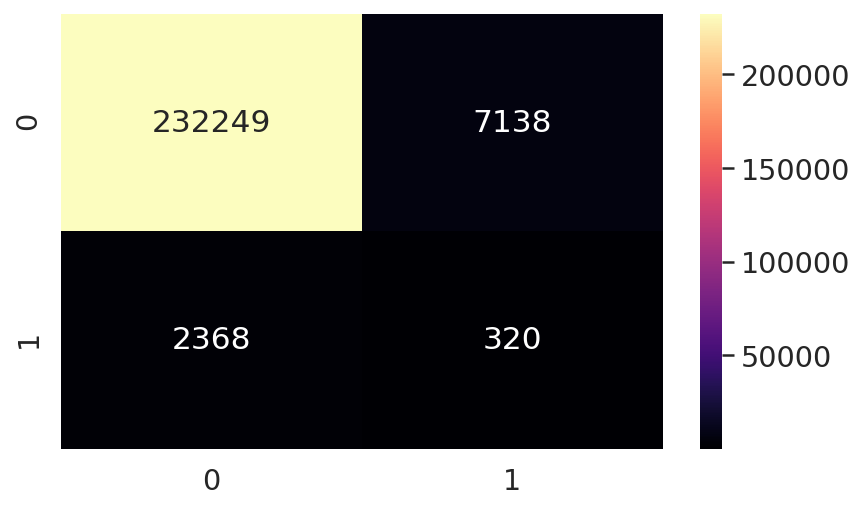

<Figure size 720x504 with 0 Axes>

In [ ]:
#test_data prediction

confusion_matrix = metrics.confusion_matrix(y_test, meta_test_predictions)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
plt.show()


In [ ]:
f1_score(y_test,meta_test_predictions,average='macro')

0.5215121814232936

unbalanced data test f1 score

In [ ]:
from prettytable import PrettyTable

# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Model","F1 Score"])

# Add rows
myTable.add_row(["Decision Treee","0.50"])
myTable.add_row(["Extra Trees","0.503"])
myTable.add_row(["Random Forest","0.516"])
myTable.add_row(["AdaBoost","0.524"])
myTable.add_row(["Ensemble","0.530"])
print(myTable)


+----------------+----------+
|     Model      | F1 Score |
+----------------+----------+
| Decision Treee |   0.50   |
|  Extra Trees   |  0.503   |
| Random Forest  |  0.516   |
|    AdaBoost    |  0.524   |
|    Ensemble    |  0.530   |
+----------------+----------+


Balanced data test f1 score 

In [ ]:
from prettytable import PrettyTable

# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Model","F1 Score"])

# Add rows
myTable.add_row(["Decision Treee","0.52"])
myTable.add_row(["Extra Trees","0.54"])
myTable.add_row(["Random Forest","0.56"])
myTable.add_row(["AdaBoost","0.52"])
myTable.add_row(["Ensemble","0.52"])
print(myTable)


+----------------+----------+
|     Model      | F1 Score |
+----------------+----------+
| Decision Treee |   0.52   |
|  Extra Trees   |   0.54   |
| Random Forest  |   0.56   |
|    AdaBoost    |   0.52   |
|    Ensemble    |   0.52   |
+----------------+----------+


FINAL FUNCTIONS

In [61]:
test_row=test_data.iloc[0]
test_row2=test_data.iloc[1]
test_row3=test_data.iloc[2]

In [62]:
test_row=pd.DataFrame(test_row)
test_row2=pd.DataFrame(test_row2)
test_row3=pd.DataFrame(test_row3)

In [63]:
test_row=test_row.transpose()
test_row2=test_row2.transpose()
test_row3=test_row3.transpose()

In [28]:
rf_clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [44]:
def Function1(point):
  if not isinstance(point,pd.DataFrame):
    point=pd.DataFrame(point)
  categorical_list=['potential_issue','deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop']
  features=['perf_6_month_avg','pieces_past_due','sales_6_month','forecast_6_month','in_transit_qty','potential_issue','national_inv','lead_time','oe_constraint','min_bank','reorder_point']
  point['reorder_point']=((point['sales_3_month']/3)*point['lead_time'])+point['national_inv']
  #Preprocess
  point=point.replace({'No':0,'Yes':1})
  point['perf_6_month_avg']=point['perf_6_month_avg'].replace(-99, np.NaN)
  point[data.columns] =point[point.columns].apply(pd.to_numeric, errors='coerce')
  point = point.fillna(0)
  #changing datatypes to int
  point[categorical_list]=point[categorical_list].astype('int64')
  point=point[features]
  prediction=rf_clf.predict(point)
  return prediction



prediction=Function1(test_row3)




[0]


In [64]:
X_test_row,y_test_row=test_row.drop('went_on_backorder',axis=1),test_row['went_on_backorder']

In [65]:
X_test_row2,y_test_row2=test_row2.drop('went_on_backorder',axis=1),test_row2['went_on_backorder']


In [66]:
X_test_row3,y_test_row3=test_row3.drop('went_on_backorder',axis=1),test_row3['went_on_backorder']

In [76]:
def final_fun_2(X,y):
  if not isinstance(X,pd.DataFrame):
    X=pd.DataFrame(X)
  categorical_list=['potential_issue','deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop']
  features=['perf_6_month_avg','pieces_past_due','sales_6_month','forecast_6_month','in_transit_qty','potential_issue','national_inv','lead_time','oe_constraint','min_bank','reorder_X']
  X['reorder_X']=((X['sales_3_month']/3)*X['lead_time'])+X['national_inv']
  #Preprocess
  X=X.replace({'No':0,'Yes':1})
  y=y.replace({'No':0,'Yes':1})
  X['perf_6_month_avg']=X['perf_6_month_avg'].replace(-99, np.NaN)
  X[data.columns] =X[X.columns].apply(pd.to_numeric, errors='coerce')
  X = X.fillna(0)
  #changing datatypes to int
  X[categorical_list]=X[categorical_list].astype('int64')
  X=X[features]
  prediction=rf_clf.predict(X)
  f1=f1_score(prediction,y,average='macro')
  return [prediction,f1]

pred,f1=final_fun_2(X_test_row,y_test_row)
